# Imports

In [13]:
# Imports
import matplotlib.pyplot as plt
from tqdm import tqdm
plt.rcParams["axes.grid"] = False #disable ugly white lines which are present in google colab for matplotlib
import numpy as np
import datetime
today = datetime.datetime.today() #To work with datetime values. Only relative time matters in this project, so selecting a random date is not a problem. 
from sklearn.metrics import classification_report,auc,r2_score,matthews_corrcoef
import shap
from catboost import CatBoostClassifier,CatBoostRegressor,Pool
from catboost.utils import get_roc_curve
import pandas as pd
import re
import os
from scipy.stats import linregress,ttest_ind,ranksums
data_save_path = "./Data/312_Validatie_VKF_Predictiemodellen/"
mimic_extracted_path = "Data/MIMIC_extracted/"
mimic_base_path = "../../MIMIC_IV/mimic-iv-1.0/"
from tabulate import tabulate

In [7]:
pd.set_option('display.max_columns', None)

In [8]:
present = False
if present:
    params = {"ytick.color" : "w",
            "xtick.color" : "w",
            "axes.titlecolor" : "w",
            "axes.labelcolor" : "w",
            "axes.edgecolor" : "w"}
    plt.rcParams.update(params)
    plt.rcParams.update({'font.size': 18})
else:
    params = {"ytick.color" : "black",
            "xtick.color" : "black",
            "axes.titlecolor" : "black",
            "axes.labelcolor" : "black",
            "axes.edgecolor" : "black"}
    plt.rcParams.update(params)

# External Validation

In [4]:
def pandas_result_AF_maker(patient_group_string,X,y,model,append_df):
    (fpr, tpr, thresholds) = get_roc_curve(model, Pool(data=X,label=y), plot=False)
    res_dict = classification_report(y,model.predict(X),target_names=["No-AF","AF"],output_dict=True)

    append_df = pd.concat([append_df,pd.DataFrame(data=[[model_string,validation_type_string,patient_group_string,
                    res_dict["No-AF"]["support"],res_dict["AF"]["support"],
                    res_dict["No-AF"]["recall"],res_dict["AF"]["recall"],
                    res_dict["No-AF"]["precision"],res_dict["AF"]["precision"],
                    res_dict["No-AF"]["f1-score"],res_dict["AF"]["f1-score"],
                    matthews_corrcoef(y,model.predict(X)),auc(fpr,tpr)
                   ]],columns=uzgent_result_dataframe_columns)])
    
    return append_df

# uzgent_result_dataframe_columns=["model","validation_type","patient_group","NO AF patients","AF patients","NO AF recall","AF recall","NO AF precision","AF precision","NO AF f1","AF f1","mcc","auc"]
# uzgent_result_dataframe = pd.DataFrame(columns=uzgent_result_dataframe_columns)

# uzgent_p_value_result_dataframe_columns=["model","comparison","AF_group","p_value"]
# uzgent_p_value_result_dataframe = pd.DataFrame(columns=uzgent_p_value_result_dataframe_columns)

missing_dataframe = pd.DataFrame(columns=["model","feature","train amst","balanced test amst","all test amst","train uzgent","balanced test uzgent","all test uzgent"])

In [52]:
#uzgent_result_dataframe.reset_index(drop=True).to_csv("uzgent_af_prediction_results.csv")

In [9]:
time_margin_model = True
distr_change = True
causal = False

model_string = ("1.5"*int(time_margin_model)+"12"*int(1-time_margin_model))*int(1-causal)+"6"*int(causal)+"u "+"old"*int(1-distr_change)
print(model_string)

1.5u 


## Transfer validation

In [529]:
validation_type_string = "transfer"

### Data import

In [530]:
if time_margin_model:
    if distr_change:
        AF_dataset = pd.read_csv(data_save_path+"AF_dataset_1_5_hours_no_af_distribution_matched.csv") 
    else:
        AF_dataset = pd.read_csv(data_save_path+"AF_dataset_1_5_hours.csv")
else:

    if distr_change:
        AF_dataset = pd.read_csv(data_save_path+"AF_dataset_12_hours_no_af_distribution_matched.csv") 
    else:
        AF_dataset = pd.read_csv(data_save_path+"AF_dataset_12_hours.csv")

if causal:
    if distr_change:
        AF_dataset = pd.read_csv(data_save_path+"AF_dataset_6_hours_no_af_distribution_matched.csv") 
    else:
        AF_dataset = pd.read_csv(data_save_path+"AF_dataset_6_hours.csv")
        
AF_dataset = AF_dataset.rename(columns={"HospAdmissionID":"patientid","AgeOnAdmission":"Age"})
AF_dataset.loc[AF_dataset.sepsis_extra_opn_measuredat > AF_dataset.AF_measuredat,"sepsis_bool_extra_opn"]=0

AF_dataset.loc[(~AF_dataset.bmi.isna())&(AF_dataset.bmi.str.contains(",")),'bmi']=np.NaN

Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.


In [475]:
AF_dataset["is_given_NORepinefrine"]=0
AF_dataset.loc[AF_dataset['mean_CV_norepinephrine']>0,"is_given_NORepinefrine"]=1

#AF_dataset["cardiac_surg_bool"]=0
#AF_dataset.loc[(AF_dataset["cardiac_bool"]==1)&(AF_dataset["surgery_bool"]==1),"cardiac_surg_bool"] = 1

AF_dataset["is_given_Calcium Glubionaat (Calcium Sandoz)"]=0
AF_dataset.loc[(AF_dataset["mean_VI_calcium carbonate"]>1)|(AF_dataset["mean_VI_calcium chloride"]>1),"is_given_Calcium Glubionaat (Calcium Sandoz)"] = 1
    
AF_dataset["is_given_Dopamine (Inotropin)"]=0
AF_dataset.loc[AF_dataset['mean_CV_dopamine']>0,"is_given_Dopamine (Inotropin)"]=1

#AF_dataset['is_given_Magnesiumsulfaat (MgSO4)']=0
#AF_dataset.loc[AF_dataset['mean_Magnesium Sulfate']>0,'is_given_Magnesiumsulfaat (MgSO4)']=1

AF_dataset['is_given_Propofol (Diprivan)']=0
AF_dataset.loc[AF_dataset['mean_NS_propofol']>0,'is_given_Propofol (Diprivan)']=1

AF_dataset['is_given_Fentanyl']=0
AF_dataset.loc[AF_dataset['mean_NS_fentanyl']>0,'is_given_Fentanyl']=1

AF_dataset["is_given_Furosemide (Lasix)"]=0
AF_dataset.loc[AF_dataset['mean_DI_furosemide']>0,"is_given_Furosemide (Lasix)"]=1

AF_dataset["is_given_LoopDiuretics"]=0
AF_dataset.loc[(AF_dataset['mean_DI_furosemide']>0),"is_given_LoopDiuretics"]=1

AF_dataset["sepsis_bool"]=0
AF_dataset.loc[(AF_dataset.sepsis_bool_comorb_source==1) | (AF_dataset.sepsis_bool_extra_opn==1),"sepsis_bool"]=1

AF_dataset.loc[AF_dataset['mean_PEEP_M_ALL'].isna(),"mean_PEEP_M_ALL"]=0


In [476]:
#Rename for distr change 12 hour model
AF_dataset = AF_dataset.rename(columns={'mean_PEEP_M_ALL':'mean_PEEP (Set)', 'is_given_NORepinefrine':'is_given_Noradrenaline (Norepinefrine)', 'mean_URINE_VOL':'mean_UrineCAD', 
                           'min_NS_propofol':'min_Propofol (Diprivan)', 'min_NS_fentanyl':'min_Fentanyl', 'mean_RESPRATE_ALL':'mean_O2 l/min', #'cardiac_bool_new':'cardio_surgery_new',
                           'mean_PHOSPHATE_ALL':'mean_Fosfaat (bloed)', 'kurt_CVD':'kurt_CVD', 'max_HR_ALL':'max_Hartfrequentie', "max_PLATELETS":"max_Thrombo's (bloed)"})

#Rename for distr change 6 hour model
AF_dataset = AF_dataset.rename(columns={'max_RESPRATE_ALL':'max_O2 l/min', #'cardiac_bool_new':'cardio_surgery_new',
                                        'min_PHOSPHATE_ALL':'min_Fosfaat (bloed)', 'mean_CVD':'mean_CVD', 
                                        "min_PLATELETS":"min_Thrombo's (bloed)"})

#Rename for distr change 1.5 hour model
AF_dataset = AF_dataset.rename(columns={'max_UREA_ALL':'max_Ureum (bloed)'})

#Rename for standard 12 hour model
AF_dataset = AF_dataset.rename(columns={"slope_PO2_ART":'slope_PO2 (bloed)'})

#Rename for standard 1.5 hour model
AF_dataset = AF_dataset.rename(columns={ 'min_RESPRATE_ALL':'min_O2 l/min', "mean_PLATELETS":"mean_Thrombo's (bloed)",
                                        'min_CVD':'min_CVD'})

In [477]:
if distr_change:
    AF_temp_db = AF_dataset[(AF_dataset.AF==0)&(AF_dataset.AF_orig==0)&(AF_dataset.patientid!=AF_dataset.date_corresponds_to_AF_admid)]
else:
    AF_temp_db = AF_dataset[(AF_dataset.AF==0)&(AF_dataset.AF_orig==0)].sample(len(AF_dataset[AF_dataset.AF==1]),random_state=42).reset_index(drop=True)

AF_NOW = AF_temp_db.append(AF_dataset[AF_dataset.AF==1]).reset_index(drop=True)

In [478]:
com="""AF_NOW["AF"] = AF_NOW.sofa

AF_NOW = AF_NOW[~AF_NOW.AF.isna()]

AF_temp_db["AF"] = AF_temp_db.sofa
AF_temp_db = AF_temp_db[~AF_temp_db.AF.isna()]
"""

In [479]:
from sklearn.model_selection import train_test_split

train_patientid,test_patientid = train_test_split(AF_NOW.patientid.unique(), test_size=0.2, random_state=42)#,stratify=AF_NOW["AF"])

train_AF_dataset = AF_NOW[AF_NOW.patientid.isin(train_patientid)]
test_AF_dataset = AF_NOW[AF_NOW.patientid.isin(test_patientid)]



In [480]:
X_train_or = train_AF_dataset#[train_AF_dataset.columns.drop(drop_columns)]
X_test_or = test_AF_dataset#[test_AF_dataset.columns.drop(drop_columns)]
y_train = train_AF_dataset.AF
y_test = test_AF_dataset.AF

In [481]:
X_train_or = train_AF_dataset#[(train_AF_dataset.AF==1)|((train_AF_dataset.AF_orig==0)&(train_AF_dataset.AF==0))]#[train_AF_dataset.columns.drop(drop_columns)]
X_test_or = test_AF_dataset#[(test_AF_dataset.AF==1)|((test_AF_dataset.AF_orig==0)&(test_AF_dataset.AF==0))]#[test_AF_dataset.columns.drop(drop_columns)]
y_train = train_AF_dataset.AF#[(train_AF_dataset.AF==1)|((train_AF_dataset.AF_orig==0)&(train_AF_dataset.AF==0))].AF
y_test = test_AF_dataset.AF#[(test_AF_dataset.AF==1)|((test_AF_dataset.AF_orig==0)&(test_AF_dataset.AF==0))].AF

### Testing

In [482]:
if time_margin_model:
    if not distr_change:
        feature_columns = ['Age', 'min_O2 l/min',  'max_Hartfrequentie','is_given_Calcium Glubionaat (Calcium Sandoz)',# 'mean_APTT  (bloed)','is_given_Magnesiumsulfaat (MgSO4)','cardio_surgery_new','min_CRP (bloed)',
         'mean_PEEP (Set)', "mean_Thrombo's (bloed)", 'min_CVD',   'is_given_LoopDiuretics',]
    
    else:
        feature_columns = ['Age', 'mean_O2 l/min', 'max_Hartfrequentie', 'mean_PEEP (Set)', 'is_given_Noradrenaline (Norepinefrine)', 'max_Ureum (bloed)', #'cardiac_surg_bool',
          'is_given_Furosemide (Lasix)', 'is_given_Dopamine (Inotropin)', "max_Thrombo's (bloed)"] 

else:
    if not distr_change:
        feature_columns=['Age', 'slope_PO2 (bloed)', 'is_given_Noradrenaline (Norepinefrine)', #'is_given_Magnesiumsulfaat (MgSO4)',#'min_Magnesiumsulfaat (MgSO4)', 
                           'mean_PEEP (Set)',#'fluidin','mean_Hb (bloed)', 'fluidout',  'admissioncount', 
                           'mean_O2 l/min','mean_UrineCAD',  'sepsis_bool', 'mean_CVD']
    else:
        feature_columns = ['Age', 'mean_PEEP (Set)', 'is_given_Noradrenaline (Norepinefrine)', 'mean_UrineCAD', 
                           'is_given_Propofol (Diprivan)', 'is_given_Fentanyl', 'mean_O2 l/min', #'fluidout', #'cardiac_surg_bool',
                           'mean_Fosfaat (bloed)', 'kurt_CVD', 'max_Hartfrequentie', "max_Thrombo's (bloed)"]

if causal:
    if not distr_change:
        feature_columns=['Age', 'slope_PO2 (bloed)', 'is_given_Noradrenaline (Norepinefrine)', #'is_given_Magnesiumsulfaat (MgSO4)',#'min_Magnesiumsulfaat (MgSO4)', 
                           'mean_PEEP (Set)',#'mean_Hb (bloed)','fluidout', 'fluidin', 'admissioncount',
                           'mean_O2 l/min',  'mean_UrineCAD',  'sepsis_bool', 'mean_CVD']
    else:
        feature_columns = ['Age', 'max_O2 l/min', 'min_Fosfaat (bloed)', 'mean_PEEP (Set)', 'is_given_Noradrenaline (Norepinefrine)',
                       'is_given_Calcium Glubionaat (Calcium Sandoz)', 'max_Hartfrequentie', #'fluidout',
                       "min_Thrombo's (bloed)",  'mean_CVD']
        
X_train=X_train_or[feature_columns]    
X_test= X_test_or[feature_columns] 

In [419]:
com="""AF_class_balance = [y_train.sum()/len(y_train),1-y_train.sum()/len(y_train)]
if distr_change:
    CB_AF = CatBoostRegressor(verbose=100,iterations=250)#,l2_leaf_reg= 1,class_weights=AF_class_balance)
else:
    CB_AF = CatBoostRegressor(verbose=100,iterations=250)#,l2_leaf_reg= 1)
CB_AF.fit(X_train,y_train)

from sklearn.metrics import r2_score

r2_score(y_train, CB_AF.predict(X_train))

temp_large_db = AF_dataset[(~AF_dataset.patientid.isin(AF_NOW.patientid))|(AF_dataset.patientid.isin(test_AF_dataset.patientid))]
temp_large_db.AF = temp_large_db.sofa
temp_large_db = temp_large_db[~temp_large_db.AF.isna()]
y_test_all_pat = temp_large_db.AF#[(temp_large_db.AF==1)|((temp_large_db.AF_orig==0)&(temp_large_db.AF==0))].AF
X_test_all_pat = temp_large_db[feature_columns]#[(temp_large_db.AF==1)|((temp_large_db.AF_orig==0)&(temp_large_db.AF==0))][feature_columns]


r2_score(y_test_all_pat, CB_AF.predict(X_test_all_pat))"""

In [420]:
AF_class_balance = [y_train.sum()/len(y_train),1-y_train.sum()/len(y_train)]
if distr_change:
    CB_AF = CatBoostClassifier(verbose=100,iterations=250,l2_leaf_reg= 1,class_weights=AF_class_balance)
else:
    CB_AF = CatBoostClassifier(verbose=100,iterations=250)#,l2_leaf_reg= 1)
CB_AF.fit(X_train,y_train)

Learning rate set to 0.043995
0:	learn: 0.6787767	total: 2.55ms	remaining: 635ms
100:	learn: 0.4228684	total: 172ms	remaining: 254ms
200:	learn: 0.3546266	total: 334ms	remaining: 81.5ms
249:	learn: 0.3234606	total: 412ms	remaining: 0us


In [421]:
print(classification_report(y_train,CB_AF.predict(X_train),target_names=["No-AF","AF"]))

              precision    recall  f1-score   support

       No-AF       0.92      0.83      0.87       756
          AF       0.85      0.93      0.88       770

    accuracy                           0.88      1526
   macro avg       0.88      0.88      0.88      1526
weighted avg       0.88      0.88      0.88      1526



In [422]:
print("BALANCED TEST PATIENTS")
print(classification_report(y_test,CB_AF.predict(X_test),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test,label=y_test), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test,CB_AF.predict(X_test)),4)))
print(50*"=")

uzgent_result_dataframe = pandas_result_AF_maker("balanced test",X_test,y_test,CB_AF,uzgent_result_dataframe)

BALANCED TEST PATIENTS
              precision    recall  f1-score   support

       No-AF       0.76      0.68      0.72       200
          AF       0.69      0.77      0.73       186

    accuracy                           0.72       386
   macro avg       0.73      0.72      0.72       386
weighted avg       0.73      0.72      0.72       386



AUC = 0.7814
MCC = 0.4504


In [423]:
transfer_y_test = y_test
transfer_predict = CB_AF.predict(X_test)

In [424]:
temp_large_db = AF_dataset[((AF_dataset.AF==0)&(~AF_dataset.patientid.isin(AF_NOW.patientid)))|(AF_dataset.patientid.isin(test_AF_dataset.patientid))]

"""print("CARDIAC SURGERY NEW PATIENTS")
X_test_card = temp_large_db[((temp_large_db.AF==1)|((temp_large_db.AF_orig==0)&(temp_large_db.AF==0)))&(temp_large_db.cardio_surgery_new==1)][feature_columns]
y_test_card = temp_large_db[((temp_large_db.AF==1)|((temp_large_db.AF_orig==0)&(temp_large_db.AF==0)))&(temp_large_db.cardio_surgery_new==1)].AF
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_card,label=y_test_card), plot=False)
print(classification_report(y_test_card,CB_AF.predict(X_test_card),target_names=["No-AF","AF"]))
print("\n") 
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_card,CB_AF.predict(X_test_card)),4)))
print(50*"=")

print("CARDIAC SURGERY NEW PATIENTS Balanced")
NO_AF_pat_len = len(test_AF_dataset[((test_AF_dataset.AF_orig==0)&(test_AF_dataset.AF==0))&(test_AF_dataset.cardio_surgery_new==1)])
AF_pat_len = len(test_AF_dataset[(test_AF_dataset.AF==1)&(test_AF_dataset.cardio_surgery_new==1)])
if AF_pat_len > NO_AF_pat_len:
    card_af_db = test_AF_dataset[((test_AF_dataset.AF==1)
                                            |((test_AF_dataset.AF_orig==0)&(test_AF_dataset.AF==0)))&(test_AF_dataset.cardio_surgery_new==1)].append(temp_large_db[((temp_large_db.AF_orig==0)&(temp_large_db.AF==0))&(temp_large_db.cardio_surgery_new==1)
                                          &(~temp_large_db.patientid.isin(test_AF_dataset.patientid))].sample(AF_pat_len-NO_AF_pat_len))
else:
    card_af_db = test_AF_dataset[(test_AF_dataset.AF==1)&(test_AF_dataset.cardio_surgery_new==1)].append(test_AF_dataset[((test_AF_dataset.AF_orig==0)&(test_AF_dataset.AF==0))&(test_AF_dataset.cardio_surgery_new==1)].sample(AF_pat_len))
                       
X_test_card = card_af_db[feature_columns]
y_test_card = card_af_db.AF
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_card,label=y_test_card), plot=False)
print(classification_report(y_test_card,CB_AF.predict(X_test_card),target_names=["No-AF","AF"]))
print("\n")
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_card,CB_AF.predict(X_test_card)),4)))
print(50*"=")"""

print("SEPSIS PATIENTS")
X_test_sepsis = temp_large_db[((temp_large_db.AF==1)|((temp_large_db.AF_orig==0)&(temp_large_db.AF==0)))&(temp_large_db.sepsis_bool==1)][feature_columns]
y_test_sepsis = temp_large_db[((temp_large_db.AF==1)|((temp_large_db.AF_orig==0)&(temp_large_db.AF==0)))&(temp_large_db.sepsis_bool==1)].AF
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_sepsis,label=y_test_sepsis), plot=False)
print(classification_report(y_test_sepsis,CB_AF.predict(X_test_sepsis),target_names=["No-AF","AF"]))
print("\n")
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_sepsis,CB_AF.predict(X_test_sepsis)),4)))
print(50*"=")

uzgent_result_dataframe = pandas_result_AF_maker("sepsis",X_test_sepsis,y_test_sepsis,CB_AF,uzgent_result_dataframe)

print("SEPSIS PATIENTS Balanced")
NO_AF_pat_len = len(test_AF_dataset[((test_AF_dataset.AF_orig==0)&(test_AF_dataset.AF==0))&(test_AF_dataset.sepsis_bool==1)])
AF_pat_len = len(test_AF_dataset[(test_AF_dataset.AF==1)&(test_AF_dataset.sepsis_bool==1)])
if AF_pat_len > NO_AF_pat_len:
    sepsis_af_db = test_AF_dataset[((test_AF_dataset.AF==1)
                                            |((test_AF_dataset.AF_orig==0)&(test_AF_dataset.AF==0)))&(test_AF_dataset.sepsis_bool==1)].append(temp_large_db[((temp_large_db.AF_orig==0)&(temp_large_db.AF==0))&(temp_large_db.sepsis_bool==1)
                                          &(~temp_large_db.patientid.isin(test_AF_dataset.patientid))].sample(AF_pat_len-NO_AF_pat_len))
else:
    sepsis_af_db = test_AF_dataset[(test_AF_dataset.AF==1)&(test_AF_dataset.sepsis_bool==1)].append(test_AF_dataset[((test_AF_dataset.AF_orig==0)&(test_AF_dataset.AF==0))&(test_AF_dataset.sepsis_bool==1)].sample(AF_pat_len))
                 


X_test_sepsis = sepsis_af_db[feature_columns]
y_test_sepsis = sepsis_af_db.AF
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_sepsis,label=y_test_sepsis), plot=False)
print(classification_report(y_test_sepsis,CB_AF.predict(X_test_sepsis),target_names=["No-AF","AF"]))
print("\n")
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_sepsis,CB_AF.predict(X_test_sepsis)),4)))
print(50*"=")

uzgent_result_dataframe = pandas_result_AF_maker("sepsis balanced",X_test_sepsis,y_test_sepsis,CB_AF,uzgent_result_dataframe)

y_test_all_pat = temp_large_db[(temp_large_db.AF==1)|((temp_large_db.AF_orig==0)&(temp_large_db.AF==0))].AF
X_test_all_pat = temp_large_db[(temp_large_db.AF==1)|((temp_large_db.AF_orig==0)&(temp_large_db.AF==0))][feature_columns]

print("ALL PATIENTS")
print(classification_report(y_test_all_pat,CB_AF.predict(X_test_all_pat),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_all_pat,label=y_test_all_pat), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_all_pat,CB_AF.predict(X_test_all_pat)),4)))
print(50*"=")

uzgent_result_dataframe = pandas_result_AF_maker("all patients",X_test_all_pat,y_test_all_pat,CB_AF,uzgent_result_dataframe)

print("BALANCED TEST PATIENTS")
print(classification_report(y_test,CB_AF.predict(X_test),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test,label=y_test), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test,CB_AF.predict(X_test)),4)))
print(50*"=")

SEPSIS PATIENTS
              precision    recall  f1-score   support

       No-AF       0.99      0.67      0.80      2101
          AF       0.02      0.58      0.03        19

    accuracy                           0.67      2120
   macro avg       0.50      0.62      0.41      2120
weighted avg       0.99      0.67      0.79      2120



AUC = 0.6592
MCC = 0.0491
SEPSIS PATIENTS Balanced
              precision    recall  f1-score   support

       No-AF       0.58      0.58      0.58        19
          AF       0.58      0.58      0.58        19

    accuracy                           0.58        38
   macro avg       0.58      0.58      0.58        38
weighted avg       0.58      0.58      0.58        38



AUC = 0.5679
MCC = 0.1579
ALL PATIENTS
              precision    recall  f1-score   support

       No-AF       1.00      0.68      0.81     15626
          AF       0.03      0.77      0.05       186

    accuracy                           0.68     15812
   macro avg      

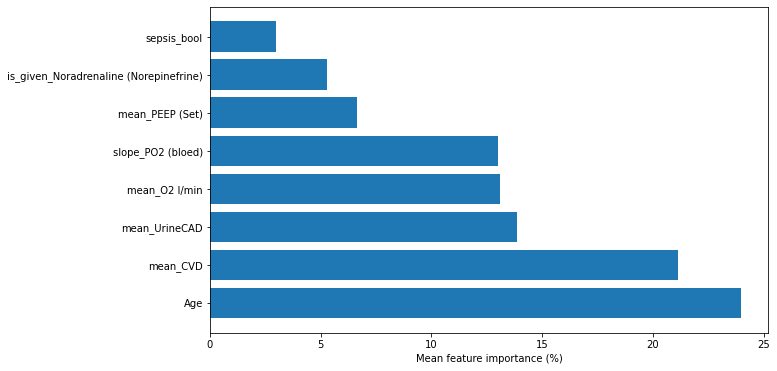

In [425]:
present=False

am_show_features = 60 if len(X_train.columns)>=30 else len(X_train.columns)
fi = CB_AF.feature_importances_
plt.figure(figsize=(10,6))
indices_T0 = np.argsort(fi)[::-1][0:am_show_features]
if present:
    plt.barh(range(am_show_features),fi[indices_T0],color="#e898ac")
else:
    plt.barh(range(am_show_features),fi[indices_T0])
plt.yticks(range(am_show_features), X_train.columns[indices_T0])
plt.xlabel("Mean feature importance (%)")
if present:
    ax = plt.gca()
    ax.patch.set_alpha(0)
#plt.tight_layout()
plt.show()

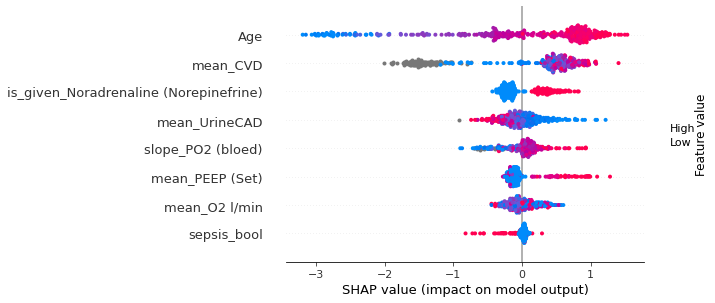

In [426]:
present=False

explainer = shap.TreeExplainer(CB_AF)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test,show=False)


## Combo validation 

In [10]:
validation_type_string = "combo"

### Data Import

In [14]:
if time_margin_model:
    if distr_change:
        AF_dataset_uzgent = pd.read_csv(data_save_path+"AF_dataset_1_5_hours_no_af_distribution_matched.csv") 
        AF_dataset_mimic = pd.read_csv(mimic_extracted_path+"AF_dataset_1_5_hours_no_af_distribution_matched.csv") 
        AF_dataset = pd.read_csv("Data/Extracted/AF_dataset_1_5_hours_no_af_distribution_matched.csv") 
    else:
        AF_dataset_uzgent = pd.read_csv(data_save_path+"AF_dataset_1_5_hours.csv")
        AF_dataset_mimic = pd.read_csv(mimic_extracted_path+"AF_dataset_1_5_hours.csv")
        AF_dataset = pd.read_csv("Data/Extracted/AF_dataset_1_5_hours.csv")
else:

    if distr_change:
        AF_dataset_uzgent = pd.read_csv(data_save_path+"AF_dataset_12_hours_no_af_distribution_matched.csv") 
        AF_dataset_mimic = pd.read_csv(mimic_extracted_path+"AF_dataset_12_hours_no_af_distribution_matched.csv") 
        AF_dataset = pd.read_csv("Data/Extracted/AF_dataset_12_hours_no_af_distribution_matched.csv") 
    else:
        AF_dataset_uzgent = pd.read_csv(data_save_path+"AF_dataset_12_hours.csv")
        AF_dataset_mimic = pd.read_csv(mimic_extracted_path+"AF_dataset_12_hours.csv")
        AF_dataset = pd.read_csv("Data/Extracted/AF_dataset_12_hours.csv")

if causal:
    if distr_change:
        AF_dataset_uzgent = pd.read_csv(data_save_path+"AF_dataset_6_hours_no_af_distribution_matched.csv") 
        AF_dataset_mimic = pd.read_csv(mimic_extracted_path+"AF_dataset_6_hours_no_af_distribution_matched.csv") 
        AF_dataset = pd.read_csv("Data/Extracted/AF_dataset_6_hours_no_af_distribution_matched.csv") 
    else:
        AF_dataset_uzgent = pd.read_csv(data_save_path+"AF_dataset_6_hours.csv")
        AF_dataset_mimic = pd.read_csv(mimic_extracted_path+"AF_dataset_6_hours.csv")
        AF_dataset = pd.read_csv("Data/Extracted/AF_dataset_6_hours.csv")

        
AF_dataset_uzgent = AF_dataset_uzgent.rename(columns={"HospAdmissionID":"patientid","AgeOnAdmission":"Age"})
AF_dataset_uzgent.loc[AF_dataset_uzgent.sepsis_extra_opn_measuredat > AF_dataset_uzgent.AF_measuredat,"sepsis_bool_extra_opn"]=0

df_patients = pd.read_csv(mimic_base_path+"core/csv/patients.csv",sep=',')
df_patients = df_patients.rename(columns={"subject_id":"patientid","anchor_age":"Age"})

AF_dataset_mimic = AF_dataset_mimic.merge(df_patients[['patientid','Age']],how='left',on='patientid')

In [15]:
AF_dataset_uzgent["is_given_NORepinefrine"]=0
AF_dataset_uzgent.loc[AF_dataset_uzgent['mean_CV_norepinephrine']>0,"is_given_NORepinefrine"]=1

#AF_dataset_uzgent["cardiac_surg_bool"]=0
#AF_dataset_uzgent.loc[(AF_dataset_uzgent["cardiac_bool"]==1)&(AF_dataset_uzgent["surgery_bool"]==1),"cardiac_surg_bool"] = 1

AF_dataset_uzgent["is_given_Calcium Glubionaat (Calcium Sandoz)"]=0
AF_dataset_uzgent.loc[(AF_dataset_uzgent["mean_VI_calcium carbonate"]>1)|(AF_dataset_uzgent["mean_VI_calcium chloride"]>1),"is_given_Calcium Glubionaat (Calcium Sandoz)"] = 1
    
AF_dataset_uzgent["is_given_Dopamine (Inotropin)"]=0
AF_dataset_uzgent.loc[AF_dataset_uzgent['mean_CV_dopamine']>0,"is_given_Dopamine (Inotropin)"]=1

#AF_dataset_uzgent['is_given_Magnesiumsulfaat (MgSO4)']=0
#AF_dataset_uzgent.loc[AF_dataset_uzgent['mean_Magnesium Sulfate']>0,'is_given_Magnesiumsulfaat (MgSO4)']=1

AF_dataset_uzgent['is_given_Propofol (Diprivan)']=0
AF_dataset_uzgent.loc[AF_dataset_uzgent['mean_NS_propofol']>0,'is_given_Propofol (Diprivan)']=1

AF_dataset_uzgent['is_given_Fentanyl']=0
AF_dataset_uzgent.loc[AF_dataset_uzgent['mean_NS_fentanyl']>0,'is_given_Fentanyl']=1

AF_dataset_uzgent["is_given_Furosemide (Lasix)"]=0
AF_dataset_uzgent.loc[AF_dataset_uzgent['mean_DI_furosemide']>0,"is_given_Furosemide (Lasix)"]=1

AF_dataset_uzgent["is_given_LoopDiuretics"]=0
AF_dataset_uzgent.loc[(AF_dataset_uzgent['mean_DI_furosemide']>0),"is_given_LoopDiuretics"]=1

AF_dataset_uzgent["sepsis_bool"]=0
AF_dataset_uzgent.loc[(AF_dataset_uzgent.sepsis_bool_comorb_source==1) | (AF_dataset_uzgent.sepsis_bool_extra_opn==1),"sepsis_bool"]=1


In [16]:
AF_dataset_mimic["is_given_NORepinefrine"]=0
AF_dataset_mimic.loc[AF_dataset_mimic['mean_NORepinephrine']>0,"is_given_NORepinefrine"]=1

AF_dataset_mimic["cardiac_surg_bool"]=0
AF_dataset_mimic.loc[(AF_dataset_mimic["cardiac_bool"]==1)&(AF_dataset_mimic["surgery_bool"]==1),"cardiac_surg_bool"] = 1

AF_dataset_mimic["is_given_Calcium Glubionaat (Calcium Sandoz)"]=0
if "mean_Calcium Carbonate Suspension" in AF_dataset.columns:
    AF_dataset_mimic.loc[(AF_dataset_mimic["mean_Calcium Carbonate"]>1)|(AF_dataset_mimic["mean_Calcium Gluconate"]>1)|(("mean_Calcium Carbonate Suspension" in AF_dataset_mimic.columns)&(AF_dataset_mimic["mean_Calcium Carbonate Suspension"]>1))|(AF_dataset_mimic["mean_Calcium Acetate"]>1),"is_given_Calcium Glubionaat (Calcium Sandoz)"] = 1
else:
    AF_dataset_mimic.loc[(AF_dataset_mimic["mean_Calcium Carbonate"]>1)|(AF_dataset_mimic["mean_Calcium Gluconate"]>1)|(AF_dataset_mimic["mean_Calcium Acetate"]>1),"is_given_Calcium Glubionaat (Calcium Sandoz)"] = 1
    
AF_dataset_mimic["is_given_Dopamine (Inotropin)"]=0
AF_dataset_mimic.loc[AF_dataset_mimic['mean_DOPamine']>0,"is_given_Dopamine (Inotropin)"]=1

AF_dataset_mimic[ 'is_given_Magnesiumsulfaat (MgSO4)']=0
AF_dataset_mimic.loc[AF_dataset_mimic['mean_Magnesium Sulfate']>0, 'is_given_Magnesiumsulfaat (MgSO4)']=1

AF_dataset_mimic['is_given_Propofol (Diprivan)']=0
AF_dataset_mimic.loc[AF_dataset_mimic['mean_Propofol']>0,'is_given_Propofol (Diprivan)']=1

AF_dataset_mimic['is_given_Fentanyl']=0
AF_dataset_mimic.loc[AF_dataset_mimic['mean_Fentanyl Citrate']>0,'is_given_Fentanyl']=1

AF_dataset_mimic["is_given_Furosemide (Lasix)"]=0
AF_dataset_mimic.loc[AF_dataset_mimic['mean_Furosemide']>0,"is_given_Furosemide (Lasix)"]=1

AF_dataset_mimic["is_given_LoopDiuretics"]=0
AF_dataset_mimic.loc[(AF_dataset_mimic['mean_Bumetanide']>0)|(AF_dataset_mimic['mean_Furosemide']>0),"is_given_LoopDiuretics"]=1

In [17]:
AF_dataset["is_given_Magnesiumsulfaat (MgSO4)"]=0
AF_dataset.loc[AF_dataset['mean_Magnesiumsulfaat (MgSO4)']>0,"is_given_Magnesiumsulfaat (MgSO4)"]=1
#AF_dataset["min_Magnesiumsulfaat (MgSO4)"] = AF_dataset["min_Magnesiumsulfaat (MgSO4)"].fillna(0)
AF_dataset["is_given_Calcium Glubionaat (Calcium Sandoz)"]=0
AF_dataset.loc[AF_dataset['mean_Calcium Glubionaat (Calcium Sandoz)']>0,"is_given_Calcium Glubionaat (Calcium Sandoz)"]=1

AF_dataset["is_given_LoopDiuretics"]=0
AF_dataset.loc[(AF_dataset['mean_Bumetanide (Burinex)']>0) | (AF_dataset['mean_Furosemide (Lasix)']>0),"is_given_LoopDiuretics"]=1

AF_dataset['is_given_Propofol (Diprivan)']=0
AF_dataset.loc[AF_dataset['mean_Propofol (Diprivan)']>0,'is_given_Propofol (Diprivan)']=1

AF_dataset['is_given_Dopamine (Inotropin)']=0
AF_dataset.loc[AF_dataset['mean_Dopamine (Inotropin)']>0,'is_given_Dopamine (Inotropin)']=1

In [18]:
#Rename for distr change 12 hour model
AF_dataset_uzgent = AF_dataset_uzgent.rename(columns={'mean_PEEP_M_ALL':'mean_PEEP (Set)', 'is_given_NORepinefrine':'is_given_Noradrenaline (Norepinefrine)', 'mean_URINE_VOL':'mean_UrineCAD', 
                           'min_NS_propofol':'min_Propofol (Diprivan)', 'min_NS_fentanyl':'min_Fentanyl', 'mean_RESPRATE_ALL':'mean_O2 l/min', #'cardiac_bool_new':'cardio_surgery_new',
                           'mean_PHOSPHATE_ALL':'mean_Fosfaat (bloed)', 'kurt_CVD':'kurt_CVD', 'max_HR_ALL':'max_Hartfrequentie', "max_PLATELETS":"max_Thrombo's (bloed)"})


#Rename for distr change 6 hour model
AF_dataset_uzgent = AF_dataset_uzgent.rename(columns={'max_RESPRATE_ALL':'max_O2 l/min', #'cardiac_bool_new':'cardio_surgery_new',
                                        'min_PHOSPHATE_ALL':'min_Fosfaat (bloed)', 'mean_CVD':'mean_CVD', 'mean_SAO2_ALL':'mean_O2-Saturatie (bloed)',
                                        "min_PLATELETS":"min_Thrombo's (bloed)"})

#Rename for distr change 1.5 hour model
AF_dataset_uzgent = AF_dataset_uzgent.rename(columns={'max_UREA_ALL':'max_Ureum (bloed)'})

#Rename for standard 12 hour model
AF_dataset_uzgent = AF_dataset_uzgent.rename(columns={"slope_PO2_ART":'slope_PO2 (bloed)'})

#Rename for standard 1.5 hour model
AF_dataset_uzgent = AF_dataset_uzgent.rename(columns={ 'min_RESPRATE_ALL':'min_O2 l/min', "mean_PLATELETS":"mean_Thrombo's (bloed)",
                                        'min_CVD':'min_CVD'})

In [19]:
#Rename for distr change 12 hour model
AF_dataset_mimic = AF_dataset_mimic.rename(columns={'mean_PEEP set':'mean_PEEP (Set)', 'is_given_NORepinefrine':'is_given_Noradrenaline (Norepinefrine)', 'mean_Foley':'mean_UrineCAD', 
                           'min_Propofol':'min_Propofol (Diprivan)', 'min_Fentanyl Citrate':'min_Fentanyl', 'mean_O2 Flow':'mean_O2 l/min', 'cardiac_bool_new':'cardio_surgery_new',
                           'mean_Phosphate':'mean_Fosfaat (bloed)', 'kurt_Central Venous Pressure':'kurt_CVD', 'max_Heart Rate':'max_Hartfrequentie', "max_Platelet Count":"max_Thrombo's (bloed)"})

#Rename for distr change 6 hour model
AF_dataset_mimic = AF_dataset_mimic.rename(columns={'mean_PEEP set':'mean_PEEP (Set)', 'is_given_NORepinefrine':'is_given_Noradrenaline (Norepinefrine)', 'max_O2 Flow':'max_O2 l/min', 
                                                    'cardiac_bool_new':'cardio_surgery_new','min_Phosphate':'min_Fosfaat (bloed)', 
                                                    'mean_Central Venous Pressure':'mean_CVD', 'max_Heart Rate':'max_Hartfrequentie', "min_Platelet Count":"min_Thrombo's (bloed)"})

#Rename for distr change 1.5 hour model
AF_dataset_mimic = AF_dataset_mimic.rename(columns={ 'max_O2 Flow':'max_O2 l/min','min_Phosphate':'min_Fosfaat (bloed)','max_Urea Nitrogen':'max_Ureum (bloed)',
                                                    'mean_Central Venous Pressure':'mean_CVD'})

#Rename for standard 12 hour model
AF_dataset_mimic = AF_dataset_mimic.rename(columns={"mean_Hemoglobin":"mean_Hb (bloed)","slope_pO2":'slope_PO2 (bloed)'})

#Rename for standard 1.5 hour model
AF_dataset_mimic = AF_dataset_mimic.rename(columns={ 'min_O2 Flow':'min_O2 l/min', "mean_Platelet Count":"mean_Thrombo's (bloed)","mean_PTT":"mean_APTT  (bloed)",
                                        'min_Central Venous Pressure':'min_CVD',"min_C-Reactive Protein":"min_CRP (bloed)"})

In [20]:
#AF_temp_db_uzgent = AF_dataset_uzgent[(AF_dataset_uzgent.AF==0)&(AF_dataset_uzgent.AF_orig==0)].sample(len(AF_dataset_uzgent[AF_dataset_uzgent.AF==1]),random_state=42).reset_index(drop=True)
AF_temp_db_uzgent = AF_dataset_uzgent[(AF_dataset_uzgent.AF==0)&(AF_dataset_uzgent.AF_orig==0)&(AF_dataset_uzgent.patientid!=AF_dataset_uzgent.date_corresponds_to_AF_admid)]

if distr_change:
    AF_temp_db = AF_dataset[(AF_dataset.AF==0)&(AF_dataset.AF_orig==0)&(AF_dataset.patientid!=AF_dataset.date_corresponds_to_AF_admid)]
    AF_temp_db_mimic = AF_dataset_mimic[(AF_dataset_mimic.AF==0)&(AF_dataset_mimic.AF_orig==0)&(AF_dataset_mimic.patientid!=AF_dataset_mimic.date_corresponds_to_AF_admid)]
else:
    AF_temp_db_mimic = AF_dataset_mimic[(AF_dataset_mimic.AF==0)&(AF_dataset_mimic.AF_orig==0)].sample(len(AF_dataset_mimic[AF_dataset_mimic.AF==1]),random_state=42).reset_index(drop=True)
    AF_temp_db = AF_dataset[(AF_dataset.AF==0)&(AF_dataset.AF_orig==0)].sample(len(AF_dataset[AF_dataset.AF==1]),random_state=42).reset_index(drop=True)

AF_NOW_uzgent = pd.concat([AF_temp_db_uzgent,AF_dataset_uzgent[AF_dataset_uzgent.AF==1]]).reset_index(drop=True)
AF_NOW_mimic = AF_temp_db_mimic.append(AF_dataset_mimic[AF_dataset_mimic.AF==1]).reset_index(drop=True)
AF_NOW = pd.concat([AF_temp_db,AF_dataset[AF_dataset.AF==1]]).reset_index(drop=True)

In [21]:
from sklearn.model_selection import train_test_split

train_patientid_uzgent,test_patientid_uzgent = train_test_split(AF_NOW_uzgent.patientid.unique(), test_size=0.2, random_state=42)
train_patientid_mimic,test_patientid_mimic = train_test_split(AF_NOW_mimic.patientid.unique(), test_size=0.2, random_state=42)
train_patientid,test_patientid = train_test_split(AF_NOW.patientid.unique(), test_size=0.2, random_state=42)

train_AF_dataset = AF_NOW[AF_NOW.patientid.isin(train_patientid)]
train_AF_dataset_uzgent = AF_NOW_uzgent[AF_NOW_uzgent.patientid.isin(train_patientid_uzgent)]
train_AF_dataset_mimic = AF_NOW_mimic[AF_NOW_mimic.patientid.isin(train_patientid_mimic)]

test_AF_dataset = AF_NOW[AF_NOW.patientid.isin(test_patientid)]
test_AF_dataset_uzgent = AF_NOW_uzgent[AF_NOW_uzgent.patientid.isin(test_patientid_uzgent)]
test_AF_dataset_mimic = AF_NOW_mimic[AF_NOW_mimic.patientid.isin(test_patientid_mimic)]

In [22]:
uzgent_drop_columns = ['patientid', 'hadm_id', 'admittime', 'AF_measuredat', 'intime',
       'outtime', 'admissionid', 'lengthofstay']

drop_columns = ["dateofdeath_delta","admittedat_delta","admissionid","origin",
                "lengthofstay","destination","weightgroup","agegroup","dateofdeath",
                "admittedat","heightgroup","specialty","dateofdeath_delta","admittedat_delta","weightsource","dischargedat","heightsource",
                "gender","Mortality","AF_orig","AF_measuredat","AF","new_onset_AF","Preadmission_AF","patientid","location","admissionyeargroup"]

if distr_change:
    uzgent_drop_columns.append('date_corresponds_to_AF_admid')
    drop_columns.append('date_corresponds_to_AF_admid')

In [23]:
X_train_or_amst = train_AF_dataset[(train_AF_dataset.AF==1)|((train_AF_dataset.AF_orig==0)&(train_AF_dataset.AF==0))]#[train_AF_dataset.columns.drop(drop_columns)]
X_test_or_amst = test_AF_dataset[(test_AF_dataset.AF==1)|((test_AF_dataset.AF_orig==0)&(test_AF_dataset.AF==0))]#[test_AF_dataset.columns.drop(uzgent_drop_columns)]
y_train_amst = train_AF_dataset[(train_AF_dataset.AF==1)|((train_AF_dataset.AF_orig==0)&(train_AF_dataset.AF==0))].AF
y_test_amst = test_AF_dataset[(test_AF_dataset.AF==1)|((test_AF_dataset.AF_orig==0)&(test_AF_dataset.AF==0))].AF

X_train_or_uzgent = train_AF_dataset_uzgent[(train_AF_dataset_uzgent.AF==1)|((train_AF_dataset_uzgent.AF_orig==0)&(train_AF_dataset_uzgent.AF==0))]
X_test_or_uzgent = test_AF_dataset_uzgent[(test_AF_dataset_uzgent.AF==1)|((test_AF_dataset_uzgent.AF_orig==0)&(test_AF_dataset_uzgent.AF==0))]
y_train_uzgent = train_AF_dataset_uzgent[(train_AF_dataset_uzgent.AF==1)|((train_AF_dataset_uzgent.AF_orig==0)&(train_AF_dataset_uzgent.AF==0))].AF
y_test_uzgent = test_AF_dataset_uzgent[(test_AF_dataset_uzgent.AF==1)|((test_AF_dataset_uzgent.AF_orig==0)&(test_AF_dataset_uzgent.AF==0))].AF

X_train_or_mimic = train_AF_dataset_mimic[(train_AF_dataset_mimic.AF==1)|((train_AF_dataset_mimic.AF_orig==0)&(train_AF_dataset_mimic.AF==0))]
X_test_or_mimic = test_AF_dataset_mimic[(test_AF_dataset_mimic.AF==1)|((test_AF_dataset_mimic.AF_orig==0)&(test_AF_dataset_mimic.AF==0))]
y_train_mimic = train_AF_dataset_mimic[(train_AF_dataset_mimic.AF==1)|((train_AF_dataset_mimic.AF_orig==0)&(train_AF_dataset_mimic.AF==0))].AF
y_test_mimic = test_AF_dataset_mimic[(test_AF_dataset_mimic.AF==1)|((test_AF_dataset_mimic.AF_orig==0)&(test_AF_dataset_mimic.AF==0))].AF

### Testing

In [49]:
if time_margin_model:
    if not distr_change:
        feature_columns = ['Age', 'min_O2 l/min',  'max_Hartfrequentie','is_given_Calcium Glubionaat (Calcium Sandoz)',# 'mean_APTT  (bloed)','is_given_Magnesiumsulfaat (MgSO4)','cardio_surgery_new','min_CRP (bloed)',
         'mean_PEEP (Set)', "mean_Thrombo's (bloed)", 'min_CVD',   'is_given_LoopDiuretics',]
    
    else:
        feature_columns = ['Age', 'mean_O2 l/min', 'max_Hartfrequentie', 'mean_PEEP (Set)', 'is_given_Noradrenaline (Norepinefrine)', 'max_Ureum (bloed)', #'cardiac_surg_bool',
          'is_given_Furosemide (Lasix)', 'is_given_Dopamine (Inotropin)', "max_Thrombo's (bloed)"] 

else:
    if not distr_change:
        feature_columns=['Age', 'slope_PO2 (bloed)', 'is_given_Noradrenaline (Norepinefrine)', #'is_given_Magnesiumsulfaat (MgSO4)',#'min_Magnesiumsulfaat (MgSO4)', 
                           'mean_PEEP (Set)',#'fluidin','mean_Hb (bloed)', 'fluidout',  'admissioncount', 
                           'mean_O2 l/min','mean_UrineCAD',  'sepsis_bool', 'mean_CVD']
    else:
        feature_columns = ['Age', 'mean_PEEP (Set)', 'is_given_Noradrenaline (Norepinefrine)', 'mean_UrineCAD', 
                           'is_given_Propofol (Diprivan)', 'is_given_Fentanyl', 'mean_O2 l/min', #'fluidout', #'cardiac_surg_bool',
                           'mean_Fosfaat (bloed)', 'kurt_CVD', 'max_Hartfrequentie', "max_Thrombo's (bloed)"]

if causal:
    if not distr_change:
        feature_columns=['Age', 'slope_PO2 (bloed)', 'is_given_Noradrenaline (Norepinefrine)', #'is_given_Magnesiumsulfaat (MgSO4)',#'min_Magnesiumsulfaat (MgSO4)', 
                           'mean_PEEP (Set)',#'mean_Hb (bloed)','fluidout', 'fluidin', 'admissioncount',
                           'mean_O2 l/min',  'mean_UrineCAD',  'sepsis_bool', 'mean_CVD']
    else:
        feature_columns = ['Age', 'max_O2 l/min', 'min_Fosfaat (bloed)', 'mean_PEEP (Set)', 'is_given_Noradrenaline (Norepinefrine)',
                       'is_given_Calcium Glubionaat (Calcium Sandoz)', 'max_Hartfrequentie', #'fluidout',
                       "min_Thrombo's (bloed)",  'mean_CVD']
        
X_train_amst=X_train_or_amst[feature_columns]    
X_test_amst=X_test_or_amst[feature_columns]   
X_train_uzgent=X_train_or_uzgent[feature_columns]        
X_test_uzgent=X_test_or_uzgent[feature_columns]  

X_test_mimic=X_test_or_mimic[feature_columns]  
X_train_mimic=X_train_or_mimic[feature_columns]

X_train = X_train_amst.append(X_train_uzgent).reset_index(drop=True).sample(len(X_train_amst)+len(X_train_uzgent),random_state=42)
y_train = np.append(y_train_amst,y_train_uzgent)[X_train.index.values]

# X_train = X_train_amst.append(X_train_mimic).reset_index(drop=True).sample(len(X_train_amst)+len(X_train_mimic),random_state=42)
# y_train = np.append(y_train_amst,y_train_mimic)[X_train.index.values]

# X_train = X_train_mimic.append(X_train_uzgent).reset_index(drop=True).sample(len(X_train_mimic)+len(X_train_uzgent),random_state=42)
# y_train = np.append(y_train_mimic,y_train_uzgent)[X_train.index.values]


In [50]:
X_test_uzgent_all = AF_dataset_uzgent[((AF_dataset_uzgent.AF==0)&(~AF_dataset_uzgent.patientid.isin(AF_NOW_uzgent.patientid)))|(AF_dataset_uzgent.patientid.isin(test_patientid_uzgent))][feature_columns]
X_test_mimic_all = AF_dataset_mimic[((AF_dataset_mimic.AF==0)&(~AF_dataset_mimic.patientid.isin(AF_NOW_mimic.patientid)))|(AF_dataset_mimic.patientid.isin(test_patientid_mimic))][feature_columns]
X_test_amst_all = AF_dataset[((AF_dataset.AF==0)&(~AF_dataset.patientid.isin(AF_NOW.patientid)))|(AF_dataset.patientid.isin(test_patientid))][feature_columns]


In [51]:
AF_class_balance = [y_train.sum()/len(y_train),1-y_train.sum()/len(y_train)]
if distr_change:
    CB_AF = CatBoostClassifier(verbose=100,iterations=250,l2_leaf_reg= 1,class_weights=AF_class_balance)
else:
    CB_AF = CatBoostClassifier(verbose=100,iterations=250)#,l2_leaf_reg= 1)
CB_AF.fit(X_train,y_train)

0:	learn: 0.6844708	total: 5.11ms	remaining: 1.27s
100:	learn: 0.5087722	total: 387ms	remaining: 571ms
200:	learn: 0.4817239	total: 785ms	remaining: 191ms
249:	learn: 0.4713335	total: 996ms	remaining: 0us


In [52]:
print(classification_report(y_train,CB_AF.predict(X_train),target_names=["No-AF","AF"]))

              precision    recall  f1-score   support

       No-AF       0.78      0.77      0.77      2263
          AF       0.78      0.79      0.78      2305

    accuracy                           0.78      4568
   macro avg       0.78      0.78      0.78      4568
weighted avg       0.78      0.78      0.78      4568



In [53]:
print("BALANCED TEST MIMIC PATIENTS")
print(classification_report(y_test_mimic,CB_AF.predict(X_test_mimic),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_mimic,label=y_test_mimic), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_mimic,CB_AF.predict(X_test_mimic)),4)))
print(50*"=")

BALANCED TEST MIMIC PATIENTS
              precision    recall  f1-score   support

       No-AF       0.66      0.74      0.70      1080
          AF       0.70      0.61      0.65      1045

    accuracy                           0.68      2125
   macro avg       0.68      0.68      0.68      2125
weighted avg       0.68      0.68      0.68      2125



AUC = 0.7558
MCC = 0.3575


In [54]:
print("BALANCED TEST AMSTERDAM PATIENTS")
print(classification_report(y_test_amst,CB_AF.predict(X_test_amst),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_amst,label=y_test_amst), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_amst,CB_AF.predict(X_test_amst)),4)))
print(50*"=")

BALANCED TEST AMSTERDAM PATIENTS
              precision    recall  f1-score   support

       No-AF       0.76      0.70      0.73       396
          AF       0.69      0.75      0.72       349

    accuracy                           0.72       745
   macro avg       0.72      0.72      0.72       745
weighted avg       0.73      0.72      0.72       745



AUC = 0.7921
MCC = 0.449


In [55]:
print("BALANCED TEST UZGENT PATIENTS")
print(classification_report(y_test_uzgent,CB_AF.predict(X_test_uzgent),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_uzgent,label=y_test_uzgent), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_uzgent,CB_AF.predict(X_test_uzgent)),4)))
print(50*"=")

BALANCED TEST UZGENT PATIENTS
              precision    recall  f1-score   support

       No-AF       0.71      0.73      0.72       195
          AF       0.74      0.72      0.73       205

    accuracy                           0.73       400
   macro avg       0.72      0.73      0.72       400
weighted avg       0.73      0.72      0.73       400



AUC = 0.8102
MCC = 0.45


In [441]:
combo_uzgent_y_test = y_test_uzgent
combo_uzgent_predict = CB_AF.predict(X_test_uzgent)
combo_amst_y_test = y_test_amst
combo_amst_predict = CB_AF.predict(X_test_amst)

In [442]:
temp_large_db = AF_dataset_uzgent[((AF_dataset_uzgent.AF==0)&(~AF_dataset_uzgent.patientid.isin(AF_NOW_uzgent.patientid)))|(AF_dataset_uzgent.patientid.isin(test_patientid_uzgent))]

"""print("CARDIAC SURGERY NEW PATIENTS")
X_test_card = temp_large_db[((temp_large_db.AF==1)|((temp_large_db.AF_orig==0)&(temp_large_db.AF==0)))&(temp_large_db.cardio_surgery_new==1)][feature_columns]
y_test_card = temp_large_db[((temp_large_db.AF==1)|((temp_large_db.AF_orig==0)&(temp_large_db.AF==0)))&(temp_large_db.cardio_surgery_new==1)].AF
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_card,label=y_test_card), plot=False)
print(classification_report(y_test_card,CB_AF.predict(X_test_card),target_names=["No-AF","AF"]))
print("\n") 
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_card,CB_AF.predict(X_test_card)),4)))
print(50*"=")

print("CARDIAC SURGERY NEW PATIENTS Balanced")
NO_AF_pat_len = len(test_AF_dataset[((test_AF_dataset.AF_orig==0)&(test_AF_dataset.AF==0))&(test_AF_dataset.cardio_surgery_new==1)])
AF_pat_len = len(test_AF_dataset[(test_AF_dataset.AF==1)&(test_AF_dataset.cardio_surgery_new==1)])
if AF_pat_len > NO_AF_pat_len:
    card_af_db = test_AF_dataset[((test_AF_dataset.AF==1)
                                            |((test_AF_dataset.AF_orig==0)&(test_AF_dataset.AF==0)))&(test_AF_dataset.cardio_surgery_new==1)].append(temp_large_db[((temp_large_db.AF_orig==0)&(temp_large_db.AF==0))&(temp_large_db.cardio_surgery_new==1)
                                          &(~temp_large_db.patientid.isin(test_AF_dataset.patientid))].sample(AF_pat_len-NO_AF_pat_len))
else:
    card_af_db = test_AF_dataset[(test_AF_dataset.AF==1)&(test_AF_dataset.cardio_surgery_new==1)].append(test_AF_dataset[((test_AF_dataset.AF_orig==0)&(test_AF_dataset.AF==0))&(test_AF_dataset.cardio_surgery_new==1)].sample(AF_pat_len))
                       
X_test_card = card_af_db[feature_columns]
y_test_card = card_af_db.AF
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_card,label=y_test_card), plot=False)
print(classification_report(y_test_card,CB_AF.predict(X_test_card),target_names=["No-AF","AF"]))
print("\n")
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_card,CB_AF.predict(X_test_card)),4)))
print(50*"=")"""

print("SEPSIS PATIENTS")
X_test_sepsis = temp_large_db[((temp_large_db.AF==1)|((temp_large_db.AF_orig==0)&(temp_large_db.AF==0)))&(temp_large_db.sepsis_bool==1)][feature_columns]
y_test_sepsis = temp_large_db[((temp_large_db.AF==1)|((temp_large_db.AF_orig==0)&(temp_large_db.AF==0)))&(temp_large_db.sepsis_bool==1)].AF
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_sepsis,label=y_test_sepsis), plot=False)
print(classification_report(y_test_sepsis,CB_AF.predict(X_test_sepsis),target_names=["No-AF","AF"]))
print("\n")
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_sepsis,CB_AF.predict(X_test_sepsis)),4)))
print(50*"=")


uzgent_result_dataframe = pandas_result_AF_maker("sepsis uzgent",X_test_sepsis,y_test_sepsis,CB_AF,uzgent_result_dataframe)

print("SEPSIS PATIENTS Balanced")
NO_AF_pat_len = len(test_AF_dataset[((test_AF_dataset.AF_orig==0)&(test_AF_dataset.AF==0))&(test_AF_dataset.sepsis_bool==1)])
AF_pat_len = len(test_AF_dataset[(test_AF_dataset.AF==1)&(test_AF_dataset.sepsis_bool==1)])
if AF_pat_len > NO_AF_pat_len:
    sepsis_af_db = test_AF_dataset[((test_AF_dataset.AF==1)
                                            |((test_AF_dataset.AF_orig==0)&(test_AF_dataset.AF==0)))&(test_AF_dataset.sepsis_bool==1)].append(temp_large_db[((temp_large_db.AF_orig==0)&(temp_large_db.AF==0))&(temp_large_db.sepsis_bool==1)
                                          &(~temp_large_db.patientid.isin(test_AF_dataset.patientid))].sample(AF_pat_len-NO_AF_pat_len))
else:
    sepsis_af_db = test_AF_dataset[(test_AF_dataset.AF==1)&(test_AF_dataset.sepsis_bool==1)].append(test_AF_dataset[((test_AF_dataset.AF_orig==0)&(test_AF_dataset.AF==0))&(test_AF_dataset.sepsis_bool==1)].sample(AF_pat_len))
                 


X_test_sepsis = sepsis_af_db[feature_columns]
y_test_sepsis = sepsis_af_db.AF
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_sepsis,label=y_test_sepsis), plot=False)
print(classification_report(y_test_sepsis,CB_AF.predict(X_test_sepsis),target_names=["No-AF","AF"]))
print("\n")
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_sepsis,CB_AF.predict(X_test_sepsis)),4)))
print(50*"=")


uzgent_result_dataframe = pandas_result_AF_maker("sepsis balanced uzgent",X_test_sepsis,y_test_sepsis,CB_AF,uzgent_result_dataframe)

y_test_all_pat = temp_large_db[(temp_large_db.AF==1)|((temp_large_db.AF_orig==0)&(temp_large_db.AF==0))].AF
X_test_all_pat = temp_large_db[(temp_large_db.AF==1)|((temp_large_db.AF_orig==0)&(temp_large_db.AF==0))][feature_columns]


print("ALL PATIENTS")
print(classification_report(y_test_all_pat,CB_AF.predict(X_test_all_pat),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_all_pat,label=y_test_all_pat), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_all_pat,CB_AF.predict(X_test_all_pat)),4)))
print(50*"=")


uzgent_result_dataframe = pandas_result_AF_maker("all patients uzgent",X_test_all_pat,y_test_all_pat,CB_AF,uzgent_result_dataframe)

print("BALANCED TEST PATIENTS")
print(classification_report(y_test_uzgent,CB_AF.predict(X_test_uzgent),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_uzgent,label=y_test_uzgent), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_uzgent,CB_AF.predict(X_test_uzgent)),4)))
print(50*"=")


uzgent_result_dataframe = pandas_result_AF_maker("balanced test uzgent",X_test_uzgent,y_test_uzgent,CB_AF,uzgent_result_dataframe)

SEPSIS PATIENTS
              precision    recall  f1-score   support

       No-AF       0.99      0.77      0.87      2114
          AF       0.02      0.46      0.04        24

    accuracy                           0.77      2138
   macro avg       0.51      0.62      0.46      2138
weighted avg       0.98      0.77      0.86      2138



AUC = 0.6832
MCC = 0.0586
SEPSIS PATIENTS Balanced
              precision    recall  f1-score   support

       No-AF       0.77      0.62      0.69        87
          AF       0.68      0.82      0.74        87

    accuracy                           0.72       174
   macro avg       0.73      0.72      0.72       174
weighted avg       0.73      0.72      0.72       174



AUC = 0.8071
MCC = 0.4454
ALL PATIENTS
              precision    recall  f1-score   support

       No-AF       1.00      0.69      0.81     15759
          AF       0.03      0.77      0.06       197

    accuracy                           0.69     15956
   macro avg      

In [443]:
temp_large_db = AF_dataset[((AF_dataset.AF==0)&(~AF_dataset.patientid.isin(AF_NOW.patientid)))|(AF_dataset.patientid.isin(test_patientid))]

"""print("CARDIAC SURGERY NEW PATIENTS")
X_test_card = temp_large_db[((temp_large_db.AF==1)|((temp_large_db.AF_orig==0)&(temp_large_db.AF==0)))&(temp_large_db.cardio_surgery_new==1)][feature_columns]
y_test_card = temp_large_db[((temp_large_db.AF==1)|((temp_large_db.AF_orig==0)&(temp_large_db.AF==0)))&(temp_large_db.cardio_surgery_new==1)].AF
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_card,label=y_test_card), plot=False)
print(classification_report(y_test_card,CB_AF.predict(X_test_card),target_names=["No-AF","AF"]))
print("\n") 
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_card,CB_AF.predict(X_test_card)),4)))
print(50*"=")

print("CARDIAC SURGERY NEW PATIENTS Balanced")
NO_AF_pat_len = len(test_AF_dataset[((test_AF_dataset.AF_orig==0)&(test_AF_dataset.AF==0))&(test_AF_dataset.cardio_surgery_new==1)])
AF_pat_len = len(test_AF_dataset[(test_AF_dataset.AF==1)&(test_AF_dataset.cardio_surgery_new==1)])
if AF_pat_len > NO_AF_pat_len:
    card_af_db = test_AF_dataset[((test_AF_dataset.AF==1)
                                            |((test_AF_dataset.AF_orig==0)&(test_AF_dataset.AF==0)))&(test_AF_dataset.cardio_surgery_new==1)].append(temp_large_db[((temp_large_db.AF_orig==0)&(temp_large_db.AF==0))&(temp_large_db.cardio_surgery_new==1)
                                          &(~temp_large_db.patientid.isin(test_AF_dataset.patientid))].sample(AF_pat_len-NO_AF_pat_len))
else:
    card_af_db = test_AF_dataset[(test_AF_dataset.AF==1)&(test_AF_dataset.cardio_surgery_new==1)].append(test_AF_dataset[((test_AF_dataset.AF_orig==0)&(test_AF_dataset.AF==0))&(test_AF_dataset.cardio_surgery_new==1)].sample(AF_pat_len))
                       
X_test_card = card_af_db[feature_columns]
y_test_card = card_af_db.AF
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_card,label=y_test_card), plot=False)
print(classification_report(y_test_card,CB_AF.predict(X_test_card),target_names=["No-AF","AF"]))
print("\n")
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_card,CB_AF.predict(X_test_card)),4)))
print(50*"=")"""

print("SEPSIS PATIENTS")
X_test_sepsis = temp_large_db[((temp_large_db.AF==1)|((temp_large_db.AF_orig==0)&(temp_large_db.AF==0)))&(temp_large_db.sepsis_bool==1)][feature_columns]
y_test_sepsis = temp_large_db[((temp_large_db.AF==1)|((temp_large_db.AF_orig==0)&(temp_large_db.AF==0)))&(temp_large_db.sepsis_bool==1)].AF
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_sepsis,label=y_test_sepsis), plot=False)
print(classification_report(y_test_sepsis,CB_AF.predict(X_test_sepsis),target_names=["No-AF","AF"]))
print("\n")
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_sepsis,CB_AF.predict(X_test_sepsis)),4)))
print(50*"=")

uzgent_result_dataframe = pandas_result_AF_maker("sepsis amsterdam",X_test_sepsis,y_test_sepsis,CB_AF,uzgent_result_dataframe)

print("SEPSIS PATIENTS Balanced")
NO_AF_pat_len = len(test_AF_dataset[((test_AF_dataset.AF_orig==0)&(test_AF_dataset.AF==0))&(test_AF_dataset.sepsis_bool==1)])
AF_pat_len = len(test_AF_dataset[(test_AF_dataset.AF==1)&(test_AF_dataset.sepsis_bool==1)])
if AF_pat_len > NO_AF_pat_len:
    sepsis_af_db = test_AF_dataset[((test_AF_dataset.AF==1)
                                            |((test_AF_dataset.AF_orig==0)&(test_AF_dataset.AF==0)))&(test_AF_dataset.sepsis_bool==1)].append(temp_large_db[((temp_large_db.AF_orig==0)&(temp_large_db.AF==0))&(temp_large_db.sepsis_bool==1)
                                          &(~temp_large_db.patientid.isin(test_AF_dataset.patientid))].sample(AF_pat_len-NO_AF_pat_len))
else:
    sepsis_af_db = test_AF_dataset[(test_AF_dataset.AF==1)&(test_AF_dataset.sepsis_bool==1)].append(test_AF_dataset[((test_AF_dataset.AF_orig==0)&(test_AF_dataset.AF==0))&(test_AF_dataset.sepsis_bool==1)].sample(AF_pat_len))
                 


X_test_sepsis = sepsis_af_db[feature_columns]
y_test_sepsis = sepsis_af_db.AF
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_sepsis,label=y_test_sepsis), plot=False)
print(classification_report(y_test_sepsis,CB_AF.predict(X_test_sepsis),target_names=["No-AF","AF"]))
print("\n")
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_sepsis,CB_AF.predict(X_test_sepsis)),4)))
print(50*"=")

uzgent_result_dataframe = pandas_result_AF_maker("sepsis balanced amsterdam",X_test_sepsis,y_test_sepsis,CB_AF,uzgent_result_dataframe)


y_test_all_pat = temp_large_db[(temp_large_db.AF==1)|((temp_large_db.AF_orig==0)&(temp_large_db.AF==0))].AF
X_test_all_pat = temp_large_db[(temp_large_db.AF==1)|((temp_large_db.AF_orig==0)&(temp_large_db.AF==0))][feature_columns]



print("ALL PATIENTS")
print(classification_report(y_test_all_pat,CB_AF.predict(X_test_all_pat),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_all_pat,label=y_test_all_pat), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_all_pat,CB_AF.predict(X_test_all_pat)),4)))
print(50*"=")

uzgent_result_dataframe = pandas_result_AF_maker("all patients amsterdam",X_test_all_pat,y_test_all_pat,CB_AF,uzgent_result_dataframe)

print("BALANCED TEST PATIENTS")
print(classification_report(y_test_amst,CB_AF.predict(X_test_amst),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_amst,label=y_test_amst), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_amst,CB_AF.predict(X_test_amst)),4)))
print(50*"=")

uzgent_result_dataframe = pandas_result_AF_maker("balanced test amsterdam",X_test_amst,y_test_amst,CB_AF,uzgent_result_dataframe)

SEPSIS PATIENTS
              precision    recall  f1-score   support

       No-AF       0.98      0.48      0.64      1700
          AF       0.07      0.82      0.14        87

    accuracy                           0.49      1787
   macro avg       0.53      0.65      0.39      1787
weighted avg       0.94      0.49      0.62      1787



AUC = 0.7144
MCC = 0.1268
SEPSIS PATIENTS Balanced
              precision    recall  f1-score   support

       No-AF       0.76      0.57      0.65        87
          AF       0.66      0.82      0.73        87

    accuracy                           0.70       174
   macro avg       0.71      0.70      0.69       174
weighted avg       0.71      0.70      0.69       174



AUC = 0.7745
MCC = 0.4027
ALL PATIENTS
              precision    recall  f1-score   support

       No-AF       0.99      0.75      0.85     14988
          AF       0.06      0.70      0.11       341

    accuracy                           0.74     15329
   macro avg      

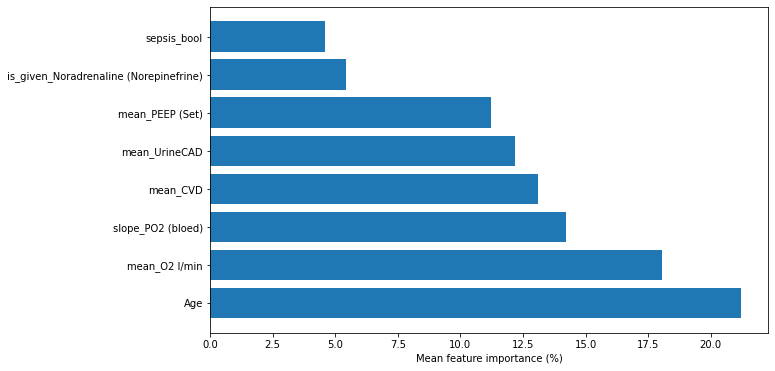

In [444]:
present=False

am_show_features = 60 if len(X_train.columns)>=30 else len(X_train.columns)
fi = CB_AF.feature_importances_
plt.figure(figsize=(10,6))
indices_T0 = np.argsort(fi)[::-1][0:am_show_features]
if present:
    plt.barh(range(am_show_features),fi[indices_T0],color="#e898ac")
else:
    plt.barh(range(am_show_features),fi[indices_T0])
plt.yticks(range(am_show_features), X_train.columns[indices_T0])
plt.xlabel("Mean feature importance (%)")
if present:
    ax = plt.gca()
    ax.patch.set_alpha(0)
#plt.tight_layout()
plt.show()

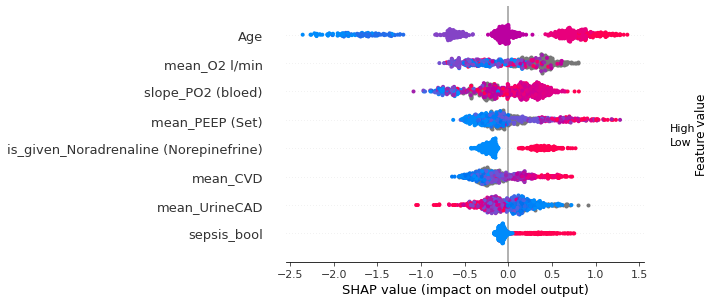

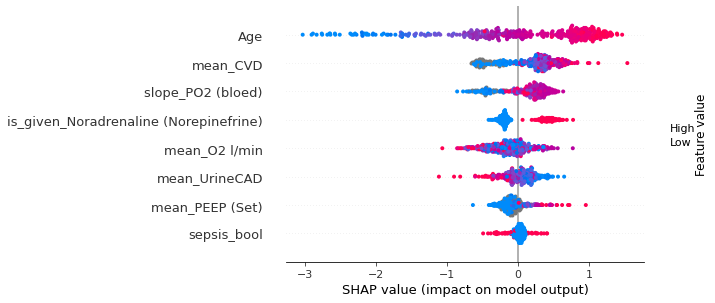

In [445]:
present=False

plt.figure()
explainer = shap.TreeExplainer(CB_AF)
shap_values = explainer.shap_values(X_test_amst)
shap.summary_plot(shap_values, X_test_amst,show=False)
plt.plot()
plt.figure()
explainer = shap.TreeExplainer(CB_AF)
shap_values = explainer.shap_values(X_test_uzgent)
shap.summary_plot(shap_values, X_test_uzgent,show=False)

## Direct validation

In [446]:
validation_type_string = "direct"

### Data Import

In [447]:
if time_margin_model:
    if distr_change:
        AF_dataset_uzgent = pd.read_csv(data_save_path+"AF_dataset_1_5_hours_no_af_distribution_matched.csv") 
        AF_dataset = pd.read_csv("Data/Extracted/AF_dataset_1_5_hours_no_af_distribution_matched.csv") 
    else:
        AF_dataset_uzgent = pd.read_csv(data_save_path+"AF_dataset_1_5_hours.csv")
        AF_dataset = pd.read_csv("Data/Extracted/AF_dataset_1_5_hours.csv")
else:

    if distr_change:
        AF_dataset_uzgent = pd.read_csv(data_save_path+"AF_dataset_12_hours_no_af_distribution_matched.csv") 
        AF_dataset = pd.read_csv("Data/Extracted/AF_dataset_12_hours_no_af_distribution_matched.csv") 
    else:
        AF_dataset_uzgent = pd.read_csv(data_save_path+"AF_dataset_12_hours.csv")
        AF_dataset = pd.read_csv("Data/Extracted/AF_dataset_12_hours.csv")

if causal:
    if distr_change:
        AF_dataset_uzgent = pd.read_csv(data_save_path+"AF_dataset_6_hours_no_af_distribution_matched.csv") 
        AF_dataset = pd.read_csv("Data/Extracted/AF_dataset_6_hours_no_af_distribution_matched.csv") 
    else:
        AF_dataset_uzgent = pd.read_csv(data_save_path+"AF_dataset_6_hours.csv")
        AF_dataset = pd.read_csv("Data/Extracted/AF_dataset_6_hours.csv")

        
AF_dataset_uzgent = AF_dataset_uzgent.rename(columns={"HospAdmissionID":"patientid","AgeOnAdmission":"Age"})
AF_dataset_uzgent.loc[AF_dataset_uzgent.sepsis_extra_opn_measuredat > AF_dataset_uzgent.AF_measuredat,"sepsis_bool_extra_opn"]=0

Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.


In [448]:
AF_dataset_uzgent["is_given_NORepinefrine"]=0
AF_dataset_uzgent.loc[AF_dataset_uzgent['mean_CV_norepinephrine']>0,"is_given_NORepinefrine"]=1

#AF_dataset_uzgent["cardiac_surg_bool"]=0
#AF_dataset_uzgent.loc[(AF_dataset_uzgent["cardiac_bool"]==1)&(AF_dataset_uzgent["surgery_bool"]==1),"cardiac_surg_bool"] = 1

AF_dataset_uzgent["is_given_Calcium Glubionaat (Calcium Sandoz)"]=0
AF_dataset_uzgent.loc[(AF_dataset_uzgent["mean_VI_calcium carbonate"]>1)|(AF_dataset_uzgent["mean_VI_calcium chloride"]>1),"is_given_Calcium Glubionaat (Calcium Sandoz)"] = 1
    
AF_dataset_uzgent["is_given_Dopamine (Inotropin)"]=0
AF_dataset_uzgent.loc[AF_dataset_uzgent['mean_CV_dopamine']>0,"is_given_Dopamine (Inotropin)"]=1

#AF_dataset_uzgent['is_given_Magnesiumsulfaat (MgSO4)']=0
#AF_dataset_uzgent.loc[AF_dataset_uzgent['mean_Magnesium Sulfate']>0,'is_given_Magnesiumsulfaat (MgSO4)']=1

AF_dataset_uzgent['is_given_Propofol (Diprivan)']=0
AF_dataset_uzgent.loc[AF_dataset_uzgent['mean_NS_propofol']>0,'is_given_Propofol (Diprivan)']=1

AF_dataset_uzgent['is_given_Fentanyl']=0
AF_dataset_uzgent.loc[AF_dataset_uzgent['mean_NS_fentanyl']>0,'is_given_Fentanyl']=1

AF_dataset_uzgent["is_given_Furosemide (Lasix)"]=0
AF_dataset_uzgent.loc[AF_dataset_uzgent['mean_DI_furosemide']>0,"is_given_Furosemide (Lasix)"]=1

AF_dataset_uzgent["is_given_LoopDiuretics"]=0
AF_dataset_uzgent.loc[(AF_dataset_uzgent['mean_DI_furosemide']>0),"is_given_LoopDiuretics"]=1

AF_dataset_uzgent["sepsis_bool"]=0
AF_dataset_uzgent.loc[(AF_dataset_uzgent.sepsis_bool_comorb_source==1) | (AF_dataset_uzgent.sepsis_bool_extra_opn==1),"sepsis_bool"]=1


In [449]:
AF_dataset["is_given_Magnesiumsulfaat (MgSO4)"]=0
AF_dataset.loc[AF_dataset['mean_Magnesiumsulfaat (MgSO4)']>0,"is_given_Magnesiumsulfaat (MgSO4)"]=1
#AF_dataset["min_Magnesiumsulfaat (MgSO4)"] = AF_dataset["min_Magnesiumsulfaat (MgSO4)"].fillna(0)
AF_dataset["is_given_Calcium Glubionaat (Calcium Sandoz)"]=0
AF_dataset.loc[AF_dataset['mean_Calcium Glubionaat (Calcium Sandoz)']>0,"is_given_Calcium Glubionaat (Calcium Sandoz)"]=1

AF_dataset["is_given_LoopDiuretics"]=0
AF_dataset.loc[(AF_dataset['mean_Bumetanide (Burinex)']>0) | (AF_dataset['mean_Furosemide (Lasix)']>0),"is_given_LoopDiuretics"]=1

AF_dataset['is_given_Propofol (Diprivan)']=0
AF_dataset.loc[AF_dataset['mean_Propofol (Diprivan)']>0,'is_given_Propofol (Diprivan)']=1

AF_dataset['is_given_Dopamine (Inotropin)']=0
AF_dataset.loc[AF_dataset['mean_Dopamine (Inotropin)']>0,'is_given_Dopamine (Inotropin)']=1

In [450]:
#Rename for distr change 12 hour model
AF_dataset_uzgent = AF_dataset_uzgent.rename(columns={'mean_PEEP_M_ALL':'mean_PEEP (Set)', 'is_given_NORepinefrine':'is_given_Noradrenaline (Norepinefrine)', 'mean_URINE_VOL':'mean_UrineCAD', 
                           'min_NS_propofol':'min_Propofol (Diprivan)', 'min_NS_fentanyl':'min_Fentanyl', 'mean_RESPRATE_ALL':'mean_O2 l/min', #'cardiac_bool_new':'cardio_surgery_new',
                           'mean_PHOSPHATE_ALL':'mean_Fosfaat (bloed)', 'kurt_CVD':'kurt_CVD', 'max_HR_ALL':'max_Hartfrequentie', "max_PLATELETS":"max_Thrombo's (bloed)"})


#Rename for distr change 6 hour model
AF_dataset_uzgent = AF_dataset_uzgent.rename(columns={'max_RESPRATE_ALL':'max_O2 l/min', #'cardiac_bool_new':'cardio_surgery_new',
                                        'min_PHOSPHATE_ALL':'min_Fosfaat (bloed)', 'mean_CVD':'mean_CVD', 'mean_SAO2_ALL':'mean_O2-Saturatie (bloed)',
                                        "min_PLATELETS":"min_Thrombo's (bloed)"})

#Rename for distr change 1.5 hour model
AF_dataset_uzgent = AF_dataset_uzgent.rename(columns={'max_UREA_ALL':'max_Ureum (bloed)'})

#Rename for standard 12 hour model
AF_dataset_uzgent = AF_dataset_uzgent.rename(columns={"slope_PO2_ART":'slope_PO2 (bloed)'})

#Rename for standard 1.5 hour model
AF_dataset_uzgent = AF_dataset_uzgent.rename(columns={ 'min_RESPRATE_ALL':'min_O2 l/min', "mean_PLATELETS":"mean_Thrombo's (bloed)",
                                        'min_CVD':'min_CVD'})

In [451]:
#AF_temp_db_uzgent = AF_dataset_uzgent[(AF_dataset_uzgent.AF==0)&(AF_dataset_uzgent.AF_orig==0)].sample(len(AF_dataset_uzgent[AF_dataset_uzgent.AF==1]),random_state=42).reset_index(drop=True)
AF_temp_db_uzgent = AF_dataset_uzgent[(AF_dataset_uzgent.AF==0)&(AF_dataset_uzgent.AF_orig==0)&(AF_dataset_uzgent.patientid!=AF_dataset_uzgent.date_corresponds_to_AF_admid)]

if distr_change:
    AF_temp_db = AF_dataset[(AF_dataset.AF==0)&(AF_dataset.AF_orig==0)&(AF_dataset.patientid!=AF_dataset.date_corresponds_to_AF_admid)]
else:
    AF_temp_db = AF_dataset[(AF_dataset.AF==0)&(AF_dataset.AF_orig==0)].sample(len(AF_dataset[AF_dataset.AF==1]),random_state=42).reset_index(drop=True)

AF_NOW_uzgent = AF_temp_db_uzgent.append(AF_dataset_uzgent[AF_dataset_uzgent.AF==1]).reset_index(drop=True)
AF_NOW = AF_temp_db.append(AF_dataset[AF_dataset.AF==1]).reset_index(drop=True)

In [452]:
from sklearn.model_selection import train_test_split

train_patientid_uzgent,test_patientid_uzgent = train_test_split(AF_NOW_uzgent.patientid.unique(), test_size=0.2, random_state=42)
train_patientid,test_patientid = train_test_split(AF_NOW.patientid.unique(), test_size=0.2, random_state=42)

train_AF_dataset = AF_NOW[AF_NOW.patientid.isin(train_patientid)]
test_AF_dataset = AF_NOW_uzgent[AF_NOW_uzgent.patientid.isin(test_patientid_uzgent)]
test_AF_dataset_amst = AF_NOW[AF_NOW.patientid.isin(test_patientid)]

In [453]:
uzgent_drop_columns = ['patientid', 'hadm_id', 'admittime', 'AF_measuredat', 'intime',
       'outtime', 'admissionid', 'lengthofstay']

drop_columns = ["dateofdeath_delta","admittedat_delta","admissionid","origin",
                "lengthofstay","destination","weightgroup","agegroup","dateofdeath",
                "admittedat","heightgroup","specialty","dateofdeath_delta","admittedat_delta","weightsource","dischargedat","heightsource",
                "gender","Mortality","AF_orig","AF_measuredat","AF","new_onset_AF","Preadmission_AF","patientid","location","admissionyeargroup"]

if distr_change:
    uzgent_drop_columns.append('date_corresponds_to_AF_admid')
    drop_columns.append('date_corresponds_to_AF_admid')

In [454]:
X_train_or = train_AF_dataset#[train_AF_dataset.columns.drop(drop_columns)]
X_test_or = test_AF_dataset#[test_AF_dataset.columns.drop(mimic_drop_columns)]
y_train = train_AF_dataset.AF
y_test = test_AF_dataset.AF

In [455]:
X_train_or = train_AF_dataset[(train_AF_dataset.AF==1)|((train_AF_dataset.AF_orig==0)&(train_AF_dataset.AF==0))]#[train_AF_dataset.columns.drop(drop_columns)]
X_test_or = test_AF_dataset[(test_AF_dataset.AF==1)|((test_AF_dataset.AF_orig==0)&(test_AF_dataset.AF==0))]#[test_AF_dataset.columns.drop(mimic_drop_columns)]
y_train = train_AF_dataset[(train_AF_dataset.AF==1)|((train_AF_dataset.AF_orig==0)&(train_AF_dataset.AF==0))].AF
y_test = test_AF_dataset[(test_AF_dataset.AF==1)|((test_AF_dataset.AF_orig==0)&(test_AF_dataset.AF==0))].AF

X_test_or_amst = test_AF_dataset_amst[(test_AF_dataset_amst.AF==1)|((test_AF_dataset_amst.AF_orig==0)&(test_AF_dataset_amst.AF==0))]#[test_AF_dataset.columns.drop(mimic_drop_columns)]
y_test_amst = test_AF_dataset_amst[(test_AF_dataset_amst.AF==1)|((test_AF_dataset_amst.AF_orig==0)&(test_AF_dataset_amst.AF==0))].AF

### Testing

In [456]:
if time_margin_model:
    if not distr_change:
        feature_columns = ['Age', 'min_O2 l/min',  'max_Hartfrequentie','is_given_Calcium Glubionaat (Calcium Sandoz)',# 'mean_APTT  (bloed)','is_given_Magnesiumsulfaat (MgSO4)','cardio_surgery_new','min_CRP (bloed)',
         'mean_PEEP (Set)', "mean_Thrombo's (bloed)", 'min_CVD',   'is_given_LoopDiuretics',]
    
    else:
        feature_columns = ['Age', 'mean_O2 l/min', 'max_Hartfrequentie', 'mean_PEEP (Set)', 'is_given_Noradrenaline (Norepinefrine)', 'max_Ureum (bloed)', #'cardiac_surg_bool',
          'is_given_Furosemide (Lasix)', 'is_given_Dopamine (Inotropin)', "max_Thrombo's (bloed)"] 

else:
    if not distr_change:
        feature_columns=['Age', 'slope_PO2 (bloed)', 'is_given_Noradrenaline (Norepinefrine)', #'is_given_Magnesiumsulfaat (MgSO4)',#'min_Magnesiumsulfaat (MgSO4)', 
                           'mean_PEEP (Set)',#'fluidin','mean_Hb (bloed)', 'fluidout',  'admissioncount', 
                           'mean_O2 l/min','mean_UrineCAD',  'sepsis_bool', 'mean_CVD']
    else:
        feature_columns = ['Age', 'mean_PEEP (Set)', 'is_given_Noradrenaline (Norepinefrine)', 'mean_UrineCAD', 
                           'is_given_Propofol (Diprivan)', 'is_given_Fentanyl', 'mean_O2 l/min', #'fluidout', #'cardiac_surg_bool',
                           'mean_Fosfaat (bloed)', 'kurt_CVD', 'max_Hartfrequentie', "max_Thrombo's (bloed)"]

if causal:
    if not distr_change:
        feature_columns=['Age', 'slope_PO2 (bloed)', 'is_given_Noradrenaline (Norepinefrine)', #'is_given_Magnesiumsulfaat (MgSO4)',#'min_Magnesiumsulfaat (MgSO4)', 
                           'mean_PEEP (Set)',#'mean_Hb (bloed)','fluidout', 'fluidin', 'admissioncount',
                           'mean_O2 l/min',  'mean_UrineCAD',  'sepsis_bool', 'mean_CVD']
    else:
        feature_columns = ['Age', 'max_O2 l/min', 'min_Fosfaat (bloed)', 'mean_PEEP (Set)', 'is_given_Noradrenaline (Norepinefrine)',
                       'is_given_Calcium Glubionaat (Calcium Sandoz)', 'max_Hartfrequentie', #'fluidout',
                       "min_Thrombo's (bloed)",  'mean_CVD']
        
X_train=X_train_or[feature_columns]    
X_test=X_test_or[feature_columns]   

X_test_amst = X_test_or_amst[feature_columns]

In [457]:
AF_class_balance = [y_train.sum()/len(y_train),1-y_train.sum()/len(y_train)]
if distr_change:
    CB_AF = CatBoostClassifier(verbose=100,iterations=250,l2_leaf_reg= 1,class_weights=AF_class_balance)
else:
    CB_AF = CatBoostClassifier(verbose=100,iterations=250)#,l2_leaf_reg= 1)
CB_AF.fit(X_train,y_train)

Learning rate set to 0.058405
0:	learn: 0.6763716	total: 2.03ms	remaining: 506ms
100:	learn: 0.4471133	total: 190ms	remaining: 280ms
200:	learn: 0.3969479	total: 395ms	remaining: 96.2ms
249:	learn: 0.3752449	total: 495ms	remaining: 0us


In [458]:
print(classification_report(y_train,CB_AF.predict(X_train),target_names=["No-AF","AF"]))

              precision    recall  f1-score   support

       No-AF       0.84      0.83      0.84      1453
          AF       0.84      0.85      0.85      1510

    accuracy                           0.84      2963
   macro avg       0.84      0.84      0.84      2963
weighted avg       0.84      0.84      0.84      2963



In [459]:
print("BALANCED TEST PATIENTS")
print(classification_report(y_test,CB_AF.predict(X_test),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test,label=y_test), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test,CB_AF.predict(X_test)),4)))
print(50*"=")

BALANCED TEST PATIENTS
              precision    recall  f1-score   support

       No-AF       0.84      0.32      0.47       188
          AF       0.59      0.94      0.73       197

    accuracy                           0.64       385
   macro avg       0.71      0.63      0.60       385
weighted avg       0.71      0.64      0.60       385



AUC = 0.7065
MCC = 0.3361


In [460]:
direct_y_test = y_test
direct_predict = CB_AF.predict(X_test)
AMST_y_test = y_test_amst
AMST_predict = CB_AF.predict(X_test_amst)

(array([3.24468085, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 6.75531915]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

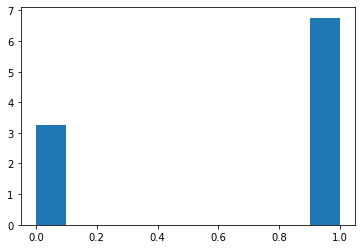

In [461]:
plt.hist(CB_AF.predict(X_test)[np.where(y_test==0)],density=True)

In [462]:
temp_large_db = AF_dataset_uzgent[((AF_dataset_uzgent.AF==0)&(~AF_dataset_uzgent.patientid.isin(AF_NOW_uzgent.patientid)))|(AF_dataset_uzgent.patientid.isin(test_AF_dataset.patientid))]

"""print("CARDIAC SURGERY NEW PATIENTS")
X_test_card = temp_large_db[((temp_large_db.AF==1)|((temp_large_db.AF_orig==0)&(temp_large_db.AF==0)))&(temp_large_db.cardio_surgery_new==1)][feature_columns]
y_test_card = temp_large_db[((temp_large_db.AF==1)|((temp_large_db.AF_orig==0)&(temp_large_db.AF==0)))&(temp_large_db.cardio_surgery_new==1)].AF
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_card,label=y_test_card), plot=False)
print(classification_report(y_test_card,CB_AF.predict(X_test_card),target_names=["No-AF","AF"]))
print("\n") 
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_card,CB_AF.predict(X_test_card)),4)))
print(50*"=")

print("CARDIAC SURGERY NEW PATIENTS Balanced")
NO_AF_pat_len = len(test_AF_dataset[((test_AF_dataset.AF_orig==0)&(test_AF_dataset.AF==0))&(test_AF_dataset.cardio_surgery_new==1)])
AF_pat_len = len(test_AF_dataset[(test_AF_dataset.AF==1)&(test_AF_dataset.cardio_surgery_new==1)])
if AF_pat_len > NO_AF_pat_len:
    card_af_db = test_AF_dataset[((test_AF_dataset.AF==1)
                                            |((test_AF_dataset.AF_orig==0)&(test_AF_dataset.AF==0)))&(test_AF_dataset.cardio_surgery_new==1)].append(temp_large_db[((temp_large_db.AF_orig==0)&(temp_large_db.AF==0))&(temp_large_db.cardio_surgery_new==1)
                                          &(~temp_large_db.patientid.isin(test_AF_dataset.patientid))].sample(AF_pat_len-NO_AF_pat_len))
else:
    card_af_db = test_AF_dataset[(test_AF_dataset.AF==1)&(test_AF_dataset.cardio_surgery_new==1)].append(test_AF_dataset[((test_AF_dataset.AF_orig==0)&(test_AF_dataset.AF==0))&(test_AF_dataset.cardio_surgery_new==1)].sample(AF_pat_len))
                       
X_test_card = card_af_db[feature_columns]
y_test_card = card_af_db.AF
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_card,label=y_test_card), plot=False)
print(classification_report(y_test_card,CB_AF.predict(X_test_card),target_names=["No-AF","AF"]))
print("\n")
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_card,CB_AF.predict(X_test_card)),4)))
print(50*"=")"""

print("SEPSIS PATIENTS")
X_test_sepsis = temp_large_db[((temp_large_db.AF==1)|((temp_large_db.AF_orig==0)&(temp_large_db.AF==0)))&(temp_large_db.sepsis_bool==1)][feature_columns]
y_test_sepsis = temp_large_db[((temp_large_db.AF==1)|((temp_large_db.AF_orig==0)&(temp_large_db.AF==0)))&(temp_large_db.sepsis_bool==1)].AF
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_sepsis,label=y_test_sepsis), plot=False)
print(classification_report(y_test_sepsis,CB_AF.predict(X_test_sepsis),target_names=["No-AF","AF"]))
print("\n")
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_sepsis,CB_AF.predict(X_test_sepsis)),4)))
print(50*"=")

uzgent_result_dataframe = pandas_result_AF_maker("sepsis",X_test_sepsis,y_test_sepsis,CB_AF,uzgent_result_dataframe)


print("SEPSIS PATIENTS Balanced")
NO_AF_pat_len = len(test_AF_dataset[((test_AF_dataset.AF_orig==0)&(test_AF_dataset.AF==0))&(test_AF_dataset.sepsis_bool==1)])
AF_pat_len = len(test_AF_dataset[(test_AF_dataset.AF==1)&(test_AF_dataset.sepsis_bool==1)])
if AF_pat_len > NO_AF_pat_len:
    sepsis_af_db = test_AF_dataset[((test_AF_dataset.AF==1)
                                            |((test_AF_dataset.AF_orig==0)&(test_AF_dataset.AF==0)))&(test_AF_dataset.sepsis_bool==1)].append(temp_large_db[((temp_large_db.AF_orig==0)&(temp_large_db.AF==0))&(temp_large_db.sepsis_bool==1)
                                          &(~temp_large_db.patientid.isin(test_AF_dataset.patientid))].sample(AF_pat_len-NO_AF_pat_len))
else:
    sepsis_af_db = test_AF_dataset[(test_AF_dataset.AF==1)&(test_AF_dataset.sepsis_bool==1)].append(test_AF_dataset[((test_AF_dataset.AF_orig==0)&(test_AF_dataset.AF==0))&(test_AF_dataset.sepsis_bool==1)].sample(AF_pat_len))
                 


X_test_sepsis = sepsis_af_db[feature_columns]
y_test_sepsis = sepsis_af_db.AF
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_sepsis,label=y_test_sepsis), plot=False)
print(classification_report(y_test_sepsis,CB_AF.predict(X_test_sepsis),target_names=["No-AF","AF"]))
print("\n")
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_sepsis,CB_AF.predict(X_test_sepsis)),4)))
print(50*"=")

uzgent_result_dataframe = pandas_result_AF_maker("sepsis balanced",X_test_sepsis,y_test_sepsis,CB_AF,uzgent_result_dataframe)


y_test_all_pat = temp_large_db[(temp_large_db.AF==1)|((temp_large_db.AF_orig==0)&(temp_large_db.AF==0))].AF
X_test_all_pat = temp_large_db[(temp_large_db.AF==1)|((temp_large_db.AF_orig==0)&(temp_large_db.AF==0))][feature_columns]


print("ALL PATIENTS")
print(classification_report(y_test_all_pat,CB_AF.predict(X_test_all_pat),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_all_pat,label=y_test_all_pat), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_all_pat,CB_AF.predict(X_test_all_pat)),4)))
print(50*"=")

uzgent_result_dataframe = pandas_result_AF_maker("all patients",X_test_all_pat,y_test_all_pat,CB_AF,uzgent_result_dataframe)

print("BALANCED TEST PATIENTS")
print(classification_report(y_test,CB_AF.predict(X_test),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test,label=y_test), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test,CB_AF.predict(X_test)),4)))
print(50*"=")

uzgent_result_dataframe = pandas_result_AF_maker("balanced test",X_test,y_test,CB_AF,uzgent_result_dataframe)

SEPSIS PATIENTS
              precision    recall  f1-score   support

       No-AF       1.00      0.29      0.45      2114
          AF       0.02      0.96      0.03        24

    accuracy                           0.30      2138
   macro avg       0.51      0.62      0.24      2138
weighted avg       0.99      0.30      0.44      2138



AUC = 0.6517
MCC = 0.0576
SEPSIS PATIENTS Balanced
              precision    recall  f1-score   support

       No-AF       0.88      0.29      0.44        24
          AF       0.57      0.96      0.72        24

    accuracy                           0.62        48
   macro avg       0.72      0.62      0.58        48
weighted avg       0.72      0.62      0.58        48



AUC = 0.5625
MCC = 0.3354
ALL PATIENTS
              precision    recall  f1-score   support

       No-AF       1.00      0.35      0.51     15759
          AF       0.02      0.94      0.03       197

    accuracy                           0.35     15956
   macro avg      

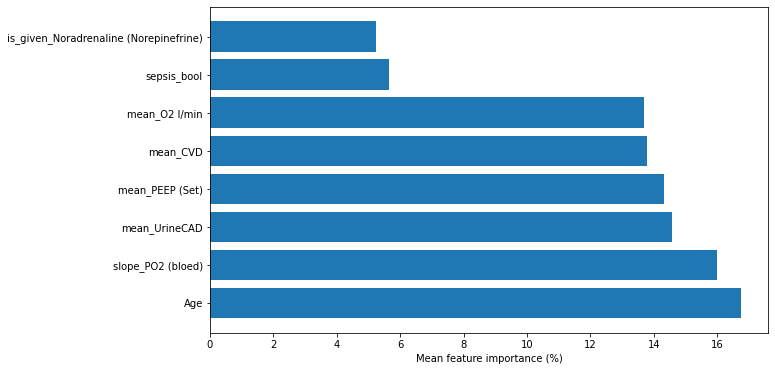

In [463]:
present=False

am_show_features = 60 if len(X_train.columns)>=30 else len(X_train.columns)
fi = CB_AF.feature_importances_
plt.figure(figsize=(10,6))
indices_T0 = np.argsort(fi)[::-1][0:am_show_features]
if present:
    plt.barh(range(am_show_features),fi[indices_T0],color="#e898ac")
else:
    plt.barh(range(am_show_features),fi[indices_T0])
plt.yticks(range(am_show_features), X_train.columns[indices_T0])
plt.xlabel("Mean feature importance (%)")
if present:
    ax = plt.gca()
    ax.patch.set_alpha(0)
#plt.tight_layout()
plt.show()

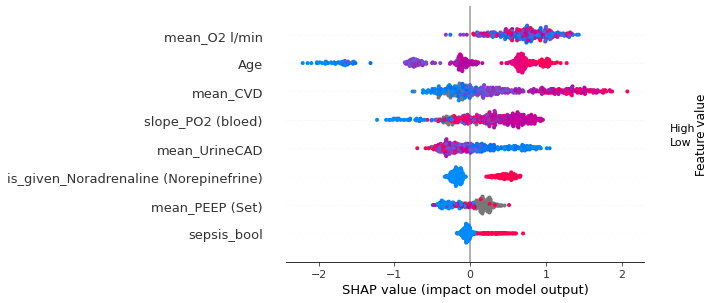

In [464]:
present=False

explainer = shap.TreeExplainer(CB_AF)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test,show=False)


# P-tests

In [465]:
#bonferri correction: alpha/m, with m the amount of total tests
from scipy.stats import ranksums

# print("p-value comparisons")
# print(100*"=")
# print("")
    

# print("Direct - Internal")
# print("")
# print("Rank-sum p-value: "+ str(ranksums(direct_predict,AMST_predict)[1]))
# print(10*"-")
# print("AF ")
# print("Rank-sum p-value: "+ str(ranksums(direct_predict[np.where(direct_y_test==1)],AMST_predict[np.where(AMST_y_test==1)])[1]))
# print(10*"-")
# print("NO AF")
# print("Rank-sum p-value: "+ str(ranksums(direct_predict[np.where(direct_y_test==0)],AMST_predict[np.where(AMST_y_test==0)])[1]))
# print(40*"=")
# print("")
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Direct - Internal","all",ranksums(direct_predict,AMST_predict)[1]]],columns=uzgent_p_value_result_dataframe_columns)])
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Direct - Internal","AF",ranksums(direct_predict[np.where(direct_y_test==1)],AMST_predict[np.where(AMST_y_test==1)])[1]]],columns=uzgent_p_value_result_dataframe_columns)])
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Direct - Internal","NO AF",ranksums(direct_predict[np.where(direct_y_test==0)],AMST_predict[np.where(AMST_y_test==0)])[1]]],columns=uzgent_p_value_result_dataframe_columns)])


# print("Combo uzgent - Internal ")
# print("")
# print("Rank-sum p-value: "+ str(ranksums(combo_uzgent_predict,AMST_predict)[1]))
# print(10*"-")
# print("AF ")
# print("Rank-sum p-value: "+ str(ranksums(combo_uzgent_predict[np.where(combo_uzgent_y_test==1)],AMST_predict[np.where(AMST_y_test==1)])[1]))
# print(10*"-")
# print("NO AF")
# print("Rank-sum p-value: "+ str(ranksums(combo_uzgent_predict[np.where(combo_uzgent_y_test==0)],AMST_predict[np.where(AMST_y_test==0)])[1]))
# print(40*"=")
# print("")
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Combo uzgent - Internal","all",ranksums(combo_uzgent_predict,AMST_predict)[1]]],columns=uzgent_p_value_result_dataframe_columns)])
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Combo uzgent - Internal","AF",ranksums(combo_uzgent_predict[np.where(combo_uzgent_y_test==1)],AMST_predict[np.where(AMST_y_test==1)])[1]]],columns=uzgent_p_value_result_dataframe_columns)])
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Combo uzgent - Internal","NO AF",ranksums(combo_uzgent_predict[np.where(combo_uzgent_y_test==0)],AMST_predict[np.where(AMST_y_test==0)])[1]]],columns=uzgent_p_value_result_dataframe_columns)])


# print("Combo amst - Internal ")
# print("")
# print("Rank-sum p-value: "+ str(ranksums(combo_amst_predict,AMST_predict)[1]))
# print(10*"-")
# print("AF ")
# print("Rank-sum p-value: "+ str(ranksums(combo_amst_predict[np.where(combo_amst_y_test==1)],AMST_predict[np.where(AMST_y_test==1)])[1]))
# print(10*"-")
# print("NO AF")
# print("Rank-sum p-value: "+ str(ranksums(combo_amst_predict[np.where(combo_amst_y_test==0)],AMST_predict[np.where(AMST_y_test==0)])[1]))
# print(40*"=")
# print("")
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Combo amst - Internal","all",ranksums(combo_amst_predict,AMST_predict)[1]]],columns=uzgent_p_value_result_dataframe_columns)])
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Combo amst - Internal","AF",ranksums(combo_amst_predict[np.where(combo_amst_y_test==1)],AMST_predict[np.where(AMST_y_test==1)])[1]]],columns=uzgent_p_value_result_dataframe_columns)])
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Combo amst - Internal","NO AF",ranksums(combo_amst_predict[np.where(combo_amst_y_test==0)],AMST_predict[np.where(AMST_y_test==0)])[1]]],columns=uzgent_p_value_result_dataframe_columns)])


# print("Transfer - Internal ")
# print("")
# print("Rank-sum p-value: "+ str(ranksums(transfer_predict,AMST_predict)[1]))
# print(10*"-")
# print("AF ")
# print("Rank-sum p-value: "+ str(ranksums(transfer_predict[np.where(transfer_y_test==1)],AMST_predict[np.where(AMST_y_test==1)])[1]))
# print(10*"-")
# print("NO AF")
# print("Rank-sum p-value: "+ str(ranksums(transfer_predict[np.where(transfer_y_test==0)],AMST_predict[np.where(AMST_y_test==0)])[1]))
# print(40*"=")
# print("")
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Transfer - Internal","all",ranksums(transfer_predict,AMST_predict)[1]]],columns=uzgent_p_value_result_dataframe_columns)])
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Transfer - Internal","AF",ranksums(transfer_predict[np.where(transfer_y_test==1)],AMST_predict[np.where(AMST_y_test==1)])[1]]],columns=uzgent_p_value_result_dataframe_columns)])
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Transfer - Internal","NO AF",ranksums(transfer_predict[np.where(transfer_y_test==0)],AMST_predict[np.where(AMST_y_test==0)])[1]]],columns=uzgent_p_value_result_dataframe_columns)])


# print("Transfer - Combo uzgent ")
# print("")
# print("Rank-sum p-value: "+ str(ranksums(transfer_predict,combo_uzgent_predict)[1]))
# print(10*"-")
# print("AF ")
# print("Rank-sum p-value: "+ str(ranksums(transfer_predict[np.where(transfer_y_test==1)],combo_uzgent_predict[np.where(combo_uzgent_y_test==1)])[1]))
# print(10*"-")
# print("NO AF")
# print("Rank-sum p-value: "+ str(ranksums(transfer_predict[np.where(transfer_y_test==0)],combo_uzgent_predict[np.where(combo_uzgent_y_test==0)])[1]))
# print(40*"=")
# print("")
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Transfer - Combo uzgent","all",ranksums(transfer_predict,combo_uzgent_predict)[1]]],columns=uzgent_p_value_result_dataframe_columns)])
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Transfer - Combo uzgent","AF",ranksums(transfer_predict[np.where(transfer_y_test==1)],combo_uzgent_predict[np.where(combo_uzgent_y_test==1)])[1]]],columns=uzgent_p_value_result_dataframe_columns)])
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Transfer - Combo uzgent","NO AF",ranksums(transfer_predict[np.where(transfer_y_test==0)],combo_uzgent_predict[np.where(combo_uzgent_y_test==0)])[1]]],columns=uzgent_p_value_result_dataframe_columns)])


# print("Transfer - Direct ")
# print("")
# print("Rank-sum p-value: "+ str(ranksums(transfer_predict,direct_predict)[1]))
# print(10*"-")
# print("AF ")
# print("Rank-sum p-value: "+ str(ranksums(transfer_predict[np.where(transfer_y_test==1)],direct_predict[np.where(direct_y_test==1)])[1]))
# print(10*"-")
# print("NO AF")
# print("Rank-sum p-value: "+ str(ranksums(transfer_predict[np.where(transfer_y_test==0)],direct_predict[np.where(direct_y_test==0)])[1]))
# print(40*"=")
# print("")
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Transfer - Direct","all",ranksums(transfer_predict,direct_predict)[1]]],columns=uzgent_p_value_result_dataframe_columns)])
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Transfer - Direct","AF",ranksums(transfer_predict[np.where(transfer_y_test==1)],direct_predict[np.where(direct_y_test==1)])[1]]],columns=uzgent_p_value_result_dataframe_columns)])
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Transfer - Direct","NO AF",ranksums(transfer_predict[np.where(transfer_y_test==0)],direct_predict[np.where(direct_y_test==0)])[1]]],columns=uzgent_p_value_result_dataframe_columns)])


# print("Combo uzgent - Direct ")
# print("")
# print("Rank-sum p-value: "+ str(ranksums(combo_uzgent_predict,direct_predict)[1]))
# print(10*"-")
# print("AF ")
# print("Rank-sum p-value: "+ str(ranksums(combo_uzgent_predict[np.where(combo_uzgent_y_test==1)],direct_predict[np.where(direct_y_test==1)])[1]))
# print(10*"-")
# print("NO AF")
# print("Rank-sum p-value: "+ str(ranksums(combo_uzgent_predict[np.where(combo_uzgent_y_test==0)],direct_predict[np.where(direct_y_test==0)])[1]))
# print(40*"=")
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Combo uzgent - Direct","all",ranksums(combo_uzgent_predict,direct_predict)[1]]],columns=uzgent_p_value_result_dataframe_columns)])
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Combo uzgent - Direct","AF",ranksums(combo_uzgent_predict[np.where(combo_uzgent_y_test==1)],direct_predict[np.where(direct_y_test==1)])[1]]],columns=uzgent_p_value_result_dataframe_columns)])
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Combo uzgent - Direct","NO AF",ranksums(combo_uzgent_predict[np.where(combo_uzgent_y_test==0)],direct_predict[np.where(direct_y_test==0)])[1]]],columns=uzgent_p_value_result_dataframe_columns)])



In [466]:
# #bonferri correction: alpha/m, with m the amount of total tests
# from scipy.stats import ranksums
# print("p-value comparisons")
# print(100*"=")
# print("")

# print("Direct - Internal")
# print("")
# print("Rank-sum p-value: "+ str(ranksums(direct_predict,AMST_predict)[1]))
# print(10*"-")
# print("AF ")
# print("Rank-sum p-value: "+ str(ranksums(direct_predict[np.where(direct_y_test==1)],AMST_predict[np.where(AMST_y_test==1)])[1]))
# print(10*"-")
# print("NO AF")
# print("Rank-sum p-value: "+ str(ranksums(direct_predict[np.where(direct_y_test==0)],AMST_predict[np.where(AMST_y_test==0)])[1]))
# print(40*"=")
# print("")

# print("Combo uzgent - Internal ")
# print("")
# print("Rank-sum p-value: "+ str(ranksums(combo_uzgent_predict,AMST_predict)[1]))
# print(10*"-")
# print("AF ")
# print("Rank-sum p-value: "+ str(ranksums(combo_uzgent_predict[np.where(combo_uzgent_y_test==1)],AMST_predict[np.where(AMST_y_test==1)])[1]))
# print(10*"-")
# print("NO AF")
# print("Rank-sum p-value: "+ str(ranksums(combo_uzgent_predict[np.where(combo_uzgent_y_test==0)],AMST_predict[np.where(AMST_y_test==0)])[1]))
# print(40*"=")
# print("")

# print("Combo amst - Internal ")
# print("")
# print("Rank-sum p-value: "+ str(ranksums(combo_amst_predict,AMST_predict)[1]))
# print(10*"-")
# print("AF ")
# print("Rank-sum p-value: "+ str(ranksums(combo_amst_predict[np.where(combo_amst_y_test==1)],AMST_predict[np.where(AMST_y_test==1)])[1]))
# print(10*"-")
# print("NO AF")
# print("Rank-sum p-value: "+ str(ranksums(combo_amst_predict[np.where(combo_amst_y_test==0)],AMST_predict[np.where(AMST_y_test==0)])[1]))
# print(40*"=")
# print("")

# print("Transfer - Internal ")
# print("")
# print("Rank-sum p-value: "+ str(ranksums(transfer_predict,AMST_predict)[1]))
# print(10*"-")
# print("AF ")
# print("Rank-sum p-value: "+ str(ranksums(transfer_predict[np.where(transfer_y_test==1)],AMST_predict[np.where(AMST_y_test==1)])[1]))
# print(10*"-")
# print("NO AF")
# print("Rank-sum p-value: "+ str(ranksums(transfer_predict[np.where(transfer_y_test==0)],AMST_predict[np.where(AMST_y_test==0)])[1]))
# print(40*"=")
# print("")

# print("Transfer - Combo uzgent ")
# print("")
# print("Rank-sum p-value: "+ str(ranksums(transfer_predict,combo_uzgent_predict)[1]))
# print(10*"-")
# print("AF ")
# print("Rank-sum p-value: "+ str(ranksums(transfer_predict[np.where(transfer_y_test==1)],combo_uzgent_predict[np.where(combo_uzgent_y_test==1)])[1]))
# print(10*"-")
# print("NO AF")
# print("Rank-sum p-value: "+ str(ranksums(transfer_predict[np.where(transfer_y_test==0)],combo_uzgent_predict[np.where(combo_uzgent_y_test==0)])[1]))
# print(40*"=")
# print("")

# print("Transfer - Direct ")
# print("")
# print("Rank-sum p-value: "+ str(ranksums(transfer_predict,direct_predict)[1]))
# print(10*"-")
# print("AF ")
# print("Rank-sum p-value: "+ str(ranksums(transfer_predict[np.where(transfer_y_test==1)],direct_predict[np.where(direct_y_test==1)])[1]))
# print(10*"-")
# print("NO AF")
# print("Rank-sum p-value: "+ str(ranksums(transfer_predict[np.where(transfer_y_test==0)],direct_predict[np.where(direct_y_test==0)])[1]))
# print(40*"=")
# print("")

# print("Combo uzgent - Direct ")
# print("")
# print("Rank-sum p-value: "+ str(ranksums(combo_uzgent_predict,direct_predict)[1]))
# print(10*"-")
# print("AF ")
# print("Rank-sum p-value: "+ str(ranksums(combo_uzgent_predict[np.where(combo_uzgent_y_test==1)],direct_predict[np.where(direct_y_test==1)])[1]))
# print(10*"-")
# print("NO AF")
# print("Rank-sum p-value: "+ str(ranksums(combo_uzgent_predict[np.where(combo_uzgent_y_test==0)],direct_predict[np.where(direct_y_test==0)])[1]))
# print(40*"=")


In [467]:
uzgent_result_dataframe

,model,validation_type,patient_group,NO AF patients,AF patients,NO AF recall,AF recall,NO AF precision,AF precision,NO AF f1,AF f1,mcc,auc
0,1.5u,transfer,balanced test,195,205,0.717949,0.721951,0.710660,0.729064,0.714286,0.725490,0.439812,0.803352
0,1.5u,transfer,sepsis,2372,30,0.651771,0.700000,0.994212,0.024793,0.787369,0.047891,0.081766,0.748763
0,1.5u,transfer,sepsis balanced,30,30,0.633333,0.700000,0.678571,0.656250,0.655172,0.677419,0.334077,0.702222
0,1.5u,transfer,all patients,21496,205,0.703759,0.721951,0.996246,0.022713,0.824841,0.044041,0.089840,0.799664
0,1.5u,combo,sepsis uzgent,2372,30,0.669899,0.633333,0.993125,0.023691,0.800101,0.045673,0.071408,0.748918
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,6u old,combo,balanced test amsterdam,398,341,0.733668,0.697947,0.739241,0.691860,0.736444,0.694891,0.431358,0.790094
0,6u old,direct,sepsis,2114,24,0.288553,0.958333,0.998363,0.015062,0.447706,0.029658,0.057572,0.651746
0,6u old,direct,sepsis balanced,24,24,0.291667,0.958333,0.875000,0.575000,0.437500,0.718750,0.335410,0.562500
0,6u old,direct,all patients,15759,197,0.346024,0.939086,0.997804,0.017634,0.513852,0.034618,0.066345,0.740669


In [468]:
uzgent_p_value_result_dataframe

,model,comparison,AF_group,p_value
0,1.5u,Direct - Internal,all,1.390296e-10
0,1.5u,Direct - Internal,AF,1.411353e-03
0,1.5u,Direct - Internal,NO AF,2.391532e-07
0,1.5u,Combo uzgent - Internal,all,7.746231e-01
0,1.5u,Combo uzgent - Internal,AF,6.505611e-01
...,...,...,...,...
0,6u old,Transfer - Direct,AF,5.272692e-03
0,6u old,Transfer - Direct,NO AF,2.385968e-09
0,6u old,Combo uzgent - Direct,all,4.436864e-10
0,6u old,Combo uzgent - Direct,AF,4.028584e-03


In [469]:
uzgent_p_value_result_dataframe.to_csv("uzgent_p_value_result_dataframe.csv",index=False)

In [470]:
uzgent_result_dataframe.to_csv("uzgent_result_dataframe.csv",index=False)

In [471]:
# uzgent_result_dataframe = pd.read_csv("uzgent_result_dataframe.csv")
# uzgent_result_dataframe[(uzgent_result_dataframe.patient_group.str.contains("balanced test"))|(uzgent_result_dataframe.patient_group.str.contains("all patients"))][['model', 'validation_type', 'patient_group', 'NO AF patients',
#        'AF patients', 'NO AF recall', 'AF recall', 'NO AF precision',
#        'AF precision', 'auc']].to_csv("uzgent_result_dataframe_paper.csv",index=False)

In [403]:
# mimic_result_dataframe = pd.read_csv("mimic_result_dataframe.csv")
# mimic_result_dataframe[(mimic_result_dataframe.patient_group.str.contains("balanced test"))|(mimic_result_dataframe.patient_group.str.contains("all patients"))][['model', 'validation_type', 'patient_group', 'NO AF patients',
#        'AF patients', 'NO AF recall', 'AF recall', 'NO AF precision',
#        'AF precision', 'auc']].to_csv("mimic_result_dataframe_paper.csv",index=False)

# Causal validation

## Data loading

In [404]:
causal_time_window = 6
causal  = "NOR" #NOR or PEEP
distr_change = True
nor_dataset_original = True #if True, we have no overlap between the two treatment groups so this has to be more correct
PEEP_setting = 7

if causal == "NOR":
    causal_label = "is_given_Noradrenaline (Norepinefrine)_causal"
else:
    causal_label = "PEEP_causal_treatment"
    
causal_string_df = causal+("_setting_"+str(PEEP_setting))*(int(causal=="PEEP"))

In [405]:
uzgent_causality_dataframe_columns=["causal","distr_change","combo","balance_test","balance_train","NO AF T1 patients","AF T1 patients","NO AF T0 patients","AF T0 patients","propensity_before","propensity_after","iterations","CATE","p-value"]
uzgent_causality_dataframe = pd.DataFrame(columns=uzgent_causality_dataframe_columns)

In [406]:
with_adm_drop_columns = ['admittime', 'AF', 'AF_measuredat', 'intime',
       'outtime', 'sepsis_bool', 'surgery_bool', 'cardiac_bool',
       'cardiac_bool_new', 'lengthofstay', 'admissioncount',
       'date_corresponds_to_AF_admid', 'AF_orig']

drop_columns = ['age','patientid', 'hadm_id', 'admittime', 'AF_measuredat', 'intime',
       'outtime', 'admissionid', 'lengthofstay', 
       'date_corresponds_to_AF_admid']
        
if causal_time_window>0:

    feature_columns = ['Age', 'max_O2 l/min', 'min_Fosfaat (bloed)', #'fluidout',
                       'is_given_Calcium Glubionaat (Calcium Sandoz)', 'max_Hartfrequentie', 
                       "min_Thrombo's (bloed)",  'mean_CVD',
                       'is_given_Noradrenaline (Norepinefrine)',#,
                       'mean_PEEP (Set)']
    
    if causal == "PEEP":

        obj_causal_cols = [#'mean_Ademfrequentie Monitor',
                     'mean_pCO2 (bloed)',#'slope_pCO2 (bloed)',
                     'mean_pH (bloed)',#'slope_pH (bloed)',
                     'is_given_Propofol (Diprivan)']
        
        
    elif causal == "NOR":
        
        obj_causal_cols =[
         'mean_Lactaat (bloed)',
         'mean_ABP gemiddeld',#'slope_ABP gemiddeld',
         'sepsis_bool','sofa',
         'is_given_Propofol (Diprivan)']

In [407]:
if distr_change:
    AF_dataset = pd.read_csv(data_save_path+"AF_dataset_"+str(causal_time_window)+"_hours_no_af_distribution_matched.csv")
    causal_dataset = pd.read_csv(data_save_path+causal+"_causal_AF_dataset_causal_window_"+str(causal_time_window)+"_hours_no_af_distribution_matched.csv")
else:
    AF_dataset = pd.read_csv(data_save_path+"AF_dataset_"+str(causal_time_window)+"_hours.csv")
    causal_dataset = pd.read_csv(data_save_path+causal+"_causal_AF_dataset_causal_window_"+str(causal_time_window)+"_hours.csv")

if causal != "PEEP":
    causal_dataset.loc[causal_dataset["causal_CV_norepinephrine"].isna(),"causal_CV_norepinephrine"]=0
else:
    causal_dataset = causal_dataset.rename(columns={'causal_PEEP_M_ALL':'mean_PEEP (Set)_causal'})
    causal_dataset.loc[causal_dataset["mean_PEEP (Set)_causal"].isna(),"mean_PEEP (Set)_causal"]=0
    

AF_dataset = causal_dataset


Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.


KeyboardInterrupt: 

In [ ]:
AF_dataset["is_given_NORepinefrine"]=0
AF_dataset.loc[AF_dataset['mean_CV_norepinephrine']>0,"is_given_NORepinefrine"]=1

#AF_dataset["cardiac_surg_bool"]=0
#AF_dataset.loc[(AF_dataset["cardiac_bool"]==1)&(AF_dataset["surgery_bool"]==1),"cardiac_surg_bool"] = 1

AF_dataset["is_given_Calcium Glubionaat (Calcium Sandoz)"]=0
AF_dataset.loc[(AF_dataset["mean_VI_calcium carbonate"]>1)|(AF_dataset["mean_VI_calcium chloride"]>1),"is_given_Calcium Glubionaat (Calcium Sandoz)"] = 1
    
AF_dataset["is_given_Dopamine (Inotropin)"]=0
AF_dataset.loc[AF_dataset['mean_CV_dopamine']>0,"is_given_Dopamine (Inotropin)"]=1

#AF_dataset['is_given_Magnesiumsulfaat (MgSO4)']=0
#AF_dataset.loc[AF_dataset['mean_Magnesium Sulfate']>0,'is_given_Magnesiumsulfaat (MgSO4)']=1

AF_dataset['is_given_Propofol (Diprivan)']=0
AF_dataset.loc[AF_dataset['mean_NS_propofol']>0,'is_given_Propofol (Diprivan)']=1

AF_dataset['is_given_Fentanyl']=0
AF_dataset.loc[AF_dataset['mean_NS_fentanyl']>0,'is_given_Fentanyl']=1

AF_dataset["is_given_Furosemide (Lasix)"]=0
AF_dataset.loc[AF_dataset['mean_DI_furosemide']>0,"is_given_Furosemide (Lasix)"]=1

AF_dataset["is_given_LoopDiuretics"]=0
AF_dataset.loc[(AF_dataset['mean_DI_furosemide']>0),"is_given_LoopDiuretics"]=1

if causal != "PEEP":
    AF_dataset["is_given_Noradrenaline (Norepinefrine)_causal"]=0
    AF_dataset.loc[(AF_dataset['causal_CV_norepinephrine']>0),"is_given_Noradrenaline (Norepinefrine)_causal"]=1

AF_dataset["sepsis_bool"]=0
AF_dataset.loc[(AF_dataset.sepsis_bool_comorb_source==1) | (AF_dataset.sepsis_bool_extra_opn==1),"sepsis_bool"]=1


In [ ]:
#Rename for distr change 12 hour model
AF_dataset = AF_dataset.rename(columns={'mean_PEEP_M_ALL':'mean_PEEP (Set)', 'is_given_NORepinefrine':'is_given_Noradrenaline (Norepinefrine)', 'mean_URINE_VOL':'mean_UrineCAD', 
                           'min_NS_propofol':'min_Propofol (Diprivan)', 'min_NS_fentanyl':'min_Fentanyl', 'mean_RESPRATE_ALL':'mean_O2 l/min', #'cardiac_bool_new':'cardio_surgery_new',
                           'mean_PHOSPHATE_ALL':'mean_Fosfaat (bloed)', 'kurt_CVD':'kurt_CVD', 'max_HR_ALL':'max_Hartfrequentie', "max_PLATELETS":"max_Thrombo's (bloed)"})

#Rename for distr change 6 hour model
AF_dataset = AF_dataset.rename(columns={'max_RESPRATE_ALL':'max_O2 l/min', "mean_PCO2_ART":"mean_pCO2 (bloed)","slope_PH_ART_ALL":"mean_pH (bloed)",#'cardiac_bool_new':'cardio_surgery_new',
                                        'min_PHOSPHATE_ALL':'min_Fosfaat (bloed)', 'mean_CVD':'mean_CVD', 'mean_LACTATE_SERUM_ALL':'mean_Lactaat (bloed)','mean_IBP_M':'mean_ABP gemiddeld',
                                        "min_PLATELETS":"min_Thrombo's (bloed)"})

#Rename for distr change 1.5 hour model
AF_dataset = AF_dataset.rename(columns={'max_UREA_ALL':'max_Ureum (bloed)'})

#Rename for standard 12 hour model
AF_dataset = AF_dataset.rename(columns={"slope_PO2_ART":'slope_PO2 (bloed)'})

#Rename for standard 1.5 hour model
AF_dataset = AF_dataset.rename(columns={ 'min_RESPRATE_ALL':'min_O2 l/min', "mean_PLATELETS":"mean_Thrombo's (bloed)",
                                        'min_CVD':'min_CVD'})

In [ ]:
if causal == "NOR":
    AF_dataset.loc[AF_dataset['mean_PEEP (Set)'].isna(),'mean_PEEP (Set)'] = 0
if causal == "PEEP":
    AF_dataset['PEEP_causal_treatment']=0
    AF_dataset.loc[AF_dataset["mean_PEEP (Set)_causal"]>=PEEP_setting,"PEEP_causal_treatment"]=1

In [ ]:
RS_multiple = 41

In [ ]:
from sklearn.model_selection import train_test_split
#the balancing is later, the stratification on AF makes sure that the proportion of AF to no AF stays the same and we do not lose this information by balancing the training or test set

if distr_change:
    #train_patientid,test_patientid = train_test_split(AF_dataset[AF_dataset.AF==1].patientid.unique(), test_size=0.33, random_state=42) #0.33 test set
    #train_AF_dataset = AF_dataset[~(AF_dataset.date_corresponds_to_AF_admid.isin(test_patientid))]
    #test_AF_dataset = AF_dataset[AF_dataset.date_corresponds_to_AF_admid.isin(test_patientid)]
    
    train_patientid,test_patientid = train_test_split(AF_dataset[(AF_dataset.AF==1)|(AF_dataset.date_corresponds_to_AF_admid!=AF_dataset.patientid)].patientid, test_size=0.33, random_state=RS_multiple) #0.33 test set
    train_AF_dataset = AF_dataset[(AF_dataset.patientid.isin(train_patientid))].copy(deep=True)
    test_AF_dataset =  AF_dataset[~(AF_dataset.patientid.isin(train_patientid))].copy(deep=True)
else:
    train_patientid,test_patientid = train_test_split(AF_dataset.patientid.unique(), test_size=0.33, random_state=42,stratify=AF_dataset.AF.values)
    train_AF_dataset = AF_dataset[~(AF_dataset.patientid.isin(test_patientid))]
    test_AF_dataset = AF_dataset[AF_dataset.patientid.isin(test_patientid)]

[]

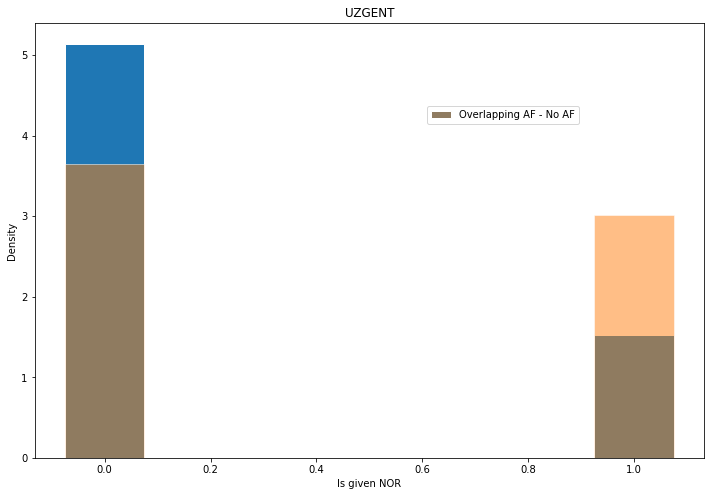

In [ ]:
from matplotlib import patches as mpatches

fig,ax = plt.subplots(1,1,figsize=(12,8))

if causal == "PEEP":
    ax.hist(AF_dataset[AF_dataset.AF==0]['mean_PEEP (Set)_causal'],bins=np.arange(-0.5,16,1),ec="white",density=True,label="NO AF")
    ax.hist(AF_dataset[AF_dataset.AF==1]['mean_PEEP (Set)_causal'],bins=np.arange(-0.5,16,1),ec="white",density=True,alpha=0.5,label="AF")
    ax.set_xticks(np.arange(0,16,1))
    #plt.legend()
    ax.set_xlabel("PEEP Setting")
    overlap_patch = mpatches.Patch(color='#8f7b60', label='Overlapping AF - No AF',ec="white")
    leg_p = fig.legend(handles=[overlap_patch],loc=(0.6,0.75))
    if present:
        ax.patch.set_alpha(0)
        leg = ax.legend(loc=(0.58,0.83))

else:
    ax.hist(AF_dataset[AF_dataset.AF==0]['is_given_Noradrenaline (Norepinefrine)_causal'],ec="white",bins=[-0.075,0.075,0.925,1.075],density=True,label="NO AF")
    ax.hist(AF_dataset[AF_dataset.AF==1]['is_given_Noradrenaline (Norepinefrine)_causal'],ec="white",bins=[-0.075,0.075,0.925,1.075],density=True,alpha=0.5,label="AF")
    #plt.legend()
    ax.set_xlabel("Is given NOR")
    overlap_patch = mpatches.Patch(color='#8f7b60', label='Overlapping AF - No AF',ec="white")
    leg_p = fig.legend(handles=[overlap_patch],loc=(0.6,0.75))
    if present:
        ax.patch.set_alpha(0)
        leg = ax.legend(loc=(0.59,0.83))
    
ax.set_ylabel("Density")
ax.set_title("UZGENT")
overlap_patch = mpatches.Patch(color='#8f7b60', label='Overlapping AF - No AF',ec="white")
if present:
    leg.get_frame().set_alpha(0)
    for text in leg.get_texts():
        text.set_color("white")
    leg_p.get_frame().set_alpha(0)
    for text in leg_p.get_texts():
        text.set_color("white")
plt.plot()

### Causality testing

In [ ]:
import scipy.stats as stat
from scipy import stats
import pandas as pd
import numpy as np
from matplotlib.lines import Line2D

if present:
    non_significant_color =  "white"
    significant_color = "#e898ac"
else:
    non_significant_color = "b"
    significant_color = "r"


legend_elements = [Line2D([0], [0], marker='o', color='w', label='Significant',
                          markerfacecolor=significant_color, markersize=7),
                   Line2D([0], [0], marker='o', color='w', label='Non significant',
                          markerfacecolor=non_significant_color, markersize=7)]
    
def print_coef(model, columns):
    """ Plot logistic regression model coefficients """ 
    coef = np.abs(pd.DataFrame(np.transpose(model.coef_), index = columns, columns = ['Coefficients']))
    coef = coef.sort_values(by=['Coefficients'], ascending=True)
    plt.figure(figsize = (6,18))
    plt.scatter(y = range(len(coef)), x = coef['Coefficients'])
    plt.yticks(range(len(coef)),coef.index, rotation = 'horizontal')
    plt.xlabel('LR coefficient')
    if present:
        ax = plt.gca()
        ax.patch.set_alpha(0)
    plt.show()
    #return coef
    
def print_coef_std_int(coefs,intercept, columns_feat):
    """ Plot logistic regression model coefficients """ 
    coef = pd.DataFrame(coefs, columns = columns_feat)
    #coef = coef.sort_values(by=['Coefficients'], ascending=True)
    
    quantile = p_values_null_coef(intercept)/100
    if quantile > 0.5:
        p_value_intercept = 1-quantile
    else:
        p_value_intercept = quantile


    p_values_coef = [p_value_intercept]
    for i in range(len(columns_feat)):
        quantile = p_values_null_coef(coefs[:,i])/100
        if quantile > 0.5:
            p_values_coef.append(1-quantile)
        else:
            p_values_coef.append(quantile)
    
    plt.figure(figsize = (6,9))
    plt.errorbar(x = np.append(intercept.mean(),coef.mean().values), y = range(len(columns_feat)+1), xerr = np.append(intercept.std(),coef.std()),ecolor=np.where(np.array(p_values_coef)<0.05,significant_color,non_significant_color), fmt='none')
    plt.axvline(x=0,color='black',alpha=0.5)
    plt.scatter(x = np.append(intercept.mean(),coef.mean().values), y = range(len(columns_feat)+1),color=np.where(np.array(p_values_coef)<0.05,significant_color,non_significant_color))
    plt.yticks(range(len(columns_feat)+1),np.append(["AF"],columns_feat), rotation = 'horizontal')
    plt.xlabel('Coefficient')
    if present:
        ax = plt.gca()
        ax.patch.set_alpha(0)
        leg = ax.legend(handles=legend_elements)
        leg.get_frame().set_alpha(0)
        for text in leg.get_texts():
            text.set_color("white")
    else:
        plt.legend(handles=legend_elements)
    plt.show()
    
def print_coef_std(coefs, columns_feat,lim):
    """ Plot logistic regression model coefficients """ 
    coef = pd.DataFrame(coefs, columns = columns_feat)
    #coef = coef.sort_values(by=['Coefficients'], ascending=True)

    p_values_coef = []
    for i in range(len(columns_feat)):
        quantile = p_values_null_coef(coefs[:,i])/100
        if quantile > 0.5:
            p_values_coef.append(1-quantile)
        else:
            p_values_coef.append(quantile)
    
    plt.figure(figsize = (6,9))
    plt.errorbar(x = coef.mean().values, y = range(len(columns_feat)), xerr = [coef.mean().values-coef.quantile(0.05),coef.quantile(0.95)-coef.mean().values],ecolor=np.where(np.array(p_values_coef)<0.05,significant_color,non_significant_color), fmt='none')
    plt.scatter(x = coef.mean().values, y = range(len(columns_feat)),color=np.where(np.array(p_values_coef)<0.05,significant_color,non_significant_color))
    plt.yticks(range(len(columns_feat)),columns_feat, rotation = 'horizontal')
    plt.xlabel('Coefficient')
    if present:
        ax = plt.gca()
        ax.patch.set_alpha(0)
        leg = ax.legend(handles=legend_elements)
        leg.get_frame().set_alpha(0)
        for text in leg.get_texts():
            text.set_color("white")
    else:
        plt.legend(handles=legend_elements)
    if lim>0:
        plt.xlim([-lim,lim])

    plt.show()
    
def p_values_lin_reg(model,X,y):
    model.fit(X,y)
    sse = np.sum((model.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
    se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])

    # compute the t-statistic for each feature
    t_test_val = model.coef_ / se
    # find the p-value for each feature
    p_value_lin = np.squeeze(2 * (1 - stat.t.cdf(np.abs(t_test_val), y.shape[0] - X.shape[1])))
    return p_value_lin

def p_values_null_coef(coefficients):
    #inverse of quantile
    return stats.percentileofscore(coefficients,0)

In [ ]:
RS = 42

def NOR_dataset(TX,dataset,undersample_AF):
     return pd.concat([dataset[(dataset['is_given_Noradrenaline (Norepinefrine)_causal']==TX)
                                       &(dataset.AF==undersample_AF)],dataset[(dataset['is_given_Noradrenaline (Norepinefrine)_causal']==TX)
                                                                                         &(dataset.AF==1-undersample_AF)].sample(len(dataset[(dataset['is_given_Noradrenaline (Norepinefrine)_causal']==TX)
                                                                                                                                               &(dataset.AF==undersample_AF)]),random_state=RS)])
def PEEP_dataset(TX,dataset,undersample_AF):
    if TX == 1:
        return pd.concat([dataset[(dataset['mean_PEEP (Set)_causal']>=PEEP_setting)
                       &(dataset.AF==undersample_AF)],dataset[(dataset['mean_PEEP (Set)_causal']>=PEEP_setting)
                                                                         &(dataset.AF==1-undersample_AF)].sample(len(dataset[(dataset['mean_PEEP (Set)_causal']>=PEEP_setting)
                                                                                                                               &(dataset.AF==undersample_AF)]),random_state=RS)])
    elif TX == 0:
        return pd.concat([dataset[(dataset['mean_PEEP (Set)_causal']<PEEP_setting)
                               &(dataset.AF==undersample_AF)],dataset[(dataset['mean_PEEP (Set)_causal']<PEEP_setting)
                                                                                 &(dataset.AF==1-undersample_AF)].sample(len(dataset[(dataset['mean_PEEP (Set)_causal']<PEEP_setting)
                                                                                                                                       &(dataset.AF==undersample_AF)]),random_state=RS)])
def undersample_check(causal,TX,dataset): 
    if causal == "PEEP":
        if TX == 1:
            return len(dataset[(dataset['mean_PEEP (Set)_causal']>=PEEP_setting)&(dataset.AF==1)])<len(dataset[(dataset['mean_PEEP (Set)_causal']>=PEEP_setting)&(dataset.AF==0)])
        elif TX == 0:
            return len(dataset[(dataset['mean_PEEP (Set)_causal']<PEEP_setting)&(dataset.AF==1)])<len(dataset[(dataset['mean_PEEP (Set)_causal']<PEEP_setting)&(dataset.AF==0)])
    elif causal == "NOR":
        return len(dataset[(dataset['is_given_Noradrenaline (Norepinefrine)_causal']==TX)&(dataset.AF==1)])<len(dataset[(dataset['is_given_Noradrenaline (Norepinefrine)_causal']==TX)&(dataset.AF==0)])

## Propensity Matching

In [ ]:
from scipy.special import logit
from sklearn.neighbors import NearestNeighbors

def propensity_preprocessing(X,target,features,index,RS=42,one_to_one_matching = False,multiple_exact=1):
    X_train_or = X[features].copy(deep=True)
    y_train_or = X[target]
    
    #if y_train_or.sum()/len(y_train_or)<0.5:
    #    #undersample the class = 0
    #    y_train = pd.concat([y_train_or[y_train_or==1],y_train_or[y_train_or==0].sample(len(y_train_or[y_train_or==1]),random_state=RS)])
    #    X_train = pd.concat([X_train_or[y_train_or==1],X_train_or[y_train_or==0].sample(len(y_train_or[y_train_or==1]),random_state=RS)])
    #else:
    #    # do nothing
    y_train = pd.concat([y_train_or[y_train_or==0],y_train_or[y_train_or==1]])
    X_train = pd.concat([X_train_or[y_train_or==0],X_train_or[y_train_or==1]])

    #create a class weight
    propensity_class_balance = [y_train.sum()/len(y_train),1-y_train.sum()/len(y_train)]
    model = CatBoostClassifier(verbose=0,n_estimators=250,class_weights=propensity_class_balance)
    model.fit(Pool(X_train,y_train))
      
    (fpr, tpr, thresholds) = get_roc_curve(model, Pool(data=X_train,label=y_train), plot=False)
    #print("Training propensity AUC = "+str(np.round(auc(fpr,tpr),4)))
    
    prev_propensity_auc = auc(fpr,tpr)
    
    #create dataset for matching
    train_AF_dataset_match = X[features+[target]+[index]].copy(deep=True).reset_index(drop=True)
    train_AF_dataset_match["propensity_score_logit"]=0
    
    #get the probabilities to calculate the logits for matching and propensity score calculation
    y_train_proba = model.predict_proba(train_AF_dataset_match[causal_cols])
    y_train_logit = np.array([logit(xi) for xi in y_train_proba[:,1]])
    train_AF_dataset_match.loc[:,"propensity_score_logit"]=y_train_logit
    
    NO_NOR_train_match = train_AF_dataset_match[train_AF_dataset_match[causal_label] == 0].copy(deep=True)
    NO_NOR_train_match = NO_NOR_train_match.reset_index(drop=True)
    NOR_train_match = train_AF_dataset_match[train_AF_dataset_match[causal_label] == 1].copy(deep=True)
    NOR_train_match = NOR_train_match.reset_index(drop=True)

    Neighbours = len(NO_NOR_train_match) if one_to_one_matching else multiple_exact

    knn = NearestNeighbors(n_neighbors=Neighbours)# , p = 2, radius=np.std(y_train_logit) * 0.25)
    knn.fit(NO_NOR_train_match[['propensity_score_logit']].to_numpy())

    matched_element_arr = np.zeros((len(NOR_train_match),multiple_exact))
    j = 0
    if one_to_one_matching:
        for row in NOR_train_match.iterrows():
            distance,indexes = knn.kneighbors(np.reshape([row[1].propensity_score_logit],(-1,1)),n_neighbors=Neighbours)

            for idx in indexes[0,:]:
                if idx not in matched_element_arr[:,0]:
                    matched_element_arr[j,0] = idx
                    break
            j = j+1

    else:
        for row in NOR_train_match.iterrows():
            distance,indexes = knn.kneighbors(np.reshape([row[1].propensity_score_logit],(-1,1)),n_neighbors=Neighbours)
            for i in range(multiple_exact):
                matched_element_arr[j,i] = indexes[0,i]

            j = j+1

    if one_to_one_matching:  
        all_matched_data = pd.concat([train_AF_dataset_match[train_AF_dataset_match[causal_label] == 1], NO_NOR_train_match.iloc[matched_element_arr[:,0]]])
    else:
        all_matched_data = pd.concat([train_AF_dataset_match[train_AF_dataset_match[causal_label] == 1], NO_NOR_train_match.iloc[matched_element_arr[:,0]]])
        for i in range(multiple_exact-1):
            all_matched_data = pd.concat([all_matched_data, NO_NOR_train_match.iloc[matched_element_arr[:,i]]])

    all_matched_data = all_matched_data.drop_duplicates(index)
    
    (fpr, tpr, thresholds) = get_roc_curve(model, Pool(data=all_matched_data[features],label=all_matched_data[causal_label]), plot=False)
    #print("Testing propensity AUC = "+str(np.round(auc(fpr,tpr),4)))
    
    after_propensity_auc = auc(fpr,tpr)
    
    train_AF_dataset_temp = train_AF_dataset[train_AF_dataset[index].isin(all_matched_data[index])].copy(deep=True)
    return train_AF_dataset_temp, prev_propensity_auc, after_propensity_auc

In [ ]:
if causal == "NOR":
    causal_label = "is_given_Noradrenaline (Norepinefrine)_causal"
else:
    causal_label = "PEEP_causal_treatment"

#causal_cols = obj_causal_cols+feature_columns
causal_cols = obj_causal_cols+feature_columns
#if causal == "NOR":
    #causal_cols = [x for x in causal_cols if not re.search("kurt|max|min|slope|causal|mean_Nor",x)]
#    causal_cols = [x for x in causal_cols if not re.search("kurt|max|min|slope|causal|mean_Nor|Noradren",x)]
#else:
#    causal_cols = [x for x in causal_cols if not re.search("kurt|max|min|slope|causal",x)]

#if causal == "NOR":
#    causal_cols.remove('is_given_Noradrenaline (Norepinefrine)')

X_train_or = train_AF_dataset[causal_cols].copy(deep=True)

y_train_or = train_AF_dataset[causal_label]
if y_train_or.sum()/len(y_train_or)<0.5:
    #y_train = y_train_or[y_train_or==1].append(y_train_or[y_train_or==0])
    y_train = y_train_or[y_train_or==1].append(y_train_or[y_train_or==0].sample(len(y_train_or[y_train_or==1]),random_state=RS_multiple))
    #X_train = X_train_or[y_train_or==1].append(X_train_or[y_train_or==0])
    X_train = X_train_or[y_train_or==1].append(X_train_or[y_train_or==0].sample(len(y_train_or[y_train_or==1]),random_state=RS_multiple))
else:
    y_train = y_train_or[y_train_or==0].append(y_train_or[y_train_or==1])#.sample(len(y_train_or[y_train_or==0]),random_state=42))
    X_train = X_train_or[y_train_or==0].append(X_train_or[y_train_or==1])#.sample(len(y_train_or[y_train_or==0]),random_state=42))
                                            

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [ ]:
X_test_or = test_AF_dataset[causal_cols].copy(deep=True)
y_test_or = test_AF_dataset[causal_label]
y_test = y_test_or#[y_test_or==1].append(y_test_or[y_test_or==0]
X_test = X_test_or#[y_test_or==1].append(X_test_or[y_test_or==0]

In [ ]:
catboost_model = CatBoostClassifier
#catboost_model = CatBoostRegressor
propensity_class_balance = [y_train.sum()/len(y_train),1-y_train.sum()/len(y_train)]
CB_treat = catboost_model(verbose=False,iterations=500,learning_rate=0.01,class_weights=propensity_class_balance)
CB_treat.fit(Pool(X_train,y_train))
#CB_treat.fit(Pool(X_test,y_test))

print("")
print("TRAIN PATIENTS ")
print(classification_report(y_train,CB_treat.predict(X_train),target_names=["NO "+causal,causal]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_treat, Pool(data=X_train,label=y_train), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_train,CB_treat.predict(X_train)),4)))
print(50*"=")

print("TEST PATIENTS ")
print(classification_report(y_test,CB_treat.predict(X_test),target_names=["NO "+causal,causal]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_treat, Pool(data=X_test,label=y_test), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test,CB_treat.predict(X_test)),4)))
print(50*"=")



TRAIN PATIENTS 
              precision    recall  f1-score   support

      NO NOR       0.74      0.99      0.84       168
         NOR       1.00      0.89      0.94       556

    accuracy                           0.92       724
   macro avg       0.87      0.94      0.89       724
weighted avg       0.94      0.92      0.92       724



AUC = 0.9889
MCC = 0.8045
TEST PATIENTS 
              precision    recall  f1-score   support

      NO NOR       0.89      0.80      0.85     12243
         NOR       0.51      0.69      0.59      3680

    accuracy                           0.78     15923
   macro avg       0.70      0.74      0.72     15923
weighted avg       0.81      0.78      0.79     15923



AUC = 0.83
MCC = 0.4458


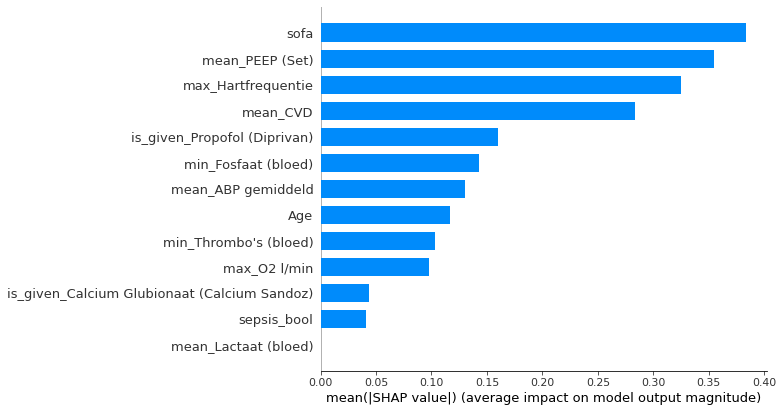

In [ ]:
present=False

explainer = shap.TreeExplainer(CB_treat)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train,plot_type="bar")

##### Propensity training set matching

In [ ]:
train_AF_dataset_match = train_AF_dataset[causal_cols+[causal_label]+["patientid"]].copy(deep=True).reset_index(drop=True)
train_AF_dataset_match["propensity_score_logit"]=0

In [ ]:
from scipy.special import logit
y_train_proba = CB_treat.predict_proba(train_AF_dataset_match[causal_cols])
y_train_logit = np.array([logit(xi) for xi in y_train_proba[:,1]])
train_AF_dataset_match.loc[:,"propensity_score_logit"]=y_train_logit

(array([ 63., 177., 231., 318., 455., 512., 558., 591., 488., 287.]),
 array([0.05084554, 0.14411612, 0.2373867 , 0.33065728, 0.42392785,
        0.51719843, 0.61046901, 0.70373959, 0.79701016, 0.89028074,
        0.98355132]),
 <BarContainer object of 10 artists>)

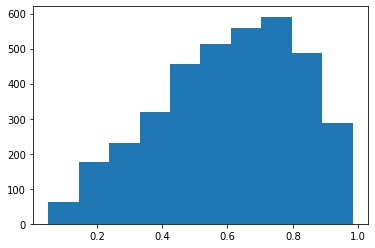

In [ ]:
plt.hist(CB_treat.predict_proba(X_test)[y_test==1][:,1])

<AxesSubplot:ylabel='Density'>

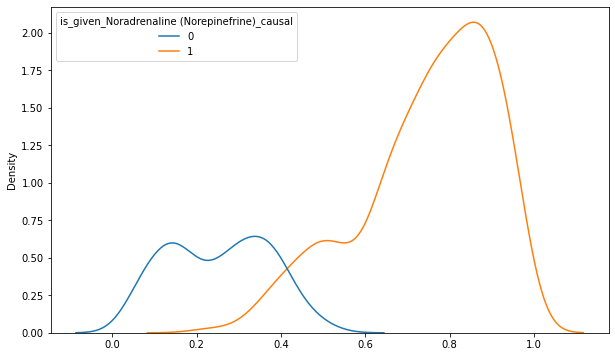

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,6))
sns.kdeplot(y_train_proba[:,1],hue=train_AF_dataset_match[causal_label])

<AxesSubplot:ylabel='Density'>

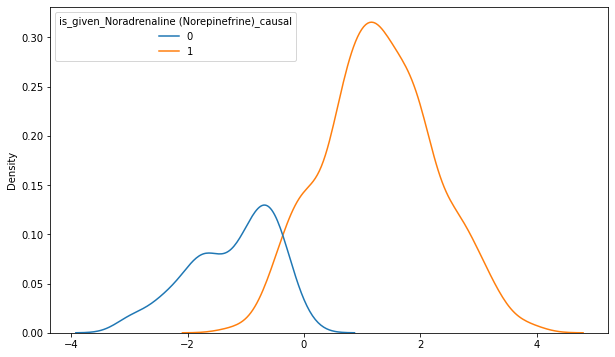

In [ ]:
plt.figure(figsize=(10,6))
sns.kdeplot(y_train_logit,hue=train_AF_dataset_match[causal_label])

In [ ]:
one_to_one_matching = False
multiple_exact = 1 if one_to_one_matching else 1

In [ ]:
from sklearn.neighbors import NearestNeighbors

NO_NOR_train_match = train_AF_dataset_match[train_AF_dataset_match[causal_label] == 0].copy(deep=True)
NO_NOR_train_match = NO_NOR_train_match.reset_index(drop=True)
NOR_train_match = train_AF_dataset_match[train_AF_dataset_match[causal_label] == 1].copy(deep=True)
NOR_train_match = NOR_train_match.reset_index(drop=True)

Neighbours = len(NO_NOR_train_match) if one_to_one_matching else multiple_exact

knn = NearestNeighbors(n_neighbors=Neighbours)# , p = 2, radius=np.std(y_train_logit) * 0.25)
knn.fit(NO_NOR_train_match[['propensity_score_logit']].to_numpy())
      

matched_element_arr = np.zeros((len(NOR_train_match),multiple_exact))
j = 0
if one_to_one_matching:
    for row in NOR_train_match.iterrows():
        distance,indexes = knn.kneighbors(np.reshape([row[1].propensity_score_logit],(-1,1)),n_neighbors=Neighbours)

        for idx in indexes[0,:]:
            if idx not in matched_element_arr[:,0]:
                matched_element_arr[j,0] = idx
                break
        j = j+1
        
else:
    for row in NOR_train_match.iterrows():
        distance,indexes = knn.kneighbors(np.reshape([row[1].propensity_score_logit],(-1,1)),n_neighbors=Neighbours)
        for i in range(multiple_exact):
            matched_element_arr[j,i] = indexes[0,i]
        
        j = j+1

if one_to_one_matching:  
    all_matched_data = pd.concat([train_AF_dataset_match[train_AF_dataset_match[causal_label] == 1], NO_NOR_train_match.iloc[matched_element_arr[:,0]]])
else:
    all_matched_data = pd.concat([train_AF_dataset_match[train_AF_dataset_match[causal_label] == 1], NO_NOR_train_match.iloc[matched_element_arr[:,0]]])
    for i in range(multiple_exact-1):
        all_matched_data = pd.concat([all_matched_data, NO_NOR_train_match.iloc[matched_element_arr[:,i]]])
        
all_matched_data = all_matched_data.drop_duplicates("patientid")

In [ ]:
print("")
print("BALANCE")
print(classification_report(all_matched_data[causal_label],CB_treat.predict(all_matched_data[causal_cols]),target_names=["NO "+causal,causal]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_treat, Pool(data=all_matched_data[causal_cols],label=all_matched_data[causal_label]), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(all_matched_data[causal_label],CB_treat.predict(all_matched_data[causal_cols])),4)))
print(50*"=")


BALANCE
              precision    recall  f1-score   support

      NO NOR       0.33      0.92      0.48        26
         NOR       1.00      0.91      0.95       536

    accuracy                           0.91       562
   macro avg       0.66      0.92      0.72       562
weighted avg       0.97      0.91      0.93       562



AUC = 0.9668
MCC = 0.5196


<AxesSubplot:ylabel='Density'>

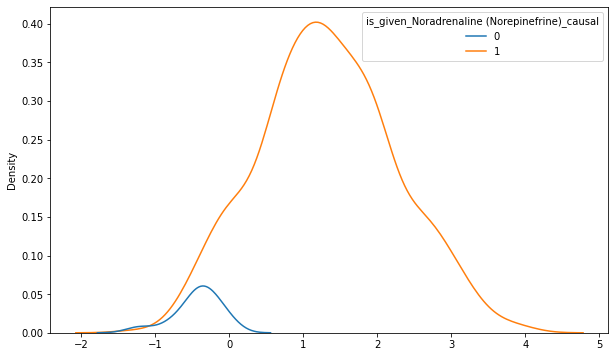

In [ ]:
from scipy.special import logit
y_train_proba = CB_treat.predict_proba(all_matched_data[causal_cols])
y_train_logit = np.array([logit(xi) for xi in y_train_proba[:,1]])

plt.figure(figsize=(10,6))
sns.kdeplot(y_train_logit,hue=all_matched_data[causal_label])

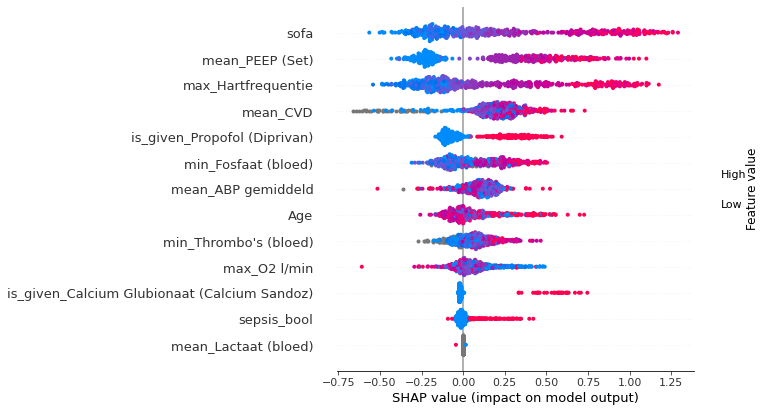

In [ ]:
present=False

explainer = shap.TreeExplainer(CB_treat)
shap_values = explainer.shap_values(all_matched_data[causal_cols])
shap.summary_plot(shap_values, all_matched_data[causal_cols],show=False)

In [ ]:
#train_AF_dataset_temp = pd.DataFrame({})
#for adm in all_matched_data.stay_id:
    #train_AF_dataset_temp = train_AF_dataset_temp.append(train_AF_dataset[train_AF_dataset.stay_id==adm])
train_AF_dataset_temp = train_AF_dataset[train_AF_dataset.patientid.isin(all_matched_data.patientid)].copy(deep=True)

In [ ]:
train_AF_dataset_temp["AF_"+causal]=""
train_AF_dataset_temp.loc[(train_AF_dataset_temp[causal_label]==0) & (train_AF_dataset_temp.AF==0),"AF_"+causal]=causal+" = 0 | AF = 0"
train_AF_dataset_temp.loc[(train_AF_dataset_temp[causal_label]==1) & (train_AF_dataset_temp.AF==0),"AF_"+causal]=causal+" = 1 | AF = 0"
train_AF_dataset_temp.loc[(train_AF_dataset_temp[causal_label]==0) & (train_AF_dataset_temp.AF==1),"AF_"+causal]=causal+" = 0 | AF = 1"
train_AF_dataset_temp.loc[(train_AF_dataset_temp[causal_label]==1) & (train_AF_dataset_temp.AF==1),"AF_"+causal]=causal+" = 1 | AF = 1"

In [ ]:
plot = False
if plot:
    for col in all_matched_data.columns.drop(["admissionid"]):
        try:
            plt.figure(figsize=(10,6))
            sns.kdeplot(train_AF_dataset_temp[train_AF_dataset_temp["AF_"+causal]==causal+" = 0 | AF = 0"][col],color="blue",label=causal+" = 0 | AF = 0")
            sns.kdeplot(train_AF_dataset_temp[train_AF_dataset_temp["AF_"+causal]==causal+" = 1 | AF = 0"][col],color="red",label=causal+" = 1 | AF = 0")
            sns.kdeplot(train_AF_dataset_temp[train_AF_dataset_temp["AF_"+causal]==causal+" = 0 | AF = 1"][col],color="green",label=causal+" = 0 | AF = 1")
            sns.kdeplot(train_AF_dataset_temp[train_AF_dataset_temp["AF_"+causal]==causal+" = 1 | AF = 1"][col],color="orange",label=causal+" = 1 | AF = 1")
            plt.legend()
            plt.plot()
        except:
            1+1

In [ ]:
train_AF_dataset = train_AF_dataset_temp

## Causality start

In [ ]:
causal_cols = obj_causal_cols+feature_columns
balance_test = True
balance_train = False
test_inter_treatment_balance = True
train_inter_treatment_balance = False
random_state_seed = 42
combo_eval = True

if causal == "NOR":
    # balanced by undersampling
    if balance_train and undersample_check(causal,1,train_AF_dataset):
        T1_nor_train_dataset = NOR_dataset(1,train_AF_dataset,1)
    elif balance_train:
        T1_nor_train_dataset = NOR_dataset(1,train_AF_dataset,0)
    else:
        T1_nor_train_dataset =  train_AF_dataset[train_AF_dataset['is_given_Noradrenaline (Norepinefrine)_causal']==1]
        
    if balance_test and undersample_check(causal,1,test_AF_dataset):
        T1_nor_test_dataset = NOR_dataset(1,test_AF_dataset,1)
    elif balance_test:
        T1_nor_test_dataset = NOR_dataset(1,test_AF_dataset,0)
    else:
        T1_nor_test_dataset = test_AF_dataset[test_AF_dataset['is_given_Noradrenaline (Norepinefrine)_causal']==1]

    if balance_train and undersample_check(causal,0,train_AF_dataset):
        T0_nor_train_dataset = NOR_dataset(0,train_AF_dataset,1)
    elif balance_train:
        T0_nor_train_dataset = NOR_dataset(0,train_AF_dataset,0)
    else:
        T0_nor_train_dataset = train_AF_dataset[train_AF_dataset['is_given_Noradrenaline (Norepinefrine)_causal']==0]
        
    if balance_test and undersample_check(causal,0,test_AF_dataset):
        T0_nor_test_dataset = NOR_dataset(0,test_AF_dataset,1)
    elif balance_test:
        T0_nor_test_dataset = NOR_dataset(0,test_AF_dataset,0)
    else:
        T0_nor_test_dataset = test_AF_dataset[test_AF_dataset['is_given_Noradrenaline (Norepinefrine)_causal']==0]
        
    if test_inter_treatment_balance:
        if (len(T0_nor_test_dataset[T0_nor_test_dataset.AF==1])>=len(T1_nor_test_dataset[T1_nor_test_dataset.AF==1])) & (len(T0_nor_test_dataset[T0_nor_test_dataset.AF==0])>=len(T1_nor_test_dataset[T1_nor_test_dataset.AF==0])):
            
            T0_nor_test_dataset = T0_nor_test_dataset[T0_nor_test_dataset.AF==1].sample(len(T1_nor_test_dataset[T1_nor_test_dataset.AF==1]),random_state=random_state_seed).append(T0_nor_test_dataset[T0_nor_test_dataset.AF==0].sample(len(T1_nor_test_dataset[T1_nor_test_dataset.AF==0]),random_state=random_state_seed))
        
        elif (len(T0_nor_test_dataset[T0_nor_test_dataset.AF==1])<=len(T1_nor_test_dataset[T1_nor_test_dataset.AF==1])) & (len(T0_nor_test_dataset[T0_nor_test_dataset.AF==0])>=len(T1_nor_test_dataset[T1_nor_test_dataset.AF==0])):
            
            T1_nor_test_dataset = T1_nor_test_dataset[T1_nor_test_dataset.AF==1].sample(len(T0_nor_test_dataset[T0_nor_test_dataset.AF==1]),random_state=random_state_seed).append(T1_nor_test_dataset[T1_nor_test_dataset.AF==0])
            T0_nor_test_dataset = T0_nor_test_dataset[T0_nor_test_dataset.AF==0].sample(len(T1_nor_test_dataset[T1_nor_test_dataset.AF==0]),random_state=random_state_seed).append(T0_nor_test_dataset[T0_nor_test_dataset.AF==1])
            
        elif (len(T0_nor_test_dataset[T0_nor_test_dataset.AF==1])>=len(T1_nor_test_dataset[T1_nor_test_dataset.AF==1])) & (len(T0_nor_test_dataset[T0_nor_test_dataset.AF==0])<=len(T1_nor_test_dataset[T1_nor_test_dataset.AF==0])):
            
            T1_nor_test_dataset = T1_nor_test_dataset[T1_nor_test_dataset.AF==0].sample(len(T0_nor_test_dataset[T0_nor_test_dataset.AF==0]),random_state=random_state_seed).append(T1_nor_test_dataset[T1_nor_test_dataset.AF==1])
            T0_nor_test_dataset = T0_nor_test_dataset[T0_nor_test_dataset.AF==1].sample(len(T1_nor_test_dataset[T1_nor_test_dataset.AF==1]),random_state=random_state_seed).append(T0_nor_test_dataset[T0_nor_test_dataset.AF==0])
        
        else:
            
            T1_nor_test_dataset = T1_nor_test_dataset[T1_nor_test_dataset.AF==1].sample(len(T0_nor_test_dataset[T0_nor_test_dataset.AF==1]),random_state=random_state_seed).append(T1_nor_test_dataset[T1_nor_test_dataset.AF==0].sample(len(T0_nor_test_dataset[T0_nor_test_dataset.AF==0]),random_state=random_state_seed))
     
    if train_inter_treatment_balance:
        if (len(T0_nor_train_dataset[T0_nor_train_dataset.AF==1])>len(T1_nor_train_dataset[T1_nor_train_dataset.AF==1])) & (len(T0_nor_train_dataset[T0_nor_train_dataset.AF==0])>len(T1_nor_train_dataset[T1_nor_train_dataset.AF==0])):
            
            T0_nor_train_dataset = T0_nor_train_dataset[T0_nor_train_dataset.AF==1].sample(len(T1_nor_train_dataset[T1_nor_train_dataset.AF==1]),random_state=random_state_seed).append(T0_nor_train_dataset[T0_nor_train_dataset.AF==0].sample(len(T1_nor_train_dataset[T1_nor_train_dataset.AF==0]),random_state=random_state_seed))
        
        elif (len(T0_nor_train_dataset[T0_nor_train_dataset.AF==1])<len(T1_nor_train_dataset[T1_nor_train_dataset.AF==1])) & (len(T0_nor_train_dataset[T0_nor_train_dataset.AF==0])>len(T1_nor_train_dataset[T1_nor_train_dataset.AF==0])):
            
            T1_nor_train_dataset = T1_nor_train_dataset[T1_nor_train_dataset.AF==1].sample(len(T0_nor_train_dataset[T0_nor_train_dataset.AF==1]),random_state=random_state_seed).append(T1_nor_train_dataset[T1_nor_train_dataset.AF==0])
            T0_nor_train_dataset = T0_nor_train_dataset[T0_nor_train_dataset.AF==0].sample(len(T1_nor_train_dataset[T1_nor_train_dataset.AF==0]),random_state=random_state_seed).append(T0_nor_train_dataset[T0_nor_train_dataset.AF==1])
            
        elif (len(T0_nor_train_dataset[T0_nor_train_dataset.AF==1])>len(T1_nor_train_dataset[T1_nor_train_dataset.AF==1])) & (len(T0_nor_train_dataset[T0_nor_train_dataset.AF==0])<len(T1_nor_train_dataset[T1_nor_train_dataset.AF==0])):
            
            T1_nor_train_dataset = T1_nor_train_dataset[T1_nor_train_dataset.AF==0].sample(len(T0_nor_train_dataset[T0_nor_train_dataset.AF==0]),random_state=random_state_seed).append(T1_nor_train_dataset[T1_nor_train_dataset.AF==1])
            T0_nor_train_dataset = T0_nor_train_dataset[T0_nor_train_dataset.AF==1].sample(len(T1_nor_train_dataset[T1_nor_train_dataset.AF==1]),random_state=random_state_seed).append(T0_nor_train_dataset[T0_nor_train_dataset.AF==0])
        
        else:
            
            T1_nor_train_dataset = T1_nor_train_dataset[T1_nor_train_dataset.AF==1].sample(len(T0_nor_train_dataset[T0_nor_train_dataset.AF==1]),random_state=random_state_seed).append(T1_nor_train_dataset[T1_nor_train_dataset.AF==0].sample(len(T0_nor_train_dataset[T0_nor_train_dataset.AF==0]),random_state=random_state_seed))
    
    X_train_T1 = T1_nor_train_dataset[(T1_nor_train_dataset['is_given_Noradrenaline (Norepinefrine)_causal']==1)][causal_cols]
    X_test_T1 = T1_nor_test_dataset[(T1_nor_test_dataset['is_given_Noradrenaline (Norepinefrine)_causal']==1)][causal_cols]
    y_train_T1 = T1_nor_train_dataset[(T1_nor_train_dataset['is_given_Noradrenaline (Norepinefrine)_causal']==1)].AF
    y_test_T1 = T1_nor_test_dataset[(T1_nor_test_dataset['is_given_Noradrenaline (Norepinefrine)_causal']==1)].AF
    
    X_train_T0 = T0_nor_train_dataset[(T0_nor_train_dataset['is_given_Noradrenaline (Norepinefrine)_causal']==0)][causal_cols]
    X_test_T0 = T0_nor_test_dataset[(T0_nor_test_dataset['is_given_Noradrenaline (Norepinefrine)_causal']==0)][causal_cols]
    y_train_T0 = T0_nor_train_dataset[(T0_nor_train_dataset['is_given_Noradrenaline (Norepinefrine)_causal']==0)].AF
    y_test_T0 = T0_nor_test_dataset[(T0_nor_test_dataset['is_given_Noradrenaline (Norepinefrine)_causal']==0)].AF

elif causal == "PEEP":
    # balanced by undersampling
    if balance_train and undersample_check(causal,1,train_AF_dataset):
        T1_peep_train_dataset = PEEP_dataset(1,train_AF_dataset,1)
    elif balance_train:
        T1_peep_train_dataset = PEEP_dataset(1,train_AF_dataset,0)
    else:
        T1_peep_train_dataset = train_AF_dataset[train_AF_dataset['mean_PEEP (Set)_causal']>=PEEP_setting]
        
    if balance_test and undersample_check(causal,1,test_AF_dataset):
        T1_peep_test_dataset = PEEP_dataset(1,test_AF_dataset,1)
    elif balance_test:
        T1_peep_test_dataset = PEEP_dataset(1,test_AF_dataset,0)
    else:
        T1_peep_test_dataset = test_AF_dataset[test_AF_dataset['mean_PEEP (Set)_causal']>=PEEP_setting]
    
    if balance_train and undersample_check(causal,0,train_AF_dataset):
         T0_peep_train_dataset = PEEP_dataset(0,train_AF_dataset,1)
    elif balance_train:
        T0_peep_train_dataset = PEEP_dataset(0,train_AF_dataset,0)
    else:
        T0_peep_train_dataset = train_AF_dataset[train_AF_dataset['mean_PEEP (Set)_causal']<PEEP_setting]
    
    if balance_test and undersample_check(causal,0,test_AF_dataset):
        T0_peep_test_dataset = PEEP_dataset(0,test_AF_dataset,1)
    elif balance_test:
        T0_peep_test_dataset = PEEP_dataset(0,test_AF_dataset,0)
    else:
        T0_peep_test_dataset = test_AF_dataset[test_AF_dataset['mean_PEEP (Set)_causal']<PEEP_setting]
    
    if test_inter_treatment_balance:
        if (len(T0_peep_test_dataset[T0_peep_test_dataset.AF==1])>len(T1_peep_test_dataset[T1_peep_test_dataset.AF==1])) & (len(T0_peep_test_dataset[T0_peep_test_dataset.AF==0])>len(T1_peep_test_dataset[T1_peep_test_dataset.AF==0])):
            
            T0_peep_test_dataset = T0_peep_test_dataset[T0_peep_test_dataset.AF==1].sample(len(T1_peep_test_dataset[T1_peep_test_dataset.AF==1]),random_state=random_state_seed).append(T0_peep_test_dataset[T0_peep_test_dataset.AF==0].sample(len(T1_peep_test_dataset[T1_peep_test_dataset.AF==0]),random_state=random_state_seed))
        
        elif (len(T0_peep_test_dataset[T0_peep_test_dataset.AF==1])<len(T1_peep_test_dataset[T1_peep_test_dataset.AF==1])) & (len(T0_peep_test_dataset[T0_peep_test_dataset.AF==0])>len(T1_peep_test_dataset[T1_peep_test_dataset.AF==0])):
            
            T1_peep_test_dataset = T1_peep_test_dataset[T1_peep_test_dataset.AF==1].sample(len(T0_peep_test_dataset[T0_peep_test_dataset.AF==1]),random_state=random_state_seed).append(T1_peep_test_dataset[T1_peep_test_dataset.AF==0])
            T0_peep_test_dataset = T0_peep_test_dataset[T0_peep_test_dataset.AF==0].sample(len(T1_peep_test_dataset[T1_peep_test_dataset.AF==0]),random_state=random_state_seed).append(T0_peep_test_dataset[T0_peep_test_dataset.AF==1])
            
        elif (len(T0_peep_test_dataset[T0_peep_test_dataset.AF==1])>len(T1_peep_test_dataset[T1_peep_test_dataset.AF==1])) & (len(T0_peep_test_dataset[T0_peep_test_dataset.AF==0])<len(T1_peep_test_dataset[T1_peep_test_dataset.AF==0])):
            
            T1_peep_test_dataset = T1_peep_test_dataset[T1_peep_test_dataset.AF==0].sample(len(T0_peep_test_dataset[T0_peep_test_dataset.AF==0]),random_state=random_state_seed).append(T1_peep_test_dataset[T1_peep_test_dataset.AF==1])
            T0_peep_test_dataset = T0_peep_test_dataset[T0_peep_test_dataset.AF==1].sample(len(T1_peep_test_dataset[T1_peep_test_dataset.AF==1]),random_state=random_state_seed).append(T0_peep_test_dataset[T0_peep_test_dataset.AF==0])
        
        else:
            
            T1_peep_test_dataset = T1_peep_test_dataset[T1_peep_test_dataset.AF==1].sample(len(T0_peep_test_dataset[T0_peep_test_dataset.AF==1]),random_state=random_state_seed).append(T1_peep_test_dataset[T1_peep_test_dataset.AF==0].sample(len(T0_peep_test_dataset[T0_peep_test_dataset.AF==0]),random_state=random_state_seed))
    
    if train_inter_treatment_balance:
        if (len(T0_peep_train_dataset[T0_peep_train_dataset.AF==1])>len(T1_peep_train_dataset[T1_peep_train_dataset.AF==1])) & (len(T0_peep_train_dataset[T0_peep_train_dataset.AF==0])>len(T1_peep_train_dataset[T1_peep_train_dataset.AF==0])):
            
            T0_peep_train_dataset = T0_peep_train_dataset[T0_peep_train_dataset.AF==1].sample(len(T1_peep_train_dataset[T1_peep_train_dataset.AF==1]),random_state=random_state_seed).append(T0_peep_train_dataset[T0_peep_train_dataset.AF==0].sample(len(T1_peep_train_dataset[T1_peep_train_dataset.AF==0]),random_state=random_state_seed))
        
        elif (len(T0_peep_train_dataset[T0_peep_train_dataset.AF==1])<len(T1_peep_train_dataset[T1_peep_train_dataset.AF==1])) & (len(T0_peep_train_dataset[T0_peep_train_dataset.AF==0])>len(T1_peep_train_dataset[T1_peep_train_dataset.AF==0])):
            
            T1_peep_train_dataset = T1_peep_train_dataset[T1_peep_train_dataset.AF==1].sample(len(T0_peep_train_dataset[T0_peep_train_dataset.AF==1]),random_state=random_state_seed).append(T1_peep_train_dataset[T1_peep_train_dataset.AF==0])
            T0_peep_train_dataset = T0_peep_train_dataset[T0_peep_train_dataset.AF==0].sample(len(T1_peep_train_dataset[T1_peep_train_dataset.AF==0]),random_state=random_state_seed).append(T0_peep_train_dataset[T0_peep_train_dataset.AF==1])
            
        elif (len(T0_peep_train_dataset[T0_peep_train_dataset.AF==1])>len(T1_peep_train_dataset[T1_peep_train_dataset.AF==1])) & (len(T0_peep_train_dataset[T0_peep_train_dataset.AF==0])<len(T1_peep_train_dataset[T1_peep_train_dataset.AF==0])):
            
            T1_peep_train_dataset = T1_peep_train_dataset[T1_peep_train_dataset.AF==0].sample(len(T0_peep_train_dataset[T0_peep_train_dataset.AF==0]),random_state=random_state_seed).append(T1_peep_train_dataset[T1_peep_train_dataset.AF==1])
            T0_peep_train_dataset = T0_peep_train_dataset[T0_peep_train_dataset.AF==1].sample(len(T1_peep_train_dataset[T1_peep_train_dataset.AF==1]),random_state=random_state_seed).append(T0_peep_train_dataset[T0_peep_train_dataset.AF==0])
        
        else:
            
            T1_peep_train_dataset = T1_peep_train_dataset[T1_peep_train_dataset.AF==1].sample(len(T0_peep_train_dataset[T0_peep_train_dataset.AF==1]),random_state=random_state_seed).append(T1_peep_train_dataset[T1_peep_train_dataset.AF==0].sample(len(T0_peep_train_dataset[T0_peep_train_dataset.AF==0]),random_state=random_state_seed))
    
    
    X_train_T1 = T1_peep_train_dataset[(T1_peep_train_dataset['mean_PEEP (Set)_causal']>=PEEP_setting)][causal_cols]
    X_test_T1 = T1_peep_test_dataset[(T1_peep_test_dataset['mean_PEEP (Set)_causal']>=PEEP_setting)][causal_cols]
    y_train_T1 = T1_peep_train_dataset[(T1_peep_train_dataset['mean_PEEP (Set)_causal']>=PEEP_setting)].AF
    y_test_T1 = T1_peep_test_dataset[(T1_peep_test_dataset['mean_PEEP (Set)_causal']>=PEEP_setting)].AF
    
    X_train_T0 = T0_peep_train_dataset[T0_peep_train_dataset['mean_PEEP (Set)_causal']<PEEP_setting][causal_cols]
    X_test_T0 = T0_peep_test_dataset[T0_peep_test_dataset['mean_PEEP (Set)_causal']<PEEP_setting][causal_cols]
    y_train_T0 = T0_peep_train_dataset[T0_peep_train_dataset['mean_PEEP (Set)_causal']<PEEP_setting].AF
    y_test_T0 = T0_peep_test_dataset[T0_peep_test_dataset['mean_PEEP (Set)_causal']<PEEP_setting].AF

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [58]:
add_nan_features = False
if causal == "NOR":
    possible_NaN_features = ['mean_Lactaat (bloed)', 'mean_ABP gemiddeld', 'max_O2 l/min','min_Fosfaat (bloed)', 'max_Hartfrequentie', 'min_Thrombo\'s (bloed)', 'mean_CVD']
else:
    possible_NaN_features = ['mean_Ademfrequentie Monitor', 'mean_pCO2 (bloed)', 'mean_pH (bloed)',
       'max_O2 l/min','min_Fosfaat (bloed)',  'min_Thrombo\'s (bloed)', 'fluidout', 'mean_CVD']

X_train_T1_lin_reg = X_train_T1.copy(deep=True)
X_test_T1_lin_reg = X_test_T1.copy(deep=True)
X_train_T0_lin_reg = X_train_T0.copy(deep=True)
X_test_T0_lin_reg = X_test_T0.copy(deep=True)

if add_nan_features:
    for feat in possible_NaN_features:
        X_train_T1_lin_reg[feat+"_NaN"]=0
        X_train_T1_lin_reg.loc[X_train_T1_lin_reg[feat].isna(),feat+"_NaN"]=1

        X_test_T1_lin_reg[feat+"_NaN"]=0
        X_test_T1_lin_reg.loc[X_test_T1_lin_reg[feat].isna(),feat+"_NaN"]=1

        X_train_T0_lin_reg[feat+"_NaN"]=0
        X_train_T0_lin_reg.loc[X_train_T0_lin_reg[feat].isna(),feat+"_NaN"]=1

        X_test_T0_lin_reg[feat+"_NaN"]=0
        X_test_T0_lin_reg.loc[X_test_T0_lin_reg[feat].isna(),feat+"_NaN"]=1


    
X_train_T1_lin_reg = X_train_T1_lin_reg.fillna(0)
X_test_T1_lin_reg = X_test_T1_lin_reg.fillna(0)
X_train_T0_lin_reg = X_train_T0_lin_reg.fillna(0)
X_test_T0_lin_reg = X_test_T0_lin_reg.fillna(0)  
    
X_test_ITE_lin_reg = X_test_T1_lin_reg.append(X_test_T0_lin_reg).sample(len(X_test_T1_lin_reg)+len(X_test_T0_lin_reg),random_state=5)

catboost_X_train_T0 = X_train_T0#.fillna(X_train_T0.mean())#_lin_reg
catboost_X_test_T0 = X_test_T0#.fillna(X_test_T0.mean())#_lin_reg
catboost_X_train_T1 = X_train_T1#.fillna(X_train_T1.mean())#_lin_reg
catboost_X_test_T1 = X_test_T1#.fillna(X_test_T1.mean())#_lin_reg

X_test_ITE_catboost = catboost_X_test_T1.append(catboost_X_test_T0).sample(len(catboost_X_test_T1)+len(catboost_X_test_T0),random_state=5)

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [59]:
if causal == "NOR":
    X_train_C = T1_nor_train_dataset[(T1_nor_train_dataset['is_given_Noradrenaline (Norepinefrine)_causal']==1)][causal_cols+['is_given_Noradrenaline (Norepinefrine)_causal']]
    X_test_C = T1_nor_test_dataset[(T1_nor_test_dataset['is_given_Noradrenaline (Norepinefrine)_causal']==1)][causal_cols+['is_given_Noradrenaline (Norepinefrine)_causal']]
    y_train_C = T1_nor_train_dataset[(T1_nor_train_dataset['is_given_Noradrenaline (Norepinefrine)_causal']==1)].AF
    y_test_C = T1_nor_test_dataset[(T1_nor_test_dataset['is_given_Noradrenaline (Norepinefrine)_causal']==1)].AF

    X_train_C = X_train_C.append(T0_nor_train_dataset[(T0_nor_train_dataset['is_given_Noradrenaline (Norepinefrine)_causal']==0)][causal_cols+['is_given_Noradrenaline (Norepinefrine)_causal']])
    X_test_C = X_test_C.append(T0_nor_test_dataset[(T0_nor_test_dataset['is_given_Noradrenaline (Norepinefrine)_causal']==0)][causal_cols+['is_given_Noradrenaline (Norepinefrine)_causal']])
    y_train_C = y_train_C.append(T0_nor_train_dataset[(T0_nor_train_dataset['is_given_Noradrenaline (Norepinefrine)_causal']==0)].AF)
    y_test_C = y_test_C.append(T0_nor_test_dataset[(T0_nor_test_dataset['is_given_Noradrenaline (Norepinefrine)_causal']==0)].AF)

    X_test_C_T1 = X_test_C.copy(deep=True)
    X_test_C_T1.loc[:,'is_given_Noradrenaline (Norepinefrine)_causal']=1
    X_test_C_T0 = X_test_C.copy(deep=True)
    X_test_C_T0.loc[:,'is_given_Noradrenaline (Norepinefrine)_causal']=0
    
else:
    X_train_C = T1_peep_train_dataset[(T1_peep_train_dataset['PEEP_causal_treatment']==1)][causal_cols+['PEEP_causal_treatment']]
    X_test_C = T1_peep_test_dataset[(T1_peep_test_dataset['PEEP_causal_treatment']==1)][causal_cols+['PEEP_causal_treatment']]
    y_train_C = T1_peep_train_dataset[(T1_peep_train_dataset['PEEP_causal_treatment']==1)].AF
    y_test_C = T1_peep_test_dataset[(T1_peep_test_dataset['PEEP_causal_treatment']==1)].AF

    X_train_C = X_train_C.append(T0_peep_train_dataset[(T0_peep_train_dataset['PEEP_causal_treatment']==0)][causal_cols+['PEEP_causal_treatment']])
    X_test_C = X_test_C.append(T0_peep_test_dataset[(T0_peep_test_dataset['PEEP_causal_treatment']==0)][causal_cols+['PEEP_causal_treatment']])
    y_train_C = y_train_C.append(T0_peep_train_dataset[(T0_peep_train_dataset['PEEP_causal_treatment']==0)].AF)
    y_test_C = y_test_C.append(T0_peep_test_dataset[(T0_peep_test_dataset['PEEP_causal_treatment']==0)].AF)

    X_test_C_T1 = X_test_C.copy(deep=True)
    X_test_C_T1.loc[:,'PEEP_causal_treatment']=1
    X_test_C_T0 = X_test_C.copy(deep=True)
    X_test_C_T0.loc[:,'PEEP_causal_treatment']=0

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [60]:
catboost_model = CatBoostClassifier
#catboost_model = CatBoostRegressor

if not combo_eval:
    T0_class_balance = [y_train_T0.sum()/len(y_train_T0),1-y_train_T0.sum()/len(y_train_T0)]
    CB_AF_T0 = catboost_model(verbose=False,iterations=250,class_weights=T0_class_balance)
    CB_AF_T0.fit(Pool(catboost_X_train_T0,y_train_T0))

    T1_class_balance = [y_train_T1.sum()/len(y_train_T1),1-y_train_T1.sum()/len(y_train_T1)]
    CB_AF_T1 = catboost_model(verbose=False,iterations=250,class_weights=T1_class_balance)
    CB_AF_T1.fit(catboost_X_train_T1,y_train_T1)


    #ITE = CB_AF_T1.predict(X_test_T1.append(X_test_T0))-CB_AF_T0.predict(X_test_T1.append(X_test_T0))

    #ITE = CB_AF_T1.predict(X_test_ITE)-CB_AF_T0.predict(X_test_ITE)
    ITE = CB_AF_T1.predict_proba(X_test_ITE_catboost)[:,1]-CB_AF_T0.predict_proba(X_test_ITE_catboost)[:,1]

    plt.figure()
    plt.hist(ITE)
    plt.plot()
    
    plt.figure()
    plt.hist(CB_AF_T1.predict_proba(X_test_ITE_catboost)[:,1],bins=np.arange(0,1,0.1),label='T1')
    plt.hist(CB_AF_T0.predict_proba(X_test_ITE_catboost)[:,1],bins=np.arange(0,1,0.1),label='T0',alpha=0.5)
    plt.legend()
    plt.title("ITE test set (probability)")
    plt.plot()
    
    plt.figure()
    explainer = shap.TreeExplainer(CB_AF_T0)
    shap_values = explainer.shap_values(X_test_ITE_catboost)
    shap.summary_plot(shap_values, X_test_ITE_catboost,show=False)
    
    plt.figure()
    explainer = shap.TreeExplainer(CB_AF_T1)
    shap_values = explainer.shap_values(X_test_ITE_catboost)
    shap.summary_plot(shap_values, X_test_ITE_catboost,show=False)

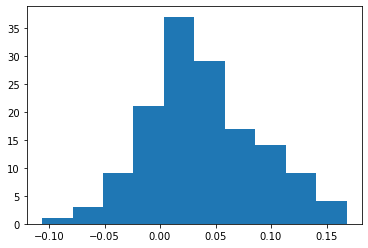

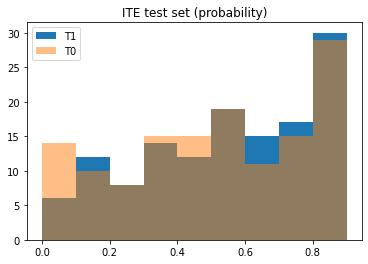

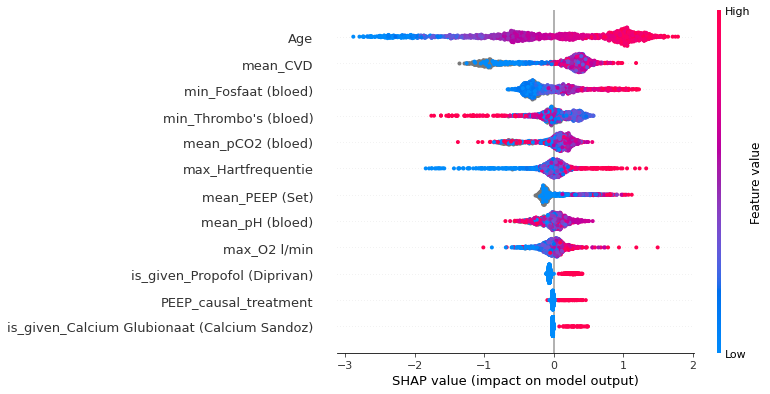

In [61]:
if combo_eval:
    C_class_balance = [y_train_C.sum()/len(y_train_C),1-y_train_C.sum()/len(y_train_C)]
    CB_AF_C = catboost_model(verbose=False,iterations=250,class_weights=C_class_balance)
    CB_AF_C.fit(X_train_C,y_train_C)

    ITE = CB_AF_C.predict_proba(X_test_C_T1)[:,1]-CB_AF_C.predict_proba(X_test_C_T0)[:,1]

    plt.figure()
    plt.hist(ITE)
    plt.plot()

    plt.figure()
    plt.hist(CB_AF_C.predict_proba(X_test_C_T1)[:,1],bins=np.arange(0,1,0.1),label='T1')
    plt.hist(CB_AF_C.predict_proba(X_test_C_T0)[:,1],bins=np.arange(0,1,0.1),label='T0',alpha=0.5)
    plt.legend()
    plt.title("ITE test set (probability)")
    plt.plot()
    
    plt.figure()
    explainer = shap.TreeExplainer(CB_AF_C)
    shap_values = explainer.shap_values(X_train_C)
    shap.summary_plot(shap_values, X_train_C,show=True)

In [62]:
if not combo_eval:
    print("")
    print("TRAIN PATIENTS T0")
    print(classification_report(y_train_T0,CB_AF_T0.predict(catboost_X_train_T0),target_names=["No-AF","AF"]))
    print("\n")
    (fpr, tpr, thresholds) = get_roc_curve(CB_AF_T0, Pool(data=catboost_X_train_T0,label=y_train_T0), plot=False)
    print("AUC = "+str(np.round(auc(fpr,tpr),4)))
    print("MCC = "+str(np.round(matthews_corrcoef(y_train_T0,CB_AF_T0.predict(catboost_X_train_T0)),4)))
    print(50*"=")

    print("TRAIN PATIENTS T1")
    print(classification_report(y_train_T1,CB_AF_T1.predict(catboost_X_train_T1),target_names=["No-AF","AF"]))
    print("\n")
    (fpr, tpr, thresholds) = get_roc_curve(CB_AF_T1, Pool(data=catboost_X_train_T1,label=y_train_T1), plot=False)
    print("AUC = "+str(np.round(auc(fpr,tpr),4)))
    print("MCC = "+str(np.round(matthews_corrcoef(y_train_T1,CB_AF_T1.predict(catboost_X_train_T1)),4)))
    print(50*"=")

    print("")
    print("TEST PATIENTS T0")
    print(classification_report(y_test_T0,CB_AF_T0.predict(catboost_X_test_T0),target_names=["No-AF","AF"]))
    print("\n")
    (fpr, tpr, thresholds) = get_roc_curve(CB_AF_T0, Pool(data=catboost_X_test_T0,label=y_test_T0), plot=False)
    print("AUC = "+str(np.round(auc(fpr,tpr),4)))
    print("MCC = "+str(np.round(matthews_corrcoef(y_test_T0,CB_AF_T0.predict(catboost_X_test_T0)),4)))
    print(50*"=")

    print("TEST PATIENTS T1")
    print(classification_report(y_test_T1,CB_AF_T1.predict(catboost_X_test_T1),target_names=["No-AF","AF"]))
    print("\n")
    (fpr, tpr, thresholds) = get_roc_curve(CB_AF_T1, Pool(data=catboost_X_test_T1,label=y_test_T1), plot=False)
    print("AUC = "+str(np.round(auc(fpr,tpr),4)))
    print("MCC = "+str(np.round(matthews_corrcoef(y_test_T1,CB_AF_T1.predict(catboost_X_test_T1)),4)))
    print(50*"=")

In [63]:
if combo_eval:
    print("")
    print("COMBO TRAIN PATIENTS T0")
    C_catboost_X_train_T0=catboost_X_train_T0
    C_catboost_X_train_T0[causal_label]=0
    print(classification_report(y_train_T0,CB_AF_C.predict(C_catboost_X_train_T0),target_names=["No-AF","AF"]))
    print("\n")
    (fpr, tpr, thresholds) = get_roc_curve(CB_AF_C, Pool(data=C_catboost_X_train_T0,label=y_train_T0), plot=False)
    print("AUC = "+str(np.round(auc(fpr,tpr),4)))
    print("MCC = "+str(np.round(matthews_corrcoef(y_train_T0,CB_AF_C.predict(C_catboost_X_train_T0)),4)))
    print(50*"=")

    print("COMBO TRAIN PATIENTS T1")
    C_catboost_X_train_T1=catboost_X_train_T1
    C_catboost_X_train_T1[causal_label]=0
    print(classification_report(y_train_T1,CB_AF_C.predict(C_catboost_X_train_T1),target_names=["No-AF","AF"]))
    print("\n")
    (fpr, tpr, thresholds) = get_roc_curve(CB_AF_C, Pool(data=C_catboost_X_train_T1,label=y_train_T1), plot=False)
    print("AUC = "+str(np.round(auc(fpr,tpr),4)))
    print("MCC = "+str(np.round(matthews_corrcoef(y_train_T1,CB_AF_C.predict(C_catboost_X_train_T1)),4)))
    print(50*"=")

    print("")
    print("COMBO TEST PATIENTS T0")
    C_catboost_X_test_T0=catboost_X_test_T0
    C_catboost_X_test_T0[causal_label]=0
    print(classification_report(y_test_T0,CB_AF_C.predict(C_catboost_X_test_T0),target_names=["No-AF","AF"]))
    print("\n")
    (fpr, tpr, thresholds) = get_roc_curve(CB_AF_C, Pool(data=C_catboost_X_test_T0,label=y_test_T0), plot=False)
    print("AUC = "+str(np.round(auc(fpr,tpr),4)))
    print("MCC = "+str(np.round(matthews_corrcoef(y_test_T0,CB_AF_C.predict(C_catboost_X_test_T0)),4)))
    print(50*"=")

    print("COMBO TEST PATIENTS T1")
    C_catboost_X_test_T1=catboost_X_test_T1
    C_catboost_X_test_T1[causal_label]=0
    print(classification_report(y_test_T1,CB_AF_C.predict(C_catboost_X_test_T1),target_names=["No-AF","AF"]))
    print("\n")
    (fpr, tpr, thresholds) = get_roc_curve(CB_AF_C, Pool(data=C_catboost_X_test_T1,label=y_test_T1), plot=False)
    print("AUC = "+str(np.round(auc(fpr,tpr),4)))
    print("MCC = "+str(np.round(matthews_corrcoef(y_test_T1,CB_AF_C.predict(C_catboost_X_test_T1)),4)))
    print(50*"=")


COMBO TRAIN PATIENTS T0
              precision    recall  f1-score   support

       No-AF       0.93      0.90      0.91       726
          AF       0.89      0.91      0.90       606

    accuracy                           0.91      1332
   macro avg       0.91      0.91      0.91      1332
weighted avg       0.91      0.91      0.91      1332



AUC = 0.9698
MCC = 0.8161
COMBO TRAIN PATIENTS T1
              precision    recall  f1-score   support

       No-AF       0.88      0.88      0.88        33
          AF       0.93      0.93      0.93        56

    accuracy                           0.91        89
   macro avg       0.90      0.90      0.90        89
weighted avg       0.91      0.91      0.91        89



AUC = 0.9816
MCC = 0.8074

COMBO TEST PATIENTS T0
              precision    recall  f1-score   support

       No-AF       0.81      0.72      0.76        36
          AF       0.75      0.83      0.79        36

    accuracy                           0.78        72

In [64]:
from sklearn.linear_model import LinearRegression, LogisticRegression
intercept = []
r2s = []
coefs = np.array([])
for i in range(10000):
    if i%500==0:
        print("\r Iteration "+str(i)+"/10000",end='')
    train_X_LinReg = X_test_ITE_lin_reg.reset_index(drop=True).sample(int(len(X_test_ITE_lin_reg)*0.67),random_state=i)
    train_Y_LinReg = ITE[train_X_LinReg.index.values]
    Lin_ITE = LinearRegression().fit(train_X_LinReg.values,train_Y_LinReg)
    #r2s.append(r2_score(ITE,Lin_ITE.predict(X_test_ITE.values)))
    intercept.append(Lin_ITE.intercept_)
    if len(coefs)==0:
        coefs = Lin_ITE.coef_
    else:
        coefs = np.vstack([coefs,Lin_ITE.coef_])
intercept = np.array(intercept)        

 Iteration 9500/10000

In [65]:
if causal == "PEEP":
    print("Causal: "+str(causal)+ " with peep setting = "+str(PEEP_setting)+". Test set is balanced = "+str(balance_test))
else:
    print("Causal: "+str(causal)+ ". Test set is balanced = "+str(balance_test))

quantile = p_values_null_coef(intercept)/100
if quantile > 0.5:
    p_value = 1-quantile
else:
    p_value = quantile
significant_string = "" if (np.round(p_value,3)>0.05) else 20*"-"+">  " 
print(significant_string+"AF: "+str(np.round(p_value,3)))
print("Intercept = "+str(np.mean(intercept))+" (+-"+str(np.std(intercept))+")")

for i in range(len(X_test_ITE_lin_reg.columns)):
    quantile = p_values_null_coef(coefs[:,i])/100
    if quantile > 0.5:
        p_value = 1-quantile
    else:
        p_value = quantile
    significant_string = "" if (np.round(p_value,3)>0.05) else 20*"-"+">  "
    print(significant_string+X_test_ITE_lin_reg.columns[i]+": "+str(np.round(p_value,3)))
    

Causal: PEEP with peep setting = 8. Test set is balanced = True
-------------------->  AF: 0.001
Intercept = 0.08715518074769193 (+-0.02656628651291619)
mean_pCO2 (bloed): 0.316
mean_pH (bloed): 0.278
-------------------->  is_given_Propofol (Diprivan): 0.0
-------------------->  Age: 0.016
max_O2 l/min: 0.223
min_Fosfaat (bloed): 0.41
-------------------->  is_given_Calcium Glubionaat (Calcium Sandoz): 0.018
max_Hartfrequentie: 0.09
min_Thrombo's (bloed): 0.2
mean_CVD: 0.067
-------------------->  mean_PEEP (Set): 0.039


In [75]:
if causal == "NOR":
    X_test_ITE_renamed = X_test_ITE_lin_reg.rename(columns={'mean_Lactaat (bloed)':'Mean blood lactate', 'slope_ABP gemiddeld':'Slope mean arterial blood pressure', 'sepsis_bool':'Sepsis',
           'is_given_Propofol (Diprivan)':'Is given Propofol (Diprivan)', 'max_O2 l/min':'Max O2 l/min',
           'min_Fosfaat (bloed)':'Min blood phosphate', 'is_given_Calcium Glubionaat (Calcium Sandoz)':'Is given Calcium Glubionaat',
           'max_Hartfrequentie':'Max heart frequeny', 'min_Thrombo\'s (bloed)':'Min platelets', 'fluidout':'Fluidout', 'mean_CVD':'Mean central venous pressure',
           'is_given_Noradrenaline (Norepinefrine)':'Is given Noradrenaline', 'mean_PEEP (Set)':'Mean PEEP Setting'}) 
else:
    X_test_ITE_renamed = X_test_ITE_lin_reg

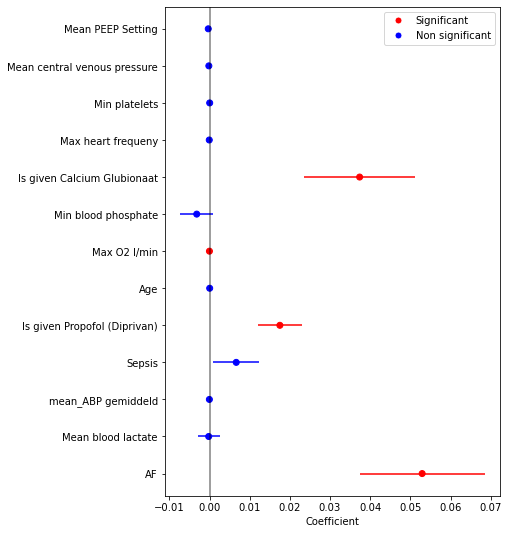

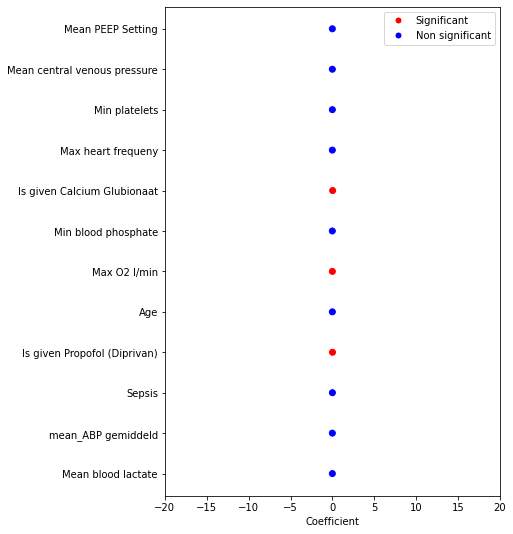

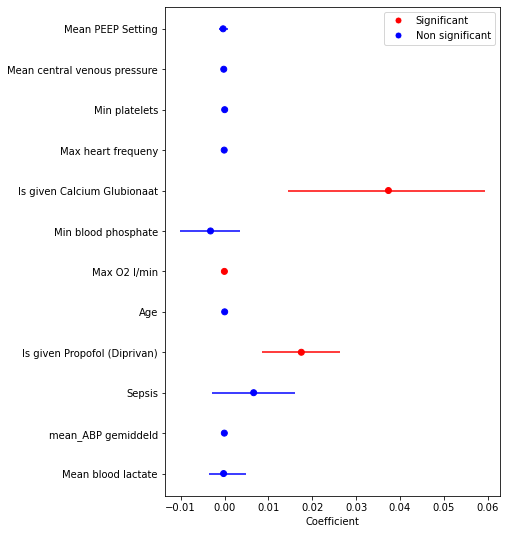

In [76]:
print_coef_std_int(coefs,intercept,X_test_ITE_renamed.columns)
print_coef_std(coefs,X_test_ITE_renamed.columns,20)
print_coef_std(coefs,X_test_ITE_renamed.columns,0)

## CausalTeShap

In [16]:
%load_ext autoreload
%autoreload 2

In [17]:
import sys
sys.path.append("../../causalteshap/")
from causalteshap import CausalTeShap

In [19]:
causal_selector = CausalTeShap(CatBoostClassifier,iterations=50,S_learner=True,balance_T_val=True,power_alpha=0.01,verbose=False)

X_matched, prev_propensity_auc, after_propensity_auc = causal_selector.propensity_matching(AF_dataset[obj_causal_cols+feature_columns],
                    AF_dataset.AF.values,AF_dataset[causal_label].values,index_ar = AF_dataset.patientid.values)

In [22]:
X

,mean_Lactaat (bloed),mean_ABP gemiddeld,sepsis_bool,sofa,is_given_Propofol (Diprivan),Age,max_O2 l/min,min_Fosfaat (bloed),is_given_Calcium Glubionaat (Calcium Sandoz),max_Hartfrequentie,min_Thrombo's (bloed),mean_CVD,is_given_Noradrenaline (Norepinefrine),mean_PEEP (Set)
3,NaN,69.875000,0,3.0,1,66.63,12.0,1.29,0,79.0,269.0,7.428571,0,4.0
10,NaN,74.916667,0,8.0,0,55.46,26.0,1.86,0,94.0,145.0,12.333333,1,0.0
14,NaN,69.416667,0,13.0,0,60.54,16.0,2.36,0,86.0,316.0,13.833333,1,5.0
15,NaN,50.062500,0,16.0,0,66.80,22.0,1.15,0,160.0,99.0,14.071429,1,5.0
22,NaN,77.076923,0,16.0,1,73.13,41.0,1.49,1,102.0,88.0,20.555556,1,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17571,NaN,69.916667,0,5.0,1,18.46,35.0,1.18,0,92.0,278.0,NaN,1,5.0
17573,NaN,84.857143,0,3.0,1,56.27,21.0,NaN,0,113.0,NaN,8.857143,1,5.0
17574,NaN,71.666667,1,16.0,1,71.99,35.0,2.03,1,113.0,433.0,25.000000,1,8.0
17576,NaN,77.600000,0,9.0,0,66.48,17.0,1.43,0,87.0,471.0,NaN,1,5.0


In [23]:
X_matched

X_or = AF_dataset[AF_dataset.patientid.isin(X_matched)]

X = X_or[obj_causal_cols+feature_columns]
y = X_or.AF
T = X_or[causal_label].values
                    


In [24]:
np.mean(X_or[X_or[causal_label]==1].AF.values)-np.mean(X_or[X_or[causal_label]==0].AF.values)

0.073207668465159

In [61]:
causal_selector = CausalTeShap(CatBoostClassifier,iterations=50,S_learner=True,balance_T_val=True,power_alpha=0.01,verbose=False)

causal_selector.fit(AF_dataset[obj_causal_cols+feature_columns],
                    AF_dataset.AF.values,AF_dataset[causal_label].values,
                    id_split_ar=AF_dataset[(AF_dataset.AF==1)|(AF_dataset.date_corresponds_to_AF_admid!=AF_dataset.patientid)].patientid.values,
                    id_ar=AF_dataset.patientid.values,
                    balance_T_val=True,
                    propensity_matching=True)#,
                    #propensity_exclude_columns = ['is_given_Noradrenaline (Norepinefrine)'])
                    #propensity_exclude_columns = ['mean_PEEP (Set)'])

In [62]:
causal_selector.show_all_causality_information()

Propensity matching was included in fitting - Propensity information: 

Before matching auc 	 | mean (std) = 0.9547 (0.0068)
After matching auc 	 | mean (std) = 0.6519 (0.0407)
T0 amount of class 1 samples 	 |  32 samples = 41.99% of all matched 76 samples
T1 amount of class 1 samples 	 | 89 samples = 62.89% of all matched 142 samples

Causality information:
TRAIN: 	 CATE = 0.044648079576516925 	| p-value = 0.02
VAL: 	 CATE = 0.12868655199069592 	| p-value = 0.0
CATE shap stats
----------------------------------------------------------------------
|                                              |      impact |   p_value |
|:---------------------------------------------|------------:|----------:|
| T                                            | 0.499042    |         0 |
| is_given_Calcium Glubionaat (Calcium Sandoz) | 0.000263691 |         0 |
T0 shap stats
----------------------------------------------------------------------
|                   |   impact |   p_value |
|:--------------

In [60]:
addendum_peep = "" if causal=="NOR" else "_setting_"+str(PEEP_setting)
causal_selector.export_results("results/causality/"+causal+"_uzgent"+addendum_peep+".csv")

In [ ]:
causal_selector.analyze_causality(False)

In [19]:
"""from sklearn.model_selection import train_test_split

#for set_peep in np.arange(5,12):
#    PEEP_setting = set_peep
if True:
    #causal_string_df = causal+("_setting_"+str(PEEP_setting))*(int(causal=="PEEP"))

    #if causal == "PEEP":
    #    AF_dataset['PEEP_causal_treatment']=0
    #    AF_dataset.loc[AF_dataset["mean_PEEP (Set)_causal"]>=PEEP_setting,"PEEP_causal_treatment"]=1

    causal_cols = obj_causal_cols+feature_columns
    balance_test = True
    balance_train = False
    test_inter_treatment_balance = False
    train_inter_treatment_balance = False
    combo_eval = True
    mean_ITEs = []
    std_ITEs = []
    train_std_ITEs = []
    train_mean_ITEs = []
    bootstrap_iterations = 30 #00
    shap_difs = np.array([])

    AF_T1_patients = np.array([])
    AF_T0_patients = np.array([])
    NO_AF_T0_patients = np.array([])
    NO_AF_T1_patients = np.array([])
    prop_before_list = np.array([])
    prop_after_list = np.array([])




    for i in tqdm(range(bootstrap_iterations)):
        RS_multiple = i
        random_state_seed = RS_multiple
        #the balancing is later, the stratification on AF makes sure that the proportion of AF to no AF stays the same and we do not lose this information by balancing the training or test set

        if distr_change:
            train_patientid,test_patientid = train_test_split(AF_dataset[(AF_dataset.AF==1)|(AF_dataset.date_corresponds_to_AF_admid!=AF_dataset.patientid)].patientid, test_size=0.20, random_state=RS_multiple) #0.33 test set
            train_AF_dataset = AF_dataset[(AF_dataset.patientid.isin(train_patientid))].copy(deep=True)
            test_AF_dataset =  AF_dataset[~(AF_dataset.patientid.isin(train_patientid))].copy(deep=True)

            if causal == "NOR":
                causal_cols.remove("is_given_Noradrenaline (Norepinefrine)")
                train_AF_dataset,prop_before,prop_after = propensity_preprocessing(train_AF_dataset,target=causal_label,features=causal_cols,index="patientid",RS=42)#,one_to_one_matching = False,multiple_exact=1)
                causal_cols.append("is_given_Noradrenaline (Norepinefrine)")
            else:
                causal_cols.remove("mean_PEEP (Set)")
                train_AF_dataset,prop_before,prop_after = propensity_preprocessing(train_AF_dataset,target=causal_label,features=causal_cols,index="patientid",RS=42)#,one_to_one_matching = False,multiple_exact=1)
                causal_cols.append("mean_PEEP (Set)")

            prop_after_list = np.append(prop_after_list,prop_after)
            prop_before_list = np.append(prop_before_list,prop_before)

        if causal == "NOR":
            # balanced by undersampling
            if balance_train and undersample_check(causal,1,train_AF_dataset):
                T1_nor_train_dataset = NOR_dataset(1,train_AF_dataset,1)
            elif balance_train:
                T1_nor_train_dataset = NOR_dataset(1,train_AF_dataset,0)
            else:
                T1_nor_train_dataset =  train_AF_dataset[train_AF_dataset['is_given_Noradrenaline (Norepinefrine)_causal']==1]

            if balance_test and undersample_check(causal,1,test_AF_dataset):
                T1_nor_test_dataset = NOR_dataset(1,test_AF_dataset,1)
            elif balance_test:
                T1_nor_test_dataset = NOR_dataset(1,test_AF_dataset,0)
            else:
                T1_nor_test_dataset = test_AF_dataset[test_AF_dataset['is_given_Noradrenaline (Norepinefrine)_causal']==1]

            if balance_train and undersample_check(causal,0,train_AF_dataset):
                T0_nor_train_dataset = NOR_dataset(0,train_AF_dataset,1)
            elif balance_train:
                T0_nor_train_dataset = NOR_dataset(0,train_AF_dataset,0)
            else:
                T0_nor_train_dataset = train_AF_dataset[train_AF_dataset['is_given_Noradrenaline (Norepinefrine)_causal']==0]

            if balance_test and undersample_check(causal,0,test_AF_dataset):
                T0_nor_test_dataset = NOR_dataset(0,test_AF_dataset,1)
            elif balance_test:
                T0_nor_test_dataset = NOR_dataset(0,test_AF_dataset,0)
            else:
                T0_nor_test_dataset = test_AF_dataset[test_AF_dataset['is_given_Noradrenaline (Norepinefrine)_causal']==0]

            if test_inter_treatment_balance:
                if (len(T0_nor_test_dataset[T0_nor_test_dataset.AF==1])>=len(T1_nor_test_dataset[T1_nor_test_dataset.AF==1])) & (len(T0_nor_test_dataset[T0_nor_test_dataset.AF==0])>=len(T1_nor_test_dataset[T1_nor_test_dataset.AF==0])):

                    T0_nor_test_dataset = pd.concat([T0_nor_test_dataset[T0_nor_test_dataset.AF==1].sample(len(T1_nor_test_dataset[T1_nor_test_dataset.AF==1]),random_state=random_state_seed),T0_nor_test_dataset[T0_nor_test_dataset.AF==0].sample(len(T1_nor_test_dataset[T1_nor_test_dataset.AF==0]),random_state=random_state_seed)])

                elif (len(T0_nor_test_dataset[T0_nor_test_dataset.AF==1])<=len(T1_nor_test_dataset[T1_nor_test_dataset.AF==1])) & (len(T0_nor_test_dataset[T0_nor_test_dataset.AF==0])>=len(T1_nor_test_dataset[T1_nor_test_dataset.AF==0])):

                    T1_nor_test_dataset = pd.concat([T1_nor_test_dataset[T1_nor_test_dataset.AF==1].sample(len(T0_nor_test_dataset[T0_nor_test_dataset.AF==1]),random_state=random_state_seed),T1_nor_test_dataset[T1_nor_test_dataset.AF==0]])
                    T0_nor_test_dataset = pd.concat([T0_nor_test_dataset[T0_nor_test_dataset.AF==0].sample(len(T1_nor_test_dataset[T1_nor_test_dataset.AF==0]),random_state=random_state_seed),T0_nor_test_dataset[T0_nor_test_dataset.AF==1]])

                elif (len(T0_nor_test_dataset[T0_nor_test_dataset.AF==1])>=len(T1_nor_test_dataset[T1_nor_test_dataset.AF==1])) & (len(T0_nor_test_dataset[T0_nor_test_dataset.AF==0])<=len(T1_nor_test_dataset[T1_nor_test_dataset.AF==0])):

                    T1_nor_test_dataset = pd.concat([T1_nor_test_dataset[T1_nor_test_dataset.AF==0].sample(len(T0_nor_test_dataset[T0_nor_test_dataset.AF==0]),random_state=random_state_seed),T1_nor_test_dataset[T1_nor_test_dataset.AF==1]])
                    T0_nor_test_dataset = pd.concat([T0_nor_test_dataset[T0_nor_test_dataset.AF==1].sample(len(T1_nor_test_dataset[T1_nor_test_dataset.AF==1]),random_state=random_state_seed),T0_nor_test_dataset[T0_nor_test_dataset.AF==0]])

                else:

                    T1_nor_test_dataset = pd.concat([T1_nor_test_dataset[T1_nor_test_dataset.AF==1].sample(len(T0_nor_test_dataset[T0_nor_test_dataset.AF==1]),random_state=random_state_seed),T1_nor_test_dataset[T1_nor_test_dataset.AF==0].sample(len(T0_nor_test_dataset[T0_nor_test_dataset.AF==0]),random_state=random_state_seed)])

            if train_inter_treatment_balance:
                if (len(T0_nor_train_dataset[T0_nor_train_dataset.AF==1])>len(T1_nor_train_dataset[T1_nor_train_dataset.AF==1])) & (len(T0_nor_train_dataset[T0_nor_train_dataset.AF==0])>len(T1_nor_train_dataset[T1_nor_train_dataset.AF==0])):

                    T0_nor_train_dataset = pd.concat([T0_nor_train_dataset[T0_nor_train_dataset.AF==1].sample(len(T1_nor_train_dataset[T1_nor_train_dataset.AF==1]),random_state=random_state_seed),T0_nor_train_dataset[T0_nor_train_dataset.AF==0].sample(len(T1_nor_train_dataset[T1_nor_train_dataset.AF==0]),random_state=random_state_seed)])

                elif (len(T0_nor_train_dataset[T0_nor_train_dataset.AF==1])<len(T1_nor_train_dataset[T1_nor_train_dataset.AF==1])) & (len(T0_nor_train_dataset[T0_nor_train_dataset.AF==0])>len(T1_nor_train_dataset[T1_nor_train_dataset.AF==0])):

                    T1_nor_train_dataset = pd.concat([T1_nor_train_dataset[T1_nor_train_dataset.AF==1].sample(len(T0_nor_train_dataset[T0_nor_train_dataset.AF==1]),random_state=random_state_seed),T1_nor_train_dataset[T1_nor_train_dataset.AF==0]])
                    T0_nor_train_dataset = pd.concat([T0_nor_train_dataset[T0_nor_train_dataset.AF==0].sample(len(T1_nor_train_dataset[T1_nor_train_dataset.AF==0]),random_state=random_state_seed),T0_nor_train_dataset[T0_nor_train_dataset.AF==1]])

                elif (len(T0_nor_train_dataset[T0_nor_train_dataset.AF==1])>len(T1_nor_train_dataset[T1_nor_train_dataset.AF==1])) & (len(T0_nor_train_dataset[T0_nor_train_dataset.AF==0])<len(T1_nor_train_dataset[T1_nor_train_dataset.AF==0])):

                    T1_nor_train_dataset = pd.concat([T1_nor_train_dataset[T1_nor_train_dataset.AF==0].sample(len(T0_nor_train_dataset[T0_nor_train_dataset.AF==0]),random_state=random_state_seed),T1_nor_train_dataset[T1_nor_train_dataset.AF==1]])
                    T0_nor_train_dataset = pd.concat([T0_nor_train_dataset[T0_nor_train_dataset.AF==1].sample(len(T1_nor_train_dataset[T1_nor_train_dataset.AF==1]),random_state=random_state_seed),T0_nor_train_dataset[T0_nor_train_dataset.AF==0]])

                else:

                    T1_nor_train_dataset = pd.concat([T1_nor_train_dataset[T1_nor_train_dataset.AF==1].sample(len(T0_nor_train_dataset[T0_nor_train_dataset.AF==1]),random_state=random_state_seed),T1_nor_train_dataset[T1_nor_train_dataset.AF==0].sample(len(T0_nor_train_dataset[T0_nor_train_dataset.AF==0]),random_state=random_state_seed)])

            X_train_T1 = T1_nor_train_dataset[(T1_nor_train_dataset['is_given_Noradrenaline (Norepinefrine)_causal']==1)][causal_cols]
            X_test_T1 = T1_nor_test_dataset[(T1_nor_test_dataset['is_given_Noradrenaline (Norepinefrine)_causal']==1)][causal_cols]
            y_train_T1 = T1_nor_train_dataset[(T1_nor_train_dataset['is_given_Noradrenaline (Norepinefrine)_causal']==1)].AF
            y_test_T1 = T1_nor_test_dataset[(T1_nor_test_dataset['is_given_Noradrenaline (Norepinefrine)_causal']==1)].AF

            X_train_T0 = T0_nor_train_dataset[(T0_nor_train_dataset['is_given_Noradrenaline (Norepinefrine)_causal']==0)][causal_cols]
            X_test_T0 = T0_nor_test_dataset[(T0_nor_test_dataset['is_given_Noradrenaline (Norepinefrine)_causal']==0)][causal_cols]
            y_train_T0 = T0_nor_train_dataset[(T0_nor_train_dataset['is_given_Noradrenaline (Norepinefrine)_causal']==0)].AF
            y_test_T0 = T0_nor_test_dataset[(T0_nor_test_dataset['is_given_Noradrenaline (Norepinefrine)_causal']==0)].AF

            AF_T1_patients = np.append(AF_T1_patients,len(T1_nor_test_dataset[(T1_nor_test_dataset.AF==1)&(T1_nor_test_dataset[causal_label]==1)]))
            AF_T0_patients = np.append(AF_T0_patients,len(T0_nor_test_dataset[(T0_nor_test_dataset.AF==1)&(T0_nor_test_dataset[causal_label]==0)]))
            NO_AF_T1_patients = np.append(NO_AF_T1_patients,len(T1_nor_test_dataset[(T1_nor_test_dataset.AF==0)&(T1_nor_test_dataset[causal_label]==1)]))
            NO_AF_T0_patients = np.append(NO_AF_T0_patients,len(T0_nor_test_dataset[(T0_nor_test_dataset.AF==0)&(T0_nor_test_dataset[causal_label]==0)]))


        elif causal == "PEEP":
            # balanced by undersampling
            if balance_train and undersample_check(causal,1,train_AF_dataset):
                T1_peep_train_dataset = PEEP_dataset(1,train_AF_dataset,1)
            elif balance_train:
                T1_peep_train_dataset = PEEP_dataset(1,train_AF_dataset,0)
            else:
                T1_peep_train_dataset = train_AF_dataset[train_AF_dataset['mean_PEEP (Set)_causal']>=PEEP_setting]

            if balance_test and undersample_check(causal,1,test_AF_dataset):
                T1_peep_test_dataset = PEEP_dataset(1,test_AF_dataset,1)
            elif balance_test:
                T1_peep_test_dataset = PEEP_dataset(1,test_AF_dataset,0)
            else:
                T1_peep_test_dataset = test_AF_dataset[test_AF_dataset['mean_PEEP (Set)_causal']>=PEEP_setting]

            if balance_train and undersample_check(causal,0,train_AF_dataset):
                 T0_peep_train_dataset = PEEP_dataset(0,train_AF_dataset,1)
            elif balance_train:
                T0_peep_train_dataset = PEEP_dataset(0,train_AF_dataset,0)
            else:
                T0_peep_train_dataset = train_AF_dataset[train_AF_dataset['mean_PEEP (Set)_causal']<PEEP_setting]

            if balance_test and undersample_check(causal,0,test_AF_dataset):
                T0_peep_test_dataset = PEEP_dataset(0,test_AF_dataset,1)
            elif balance_test:
                T0_peep_test_dataset = PEEP_dataset(0,test_AF_dataset,0)
            else:
                T0_peep_test_dataset = test_AF_dataset[test_AF_dataset['mean_PEEP (Set)_causal']<PEEP_setting]

            if test_inter_treatment_balance:
                if (len(T0_peep_test_dataset[T0_peep_test_dataset.AF==1])>len(T1_peep_test_dataset[T1_peep_test_dataset.AF==1])) & (len(T0_peep_test_dataset[T0_peep_test_dataset.AF==0])>len(T1_peep_test_dataset[T1_peep_test_dataset.AF==0])):

                    T0_peep_test_dataset = pd.concat([T0_peep_test_dataset[T0_peep_test_dataset.AF==1].sample(len(T1_peep_test_dataset[T1_peep_test_dataset.AF==1]),random_state=random_state_seed),T0_peep_test_dataset[T0_peep_test_dataset.AF==0].sample(len(T1_peep_test_dataset[T1_peep_test_dataset.AF==0]),random_state=random_state_seed)])

                elif (len(T0_peep_test_dataset[T0_peep_test_dataset.AF==1])<len(T1_peep_test_dataset[T1_peep_test_dataset.AF==1])) & (len(T0_peep_test_dataset[T0_peep_test_dataset.AF==0])>len(T1_peep_test_dataset[T1_peep_test_dataset.AF==0])):

                    T1_peep_test_dataset = pd.concat([T1_peep_test_dataset[T1_peep_test_dataset.AF==1].sample(len(T0_peep_test_dataset[T0_peep_test_dataset.AF==1]),random_state=random_state_seed),T1_peep_test_dataset[T1_peep_test_dataset.AF==0]])
                    T0_peep_test_dataset = pd.concat([T0_peep_test_dataset[T0_peep_test_dataset.AF==0].sample(len(T1_peep_test_dataset[T1_peep_test_dataset.AF==0]),random_state=random_state_seed),T0_peep_test_dataset[T0_peep_test_dataset.AF==1]])

                elif (len(T0_peep_test_dataset[T0_peep_test_dataset.AF==1])>len(T1_peep_test_dataset[T1_peep_test_dataset.AF==1])) & (len(T0_peep_test_dataset[T0_peep_test_dataset.AF==0])<len(T1_peep_test_dataset[T1_peep_test_dataset.AF==0])):

                    T1_peep_test_dataset = pd.concat([T1_peep_test_dataset[T1_peep_test_dataset.AF==0].sample(len(T0_peep_test_dataset[T0_peep_test_dataset.AF==0]),random_state=random_state_seed),T1_peep_test_dataset[T1_peep_test_dataset.AF==1]])
                    T0_peep_test_dataset = pd.concat([T0_peep_test_dataset[T0_peep_test_dataset.AF==1].sample(len(T1_peep_test_dataset[T1_peep_test_dataset.AF==1]),random_state=random_state_seed),T0_peep_test_dataset[T0_peep_test_dataset.AF==0]])

                else:

                    T1_peep_test_dataset = pd.concat([T1_peep_test_dataset[T1_peep_test_dataset.AF==1].sample(len(T0_peep_test_dataset[T0_peep_test_dataset.AF==1]),random_state=random_state_seed),T1_peep_test_dataset[T1_peep_test_dataset.AF==0].sample(len(T0_peep_test_dataset[T0_peep_test_dataset.AF==0]),random_state=random_state_seed)])

            if train_inter_treatment_balance:
                if (len(T0_peep_train_dataset[T0_peep_train_dataset.AF==1])>len(T1_peep_train_dataset[T1_peep_train_dataset.AF==1])) & (len(T0_peep_train_dataset[T0_peep_train_dataset.AF==0])>len(T1_peep_train_dataset[T1_peep_train_dataset.AF==0])):

                    T0_peep_train_dataset = pd.concat([T0_peep_train_dataset[T0_peep_train_dataset.AF==1].sample(len(T1_peep_train_dataset[T1_peep_train_dataset.AF==1]),random_state=random_state_seed),T0_peep_train_dataset[T0_peep_train_dataset.AF==0].sample(len(T1_peep_train_dataset[T1_peep_train_dataset.AF==0]),random_state=random_state_seed)])

                elif (len(T0_peep_train_dataset[T0_peep_train_dataset.AF==1])<len(T1_peep_train_dataset[T1_peep_train_dataset.AF==1])) & (len(T0_peep_train_dataset[T0_peep_train_dataset.AF==0])>len(T1_peep_train_dataset[T1_peep_train_dataset.AF==0])):

                    T1_peep_train_dataset = pd.concat([T1_peep_train_dataset[T1_peep_train_dataset.AF==1].sample(len(T0_peep_train_dataset[T0_peep_train_dataset.AF==1]),random_state=random_state_seed),T1_peep_train_dataset[T1_peep_train_dataset.AF==0]])
                    T0_peep_train_dataset = pd.concat([T0_peep_train_dataset[T0_peep_train_dataset.AF==0].sample(len(T1_peep_train_dataset[T1_peep_train_dataset.AF==0]),random_state=random_state_seed),T0_peep_train_dataset[T0_peep_train_dataset.AF==1]])

                elif (len(T0_peep_train_dataset[T0_peep_train_dataset.AF==1])>len(T1_peep_train_dataset[T1_peep_train_dataset.AF==1])) & (len(T0_peep_train_dataset[T0_peep_train_dataset.AF==0])<len(T1_peep_train_dataset[T1_peep_train_dataset.AF==0])):

                    T1_peep_train_dataset = pd.concat([T1_peep_train_dataset[T1_peep_train_dataset.AF==0].sample(len(T0_peep_train_dataset[T0_peep_train_dataset.AF==0]),random_state=random_state_seed),T1_peep_train_dataset[T1_peep_train_dataset.AF==1]])
                    T0_peep_train_dataset = pd.concat([T0_peep_train_dataset[T0_peep_train_dataset.AF==1].sample(len(T1_peep_train_dataset[T1_peep_train_dataset.AF==1]),random_state=random_state_seed),T0_peep_train_dataset[T0_peep_train_dataset.AF==0]])

                else:

                    T1_peep_train_dataset = pd.concat([T1_peep_train_dataset[T1_peep_train_dataset.AF==1].sample(len(T0_peep_train_dataset[T0_peep_train_dataset.AF==1]),random_state=random_state_seed),T1_peep_train_dataset[T1_peep_train_dataset.AF==0].sample(len(T0_peep_train_dataset[T0_peep_train_dataset.AF==0]),random_state=random_state_seed)])


            X_train_T1 = T1_peep_train_dataset[(T1_peep_train_dataset['mean_PEEP (Set)_causal']>=PEEP_setting)][causal_cols]
            X_test_T1 = T1_peep_test_dataset[(T1_peep_test_dataset['mean_PEEP (Set)_causal']>=PEEP_setting)][causal_cols]
            y_train_T1 = T1_peep_train_dataset[(T1_peep_train_dataset['mean_PEEP (Set)_causal']>=PEEP_setting)].AF
            y_test_T1 = T1_peep_test_dataset[(T1_peep_test_dataset['mean_PEEP (Set)_causal']>=PEEP_setting)].AF

            X_train_T0 = T0_peep_train_dataset[T0_peep_train_dataset['mean_PEEP (Set)_causal']<PEEP_setting][causal_cols]
            X_test_T0 = T0_peep_test_dataset[T0_peep_test_dataset['mean_PEEP (Set)_causal']<PEEP_setting][causal_cols]
            y_train_T0 = T0_peep_train_dataset[T0_peep_train_dataset['mean_PEEP (Set)_causal']<PEEP_setting].AF
            y_test_T0 = T0_peep_test_dataset[T0_peep_test_dataset['mean_PEEP (Set)_causal']<PEEP_setting].AF

            AF_T1_patients = np.append(AF_T1_patients,len(T1_peep_test_dataset[(T1_peep_test_dataset.AF==1)&(T1_peep_test_dataset[causal_label]==1)]))
            AF_T0_patients = np.append(AF_T0_patients,len(T0_peep_test_dataset[(T0_peep_test_dataset.AF==1)&(T0_peep_test_dataset[causal_label]==0)]))
            NO_AF_T1_patients = np.append(NO_AF_T1_patients,len(T1_peep_test_dataset[(T1_peep_test_dataset.AF==0)&(T1_peep_test_dataset[causal_label]==1)]))
            NO_AF_T0_patients = np.append(NO_AF_T0_patients,len(T0_peep_test_dataset[(T0_peep_test_dataset.AF==0)&(T0_peep_test_dataset[causal_label]==0)]))


        if not combo_eval:
            catboost_X_train_T0 = X_train_T0#.fillna(X_train_T0.mean())#_lin_reg
            catboost_X_test_T0 = X_test_T0#.fillna(X_test_T0.mean())#_lin_reg
            catboost_X_train_T1 = X_train_T1#.fillna(X_train_T1.mean())#_lin_reg
            catboost_X_test_T1 = X_test_T1#.fillna(X_test_T1.mean())#_lin_reg

            X_test_ITE_catboost = pd.concat([catboost_X_test_T1,catboost_X_test_T0]).sample(len(catboost_X_test_T1)+len(catboost_X_test_T0),random_state=5)
            X_train_ITE_catboost = pd.concat([catboost_X_train_T1,catboost_X_train_T0]).sample(len(catboost_X_train_T1)+len(catboost_X_train_T0),random_state=5)

        else:
            if causal == "NOR":
                X_train_C = T1_nor_train_dataset[(T1_nor_train_dataset['is_given_Noradrenaline (Norepinefrine)_causal']==1)][causal_cols+['is_given_Noradrenaline (Norepinefrine)_causal']]
                X_test_C = T1_nor_test_dataset[(T1_nor_test_dataset['is_given_Noradrenaline (Norepinefrine)_causal']==1)][causal_cols+['is_given_Noradrenaline (Norepinefrine)_causal']]
                y_train_C = T1_nor_train_dataset[(T1_nor_train_dataset['is_given_Noradrenaline (Norepinefrine)_causal']==1)].AF
                y_test_C = T1_nor_test_dataset[(T1_nor_test_dataset['is_given_Noradrenaline (Norepinefrine)_causal']==1)].AF

                X_train_C = pd.concat([X_train_C,T0_nor_train_dataset[(T0_nor_train_dataset['is_given_Noradrenaline (Norepinefrine)_causal']==0)][causal_cols+['is_given_Noradrenaline (Norepinefrine)_causal']]])
                X_test_C = pd.concat([X_test_C,T0_nor_test_dataset[(T0_nor_test_dataset['is_given_Noradrenaline (Norepinefrine)_causal']==0)][causal_cols+['is_given_Noradrenaline (Norepinefrine)_causal']]])
                y_train_C = pd.concat([y_train_C,T0_nor_train_dataset[(T0_nor_train_dataset['is_given_Noradrenaline (Norepinefrine)_causal']==0)].AF])
                y_test_C = pd.concat([y_test_C,T0_nor_test_dataset[(T0_nor_test_dataset['is_given_Noradrenaline (Norepinefrine)_causal']==0)].AF])

                X_test_C_T1 = X_test_C.copy(deep=True)
                X_test_C_T1.loc[:,'is_given_Noradrenaline (Norepinefrine)_causal']=1
                X_test_C_T0 = X_test_C.copy(deep=True)
                X_test_C_T0.loc[:,'is_given_Noradrenaline (Norepinefrine)_causal']=0

                X_train_C_T1 = X_train_C.copy(deep=True)
                X_train_C_T1.loc[:,'is_given_Noradrenaline (Norepinefrine)_causal']=1
                X_train_C_T0 = X_train_C.copy(deep=True)
                X_train_C_T0.loc[:,'is_given_Noradrenaline (Norepinefrine)_causal']=0

            else:
                X_train_C = T1_peep_train_dataset[(T1_peep_train_dataset['PEEP_causal_treatment']==1)][causal_cols+['PEEP_causal_treatment']]
                X_test_C = T1_peep_test_dataset[(T1_peep_test_dataset['PEEP_causal_treatment']==1)][causal_cols+['PEEP_causal_treatment']]
                y_train_C = T1_peep_train_dataset[(T1_peep_train_dataset['PEEP_causal_treatment']==1)].AF
                y_test_C = T1_peep_test_dataset[(T1_peep_test_dataset['PEEP_causal_treatment']==1)].AF

                X_train_C = pd.concat([X_train_C,T0_peep_train_dataset[(T0_peep_train_dataset['PEEP_causal_treatment']==0)][causal_cols+['PEEP_causal_treatment']]])
                X_test_C = pd.concat([X_test_C,T0_peep_test_dataset[(T0_peep_test_dataset['PEEP_causal_treatment']==0)][causal_cols+['PEEP_causal_treatment']]])
                y_train_C = pd.concat([y_train_C,T0_peep_train_dataset[(T0_peep_train_dataset['PEEP_causal_treatment']==0)].AF])
                y_test_C = pd.concat([y_test_C,T0_peep_test_dataset[(T0_peep_test_dataset['PEEP_causal_treatment']==0)].AF])

                X_test_C_T1 = X_test_C.copy(deep=True)
                X_test_C_T1.loc[:,'PEEP_causal_treatment']=1
                X_test_C_T0 = X_test_C.copy(deep=True)
                X_test_C_T0.loc[:,'PEEP_causal_treatment']=0

                X_train_C_T1 = X_train_C.copy(deep=True)
                X_train_C_T1.loc[:,'PEEP_causal_treatment']=1
                X_train_C_T0 = X_train_C.copy(deep=True)
                X_train_C_T0.loc[:,'PEEP_causal_treatment']=0

        catboost_model = CatBoostClassifier

        if not combo_eval:
            T0_class_balance = [y_train_T0.sum()/len(y_train_T0),1-y_train_T0.sum()/len(y_train_T0)]
            CB_AF_T0 = catboost_model(verbose=False,iterations=250,class_weights=T0_class_balance)
            CB_AF_T0.fit(Pool(catboost_X_train_T0,y_train_T0))

            T1_class_balance = [y_train_T1.sum()/len(y_train_T1),1-y_train_T1.sum()/len(y_train_T1)]
            CB_AF_T1 = catboost_model(verbose=False,iterations=250,class_weights=T1_class_balance)
            CB_AF_T1.fit(catboost_X_train_T1,y_train_T1)

            ITE = CB_AF_T1.predict_proba(X_test_ITE_catboost)[:,1]-CB_AF_T0.predict_proba(X_test_ITE_catboost)[:,1]
            train_ITE = CB_AF_T1.predict_proba(X_train_ITE_catboost)[:,1]-CB_AF_T0.predict_proba(X_train_ITE_catboost)[:,1]

            T1_explainer = shap.TreeExplainer(CB_AF_T1)
            T1_shap_values = T1_explainer.shap_values(X_test_ITE_catboost)
            T0_explainer = shap.TreeExplainer(CB_AF_T0)
            T0_shap_values = T0_explainer.shap_values(X_test_ITE_catboost)
            shap_diff_ar = np.mean(T1_shap_values-T0_shap_values,axis=0)
            if len(shap_difs)>0:
                shap_difs = np.vstack([shap_difs,shap_diff_ar])
            else:
                shap_difs = shap_diff_ar

        if combo_eval:
            C_class_balance = [y_train_C.sum()/len(y_train_C),1-y_train_C.sum()/len(y_train_C)]
            CB_AF_C = catboost_model(verbose=False,iterations=250,class_weights=C_class_balance)
            #CB_AF_C.fit(X_train_C,np.random.randint(2, size=len(y_train_C)))#y_train_C)
            CB_AF_C.fit(X_train_C,y_train_C)

            #ITE = CB_AF_C.predict_proba(X_test_C_T1)[:,1]-CB_AF_C.predict_proba(X_test_C_T0)[:,1]
            ITE = CB_AF_C.predict(X_test_C_T1)-CB_AF_C.predict(X_test_C_T0)
            #train_ITE = CB_AF_C.predict_proba(X_train_C_T1)[:,1]-CB_AF_C.predict_proba(X_train_C_T0)[:,1]
            train_ITE = CB_AF_C.predict(X_train_C_T1)-CB_AF_C.predict(X_train_C_T0)


            C_explainer = shap.TreeExplainer(CB_AF_C)
            T1_shap_values = C_explainer.shap_values(X_test_C_T1)
            T0_shap_values = C_explainer.shap_values(X_test_C_T0)
            shap_diff_ar = np.mean(T1_shap_values-T0_shap_values,axis=0)
            if len(shap_difs)>0:
                shap_difs = np.vstack([shap_difs,shap_diff_ar])
            else:
                shap_difs = shap_diff_ar

        mean_ITEs.append(np.mean(ITE))
        std_ITEs.append(np.std(ITE))
        train_mean_ITEs.append(np.mean(train_ITE))
        train_std_ITEs.append(np.std(train_ITE))

    #it does not matter which column array I pick, they all have the same
    if combo_eval:
        shap_difs_pd = pd.DataFrame(data=shap_difs,columns=X_test_C_T1.columns.values)
    else:
        shap_difs_pd = pd.DataFrame(data=shap_difs,columns=catboost_X_train_T0.columns) 

    ## SHAP VALUE DIFFERENCE ANALYSIS
    p_values = []
    for i in range(len(shap_difs_pd.columns)):
        quantile = p_values_null_coef(np.array(shap_difs_pd.values[:,i]))/100
        if quantile > 0.5:
            p_value = 1-quantile
        else:
            p_value = quantile
        p_values.append(p_value)

    processed_shap_diff_pd = pd.DataFrame(data=np.hstack([np.reshape(shap_difs_pd.mean().values,(-1,1)),np.reshape(np.array(p_values),(len(p_values),1))]),columns=["mean_shap","p_value"],index=shap_difs_pd.mean().index)
    processed_shap_diff_pd = processed_shap_diff_pd.reindex(processed_shap_diff_pd.mean_shap.abs().sort_values(ascending=False).index)

    if causal == "PEEP":
        print("Causal test of: "+causal + " with setting = "+str(PEEP_setting))
    else:
        print("Causal test of: "+causal)
    ## RESULT PRINTING
    print("")       
    print("TRAINING SET")
    quantile = p_values_null_coef(np.array(train_mean_ITEs))/100
    if quantile > 0.5:
        p_value = 1-quantile
    else:
        p_value = quantile

    print(tabulate([[str(np.round(np.mean(train_mean_ITEs),5))+" (+-"+str(np.round(np.std(train_mean_ITEs),5))+")",str(np.round(np.mean(train_std_ITEs),5))+" (+-"+str(np.round(np.std(train_std_ITEs),5))+")",p_value]], ["ATE (std)","STD ITE (std)","p-Value Treatment"], tablefmt="grid"))

    print("")       
    print("TEST SET")
    quantile = p_values_null_coef(np.array(mean_ITEs))/100
    if quantile > 0.5:
        p_value = 1-quantile
    else:
        p_value = quantile

    print(tabulate([[str(np.round(np.mean(mean_ITEs),5))+" (+-"+str(np.round(np.std(mean_ITEs),5))+")",str(np.round(np.mean(std_ITEs),5))+" (+-"+str(np.round(np.std(std_ITEs),5))+")",p_value]], ["ATE (std)","STD ITE (std)","p-Value Treatment"], tablefmt="grid"))

    print(processed_shap_diff_pd)


    uzgent_causality_dataframe = pd.concat([uzgent_causality_dataframe,pd.DataFrame([[causal_string_df,distr_change,combo_eval,balance_test,balance_train,
                  np.mean(np.array(NO_AF_T1_patients)),
                  np.mean(np.array(AF_T1_patients)),
                  np.mean(np.array(NO_AF_T0_patients)),
                  np.mean(np.array(AF_T0_patients)),
                  np.mean(np.array(prop_before_list)),
                  np.mean(np.array(prop_after_list)),
                  bootstrap_iterations,
                  np.mean(mean_ITEs),
                  p_value
                 ]],columns=uzgent_causality_dataframe_columns)])"""

'from sklearn.model_selection import train_test_split\n\n#for set_peep in np.arange(5,12):\n#    PEEP_setting = set_peep\nif True:\n    #causal_string_df = causal+("_setting_"+str(PEEP_setting))*(int(causal=="PEEP"))\n\n    #if causal == "PEEP":\n    #    AF_dataset[\'PEEP_causal_treatment\']=0\n    #    AF_dataset.loc[AF_dataset["mean_PEEP (Set)_causal"]>=PEEP_setting,"PEEP_causal_treatment"]=1\n\n    causal_cols = obj_causal_cols+feature_columns\n    balance_test = True\n    balance_train = False\n    test_inter_treatment_balance = False\n    train_inter_treatment_balance = False\n    combo_eval = True\n    mean_ITEs = []\n    std_ITEs = []\n    train_std_ITEs = []\n    train_mean_ITEs = []\n    bootstrap_iterations = 30 #00\n    shap_difs = np.array([])\n\n    AF_T1_patients = np.array([])\n    AF_T0_patients = np.array([])\n    NO_AF_T0_patients = np.array([])\n    NO_AF_T1_patients = np.array([])\n    prop_before_list = np.array([])\n    prop_after_list = np.array([])\n\n\n\n\n   

In [540]:
uzgent_causality_dataframe.reset_index(drop=True).to_csv("results/causality_uzgent.csv",index=False)

Sample size too small for normal approximation.


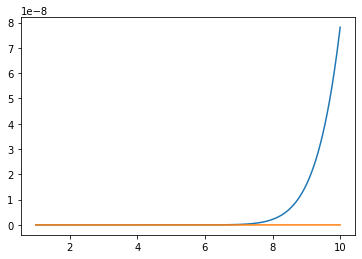

In [499]:
from scipy.stats import wilcoxon
from math import erf
from scipy import special

special.erfinv(0.5)

w,p = wilcoxon(ITE,alternative="greater") 

def normal_Z(Z):
    if Z <= 0:
        return 0.5*(1+erf((Z-0)/np.sqrt(2)))
    else:
        return 1-0.5*(1+erf((Z-0)/np.sqrt(2)))
    
def inverse_wilcox(mu,var):
    return mu+np.sqrt(var)*np.sqrt(2)*special.erfinv(2*0.05-1)
    
arr_min_p = []
arr_max_p = []
min_te = []
max_plot = 10
for i in np.arange(1,max_plot,0.001):#(1,5):
    gam = i
    #print("GAMMA: " +str(gam))
    lamb = gam/(1+gam)
    #print("lamb: "+str(lamb))
    S = len(ITE)

    mu_max = lamb*S*(S+1)/2
    mu_min = (1-lamb)*S*(S+1)/2
    sigm = lamb*(1-lamb)*S*(S+1)*(2*S+1)/6

    arr_min_p.append(normal_Z((w-mu_min)/np.sqrt(sigm)))
    arr_max_p.append(normal_Z((w-mu_max)/np.sqrt(sigm)))
    
    min_te.append(inverse_wilcox(mu_max,sigm))

plt.plot(np.arange(1,max_plot,0.001),np.array(arr_min_p))
plt.plot(np.arange(1,max_plot,0.001),np.array(arr_max_p))

# Patient Demographics MIMIC & GUH

In [3]:
#227428 SOFA mimic
#226743 	APACHE II 	

#13081 numeric items amst (apache II)

In [4]:
admissions_pd_uzgent = pd.read_csv(r"Data/uzgent/uzgent-iv-1.0/df_adm_icu.csv",sep=',')
admissions_pd_uzgent = admissions_pd_uzgent.rename(columns={"subject_id":"patientid","stay_id":"admissionid","los":"lengthofstay"})
admissions_pd_uzgent.loc[:,"intime"] = pd.to_datetime(admissions_pd_uzgent.intime)
admissions_pd_uzgent.loc[:,"outtime"] = pd.to_datetime(admissions_pd_uzgent.outtime)
admissions_pd_uzgent.loc[:,"lengthofstay"]=admissions_pd_uzgent.lengthofstay*24
admissions_pd_uzgent.loc[admissions_pd_uzgent.AF_measuredat=="0","AF_measuredat"]=0.0
admissions_pd_uzgent.loc[admissions_pd_uzgent.AF_measuredat!=0,"AF_measuredat"]=(pd.to_datetime(admissions_pd_uzgent[admissions_pd_uzgent.AF_measuredat!=0].AF_measuredat)-pd.to_datetime(admissions_pd_uzgent[admissions_pd_uzgent.AF_measuredat!=0].intime)).dt.total_seconds()/60/60
admissions_pd_uzgent["AF_measuredat"] = np.float32(admissions_pd_uzgent["AF_measuredat"])
admissions_pd_uzgent = admissions_pd_uzgent[admissions_pd_uzgent.lengthofstay>=12]

weight_csv = pd.read_csv("Data/uzgent/uzgent-iv-1.0/icu/csv/chartevents/"+str(226512)+".csv")[["stay_id","valuenum"]]
weight_csv = weight_csv.rename(columns={"subject_id":"patientid","stay_id":"admissionid","valuenum":"weight"})
height_csv = pd.read_csv("Data/uzgent/uzgent-iv-1.0/icu/csv/chartevents/"+str(226730)+".csv")[["stay_id","valuenum"]]
height_csv = height_csv.rename(columns={"subject_id":"patientid","stay_id":"admissionid","valuenum":"height"})


admissions_pd_uzgent = admissions_pd_uzgent.merge(height_csv,how='left',on='admissionid')
admissions_pd_uzgent.loc[(admissions_pd_uzgent.height<50)|(admissions_pd_uzgent.height>250)]=int(admissions_pd_uzgent[(admissions_pd_uzgent.height<50)|(admissions_pd_uzgent.height>250)].height.mean())
admissions_pd_uzgent = admissions_pd_uzgent.merge(weight_csv,how='left',on='admissionid')
admissions_pd_uzgent.loc[(admissions_pd_uzgent.weight<20)|(admissions_pd_uzgent.weight>500)]=int(admissions_pd_uzgent[(admissions_pd_uzgent.weight<20)|(admissions_pd_uzgent.weight>500)].weight.mean())
admissions_pd_uzgent["BMI"]=admissions_pd_uzgent.weight/((admissions_pd_uzgent.height/100)**2)
    
df_patients = pd.read_csv(r"Data/uzgent/uzgent-iv-1.0/core/csv/patients.csv",sep=',')
df_patients = df_patients.rename(columns={"subject_id":"patientid","anchor_age":"Age"})

admissions_pd_uzgent = admissions_pd_uzgent.merge(df_patients[['patientid','Age','gender']],how='left',on='patientid')
#If no gender was specified, the value is -1.
gender_category = {'M':1,"F":0,"":-1}

#Replace the strings with numbers
admissions_pd_uzgent["gender"]=admissions_pd_uzgent["gender"].replace(gender_category)

admissions_pd_uzgent = admissions_pd_uzgent[(admissions_pd_uzgent.AF==0)|((admissions_pd_uzgent.AF==1)&(admissions_pd_uzgent.AF_measuredat>=12))]

print(len(admissions_pd_uzgent.patientid.unique()))

46234


In [5]:
sofa_uzgent_csv = pd.read_csv("Data/uzgent/uzgent-iv-1.0/uzgent_sofa.csv")[["stay_id","sofa_24hours","starttime","endtime"]]
sofa_uzgent_csv = sofa_uzgent_csv.rename(columns={"stay_id":"admissionid","sofa_24hours":"sofa"})
sofa_uzgent_csv.loc[:,"starttime"]=pd.to_datetime(sofa_uzgent_csv.starttime)
sofa_uzgent_csv.loc[:,"endtime"]=pd.to_datetime(sofa_uzgent_csv.endtime)
sofa_uzgent_csv = sofa_uzgent_csv.merge(admissions_pd_uzgent[["admissionid","patientid","intime","outtime","AF_measuredat","AF"]],how="inner",on="admissionid")
sofa_uzgent_csv["time_to_adm"] = (pd.to_datetime(sofa_uzgent_csv.starttime)-pd.to_datetime(sofa_uzgent_csv.intime)).dt.total_seconds()/60/60
sofa_mean_day_uzgent = sofa_uzgent_csv[sofa_uzgent_csv.time_to_adm<=24][["patientid","admissionid","sofa"]].groupby(["patientid","admissionid"]).mean().reset_index()
sofa_mean_day_uzgent = sofa_mean_day_uzgent.rename(columns={"sofa":"sofa_first24h"})
sofa_AF_uzgent = sofa_uzgent_csv[(sofa_uzgent_csv.AF==1)&(sofa_uzgent_csv.AF_measuredat - sofa_uzgent_csv.time_to_adm <= 1)&(sofa_uzgent_csv.AF_measuredat - sofa_uzgent_csv.time_to_adm >= 0)][["patientid","admissionid","sofa"]].groupby(["patientid","admissionid"]).mean().reset_index()
sofa_AF_uzgent = sofa_AF_uzgent.rename(columns={"sofa":"sofa_AF_matched"})
admissions_pd_uzgent = admissions_pd_uzgent.merge(sofa_mean_day_uzgent,how='left',on=['patientid','admissionid'])
admissions_pd_uzgent = admissions_pd_uzgent.merge(sofa_AF_uzgent,how='left',on=['patientid','admissionid'])

In [6]:
admissions_pd_amst = pd.read_csv("Data/Extracted/admissions_demographics.csv")
admissions_pd_amst = admissions_pd_amst[admissions_pd_amst.lengthofstay>=12]
admissions_pd_amst.loc[admissions_pd_amst.Weight==0] = admissions_pd_amst[admissions_pd_amst.Weight>0].Weight.mean()
admissions_pd_amst.loc[admissions_pd_amst.Height==0] = admissions_pd_amst[admissions_pd_amst.Height>0].Height.mean()
admissions_pd_amst["BMI"]=admissions_pd_amst.Weight/((admissions_pd_amst.Height/100)**2)
admissions_pd_amst["AF_measuredat"] = admissions_pd_amst["AF_measuredat"]/1000/60/60
admissions_pd_amst = admissions_pd_amst[(admissions_pd_amst.AF==0)|((admissions_pd_amst.AF==1)&(admissions_pd_amst.AF_measuredat>=12))]

print(len(admissions_pd_amst.patientid.unique()))

amst_sofa = pd.read_csv(r"Data/sofa.csv",sep=',')
amst_apache_II = pd.read_csv(r"Data/apache_ii.csv",sep=',')
admissions_pd_amst = admissions_pd_amst.merge(amst_sofa[["admissionid","sofa_total_score"]],how='left',on='admissionid')
admissions_pd_amst = admissions_pd_amst.merge(amst_apache_II[["admissionid","apache_ii_total_score"]],how='left',on='admissionid')

16995


In [7]:
print(len(admissions_pd_uzgent.patientid.unique()))
print(len(admissions_pd_amst.patientid.unique()))
print(len(admissions_pd_uzgent[admissions_pd_uzgent.AF==1].patientid.unique()))
print(len(admissions_pd_amst[admissions_pd_amst.AF==1].patientid.unique()))
print(len(admissions_pd_uzgent[admissions_pd_uzgent.AF==0].patientid.unique()))
print(len(admissions_pd_amst[admissions_pd_amst.AF==0].patientid.unique()))

46234
16995
5165
1868
42638
15450


In [63]:
print("AMSTERDAM COLUMNS")
print("")
print(admissions_pd_amst.columns)
print(50*"-")
print("")
print("UZGENT COLUMNS")
print("")
print(admissions_pd_uzgent.columns)

AMSTERDAM COLUMNS

Index(['patientid', 'admissionid', 'admissioncount', 'location', 'urgency',
       'origin', 'admittedat', 'admissionyeargroup', 'dischargedat',
       'lengthofstay', 'destination', 'gender', 'agegroup', 'dateofdeath',
       'weightgroup', 'weightsource', 'heightgroup', 'heightsource',
       'specialty', 'dateofdeath_delta', 'admittedat_delta', 'Height', 'Age',
       'Weight', 'Gender_category', 'Mortality', 'sepsis_bool', 'neuro_bool',
       'cardiac_surg_bool', 'cardio_surgery_new', 'AF', 'new_onset_AF',
       'Preadmission_AF', 'AF_measuredat', 'BMI', 'sofa_total_score',
       'apache_ii_total_score'],
      dtype='object')
--------------------------------------------------

MIMIC COLUMNS

Index(['patientid', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admission_location', 'discharge_location',
       'insurance', 'language', 'marital_status', 'ethnicity', 'edregtime',
       'edouttime', 'hospital_expire_flag', 'admissionid'

In [80]:
admissions_pd_uzgent[admissions_pd_uzgent.AF==1].admission_type.value_counts()

EW EMER.                       2325
URGENT                         1292
SURGICAL SAME DAY ADMISSION     695
OBSERVATION ADMIT               623
ELECTIVE                        362
DIRECT EMER.                    240
EU OBSERVATION                    2
Name: admission_type, dtype: int64

In [81]:
(1292+623)/len(admissions_pd_uzgent[admissions_pd_uzgent.AF==1])*100

12.54739122585304

In [75]:
admissions_pd_amst[admissions_pd_amst.AF==0].specialty.value_counts()

Cardiochirurgie                 6172
Neurochirurgie                  2092
Vaatchirurgie                   1019
Traumatologie                    931
Inwendig                         864
0                                815
Heelkunde Gastro-enterologie     793
Cardiologie                      733
Intensive Care Volwassenen       702
Neurologie                       578
Heelkunde Oncologie              374
Longziekte                       310
Nefrologie                       288
Keel, Neus & Oorarts             284
Heelkunde Longen/Oncologie       266
Urologie                         145
Hematologie                      143
Orthopedie                       134
Gynaecologie                     132
Maag-,Darm-,Leverziekten         119
Oncologie Inwendig                64
ders                              45
Plastische chirurgie              32
Mondheelkunde                     17
Verloskunde                       11
Obstetrie                         10
Oogheelkunde                       2
R

In [77]:
(6172+2092+1019+32)/len(admissions_pd_amst[admissions_pd_amst.AF==0])*100

54.55024595924104

In [266]:
admissions_pd_uzgent.admission_type.value_counts()

EW EMER.                       33444
URGENT                         10756
OBSERVATION ADMIT               7707
SURGICAL SAME DAY ADMISSION     6761
DIRECT EMER.                    2416
ELECTIVE                        2195
EU OBSERVATION                   293
DIRECT OBSERVATION               113
AMBULATORY OBSERVATION            12
Name: admission_type, dtype: int64

In [256]:
admissions_pd_uzgent[admissions_pd_uzgent.AF>=0].drop_duplicates("patientid").ethnicity.value_counts()

WHITE                            30782
UNKNOWN                           4956
BLACK/AFRICAN AMERICAN            4437
OTHER                             2259
HISPANIC/LATINO                   1705
ASIAN                             1365
UNABLE TO OBTAIN                   652
AMERICAN INDIAN/ALASKA NATIVE       78
Name: ethnicity, dtype: int64

In [18]:
print(admissions_pd_amst[admissions_pd_amst.AF==0].cardio_surgery_new.sum())
print(admissions_pd_amst[admissions_pd_amst.AF==0].sepsis_bool.sum())
admissions_pd_amst[admissions_pd_amst.AF==0].drop_duplicates("patientid").describe()

4532.0
1835.0


,patientid,admissionid,admissioncount,urgency,admittedat,dischargedat,lengthofstay,dateofdeath,Height,Age,Weight,Gender_category,Mortality,sepsis_bool,neuro_bool,cardiac_surg_bool,cardio_surgery_new,AF,new_onset_AF,Preadmission_AF,AF_measuredat,BMI,sofa_total_score,apache_ii_total_score
count,15450.000000,15450.000000,15450.000000,15450.000000,1.545000e+04,1.545000e+04,15450.000000,1.545000e+04,15450.000000,15450.000000,15450.000000,15450.000000,15450.000000,15450.000000,15450.000000,15450.000000,15450.000000,15450.0,15450.0,15450.0,0.0,15450.000000,15450.000000,15450.000000
mean,10177.410550,11787.882783,1.019482,0.260000,4.682669e+08,7.356903e+08,74.293981,1.820464e+10,175.159871,61.450485,80.352751,0.651586,0.255340,0.108414,0.025696,0.315275,0.287249,0.0,0.0,0.0,NaN,26.177913,5.633657,16.271942
std,5867.151499,6801.205930,0.148162,0.438648,8.272208e+09,8.288313e+09,151.841983,5.629736e+10,9.516450,14.379398,14.567641,0.476483,0.436066,0.310913,0.158231,0.464640,0.452493,0.0,0.0,0.0,NaN,4.308280,3.320151,6.555675
min,0.000000,0.000000,1.000000,0.000000,0.000000e+00,3.978000e+07,12.000000,-1.382944e+11,155.000000,35.000000,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN,16.070124,0.000000,0.000000
25%,5106.250000,5891.250000,1.000000,0.000000,0.000000e+00,7.290000e+07,20.000000,0.000000e+00,165.000000,55.000000,75.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN,23.875115,3.000000,12.000000
50%,10174.500000,11786.500000,1.000000,0.000000,0.000000e+00,8.658000e+07,24.000000,0.000000e+00,175.000000,65.000000,75.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN,24.835646,5.000000,15.500000
75%,15277.750000,17694.750000,1.000000,1.000000,0.000000e+00,2.111850e+08,54.750000,2.673000e+07,185.000000,75.000000,85.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.0,0.0,0.0,NaN,27.757487,7.000000,19.500000
max,20326.000000,23552.000000,4.000000,1.000000,3.025603e+11,3.026390e+11,4850.000000,4.515988e+11,195.000000,85.000000,115.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,NaN,47.866805,23.000000,46.500000


In [19]:
print(admissions_pd_uzgent[admissions_pd_uzgent.AF==0].cardiac_bool_new.sum())
print(admissions_pd_uzgent[admissions_pd_uzgent.AF==0].sepsis_bool.sum())
admissions_pd_uzgent[admissions_pd_uzgent.AF==0].drop_duplicates("patientid").describe()

7795
25657


,patientid,hadm_id,hospital_expire_flag,admissionid,lengthofstay,admissioncount,AF,AF_measuredat,sepsis_bool,surgery_bool,cardiac_bool,medical_bool,cardiac_bool_new,height,weight,BMI,Age,gender,sofa_first24h,sofa_AF_matched
count,4.263800e+04,4.263800e+04,42638.000000,4.263800e+04,42638.000000,42638.000000,42638.0,42638.0,42638.000000,42638.000000,42638.000000,42638.000000,42638.000000,20832.000000,41618.000000,20706.000000,42638.000000,42638.000000,42582.000000,0.0
mean,1.498613e+07,2.496366e+07,0.079624,3.498713e+07,73.580190,0.039519,0.0,0.0,0.430602,0.396149,0.260753,0.658098,0.155730,169.192207,81.258499,29.470176,61.242718,0.558141,3.261266,NaN
std,2.885215e+06,2.886143e+06,0.270713,2.889631e+06,101.831461,0.241681,0.0,0.0,0.495166,0.489102,0.439051,0.474352,0.362603,12.854252,22.729010,13.320304,17.134181,0.496614,2.685457,NaN
min,1.000122e+07,2.000015e+07,0.000000,3.000015e+07,12.003611,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,53.000000,20.500000,8.425926,18.000000,0.000000,0.000000,NaN
25%,1.247236e+07,2.246444e+07,0.000000,3.247262e+07,26.308472,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,163.000000,65.900000,24.056935,51.000000,0.000000,1.000000,NaN
50%,1.498289e+07,2.493109e+07,0.000000,3.498649e+07,43.157361,0.000000,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,170.000000,78.400000,27.587326,63.000000,1.000000,2.680000,NaN
75%,1.747906e+07,2.746260e+07,0.000000,3.748096e+07,75.436319,0.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000,0.000000,178.000000,93.000000,32.098765,74.000000,1.000000,4.680000,NaN
max,1.999999e+07,2.999983e+07,1.000000,3.999981e+07,2645.574722,8.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,241.000000,345.000000,322.265625,91.000000,1.000000,20.800000,NaN


In [12]:
5165*0.692352

3575.99808

In [251]:
admissions_pd_uzgent.AF_measuredat

0        0
1        0
2        0
3        0
4        0
        ..
73296    0
73297    0
73298    0
73299    0
73300    0
Name: AF_measuredat, Length: 63697, dtype: object

In [238]:
1-0.519807

0.480193

In [239]:
1868*0.480193

897.0005239999999

In [70]:
from scipy import stats

stats.ttest_ind(admissions_pd_amst[admissions_pd_amst.AF==0].sofa_total_score, admissions_pd_uzgent[(admissions_pd_uzgent.AF==0)&(~admissions_pd_uzgent.sofa_first24h.isna())].sofa_first24h)

Ttest_indResult(statistic=89.04583511565711, pvalue=0.0)

In [177]:
stats.ranksums(admissions_pd_amst[admissions_pd_amst.AF==0].Gender_category, admissions_pd_uzgent[admissions_pd_uzgent.AF==0].gender)

RanksumsResult(statistic=19.22334668618072, pvalue=2.3604300563401304e-82)

# All results visualisation

In [462]:
guh_df = pd.read_csv("uzgent_af_prediction_results.csv")
guh_df["dataset"]="uzgent"
guh_df.loc[guh_df.patient_group.str.contains("uzgent"),'patient_group']=guh_df.patient_group.str.replace(' uzgent', '')
mimic_df = pd.read_csv("mimic_af_prediction_results.csv")
mimic_df["dataset"]="mimic"
mimic_df.loc[mimic_df.patient_group.str.contains("mimic"),'patient_group']=mimic_df.patient_group.str.replace(' mimic', '')
amc_df = pd.read_csv("amsterdam_af_prediction_results.csv")
amc_df["dataset"]="amst"

results_df = pd.concat([guh_df,mimic_df,amc_df])

In [463]:
results_df

,model,validation_type,patient_group,NO AF patients,AF patients,NO AF recall,AF recall,NO AF precision,AF precision,NO AF f1,AF f1,mcc,auc,dataset
0,12u,transfer,balanced test,187,165,0.700535,0.690909,0.719780,0.670588,0.710027,0.680597,0.390906,0.791249,uzgent
1,12u,transfer,sepsis,2116,14,0.725425,0.500000,0.995460,0.011905,0.839256,0.023256,0.040747,0.701627,uzgent
2,12u,transfer,sepsis balanced,14,14,0.714286,0.500000,0.588235,0.636364,0.645161,0.560000,0.219382,0.683673,uzgent
3,12u,transfer,all patients,15824,165,0.693883,0.690909,0.995377,0.022993,0.817725,0.044505,0.084075,0.784244,uzgent
4,12u,combo,sepsis,2116,14,0.701796,0.642857,0.996644,0.014063,0.823627,0.027523,0.060746,0.717391,uzgent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,12u old,base model,cardiac,3933,80,0.865243,0.725000,0.993577,0.098639,0.924980,0.173653,0.233302,0.891068,amst
32,12u old,base model,cardiac balanced,80,80,0.850000,0.725000,0.755556,0.828571,0.800000,0.773333,0.579546,0.875625,amst
33,12u old,base model,sepsis,1664,83,0.476562,0.867470,0.986318,0.076352,0.642626,0.140351,0.146836,0.773126,amst
34,12u old,base model,sepsis balanced,83,83,0.506024,0.867470,0.792453,0.637168,0.617647,0.734694,0.400576,0.786036,amst


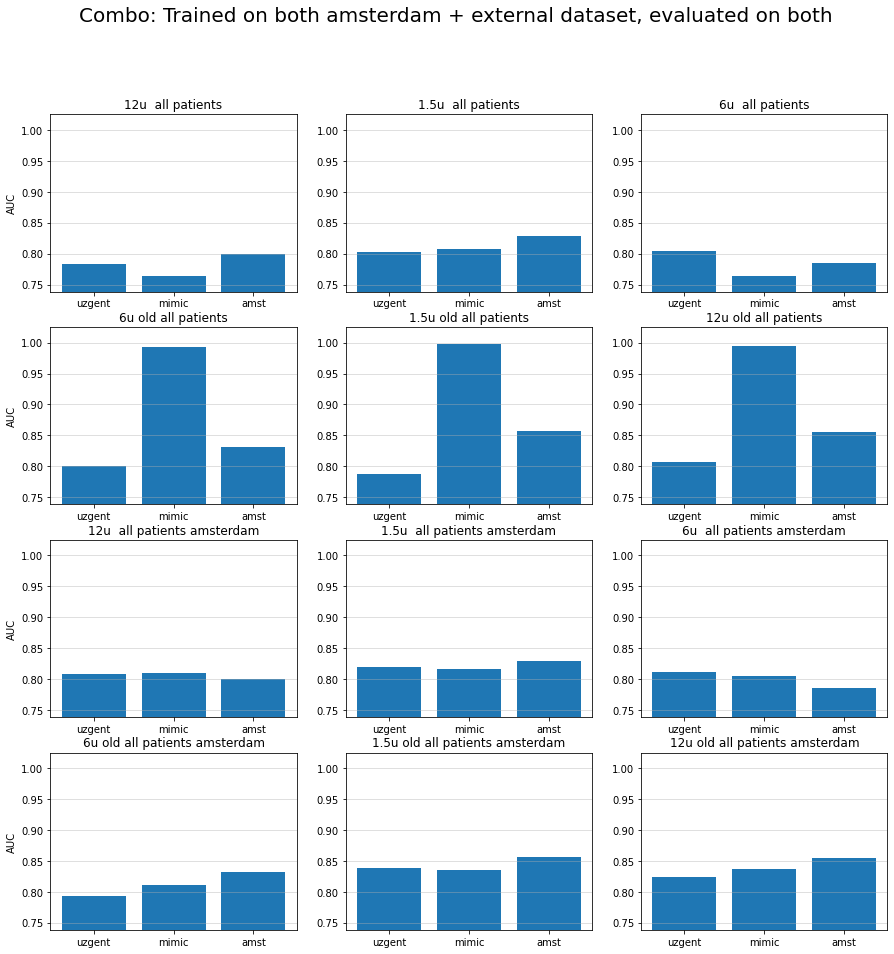

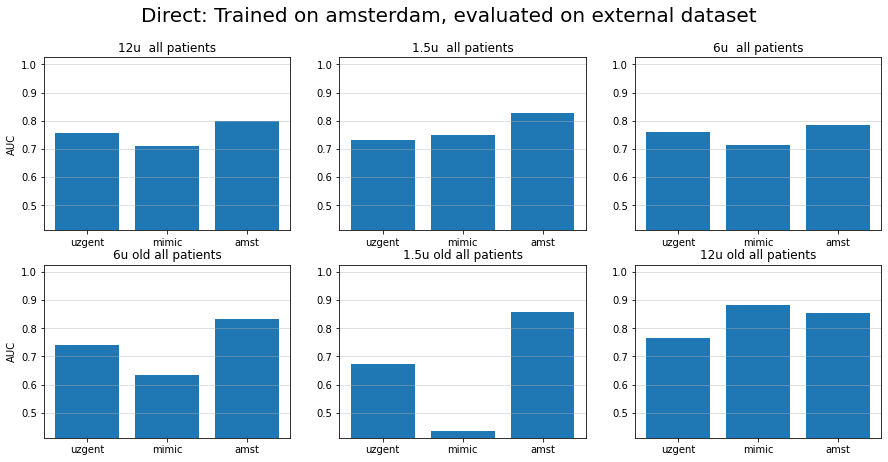

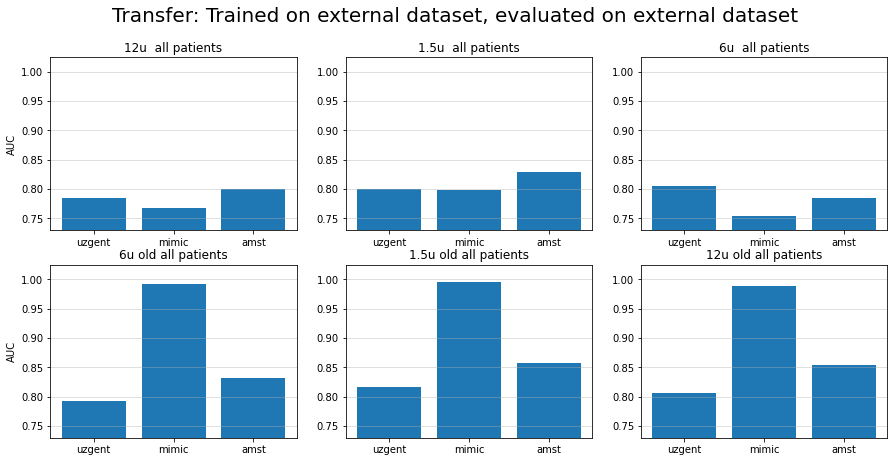

In [464]:
patient_group_string = "all patients"

for val_string in ["combo","direct","transfer"]:
    validation_comparison_string = val_string#"direct" #"combo" "direct" "transfer"

    plot_df = results_df[(results_df.validation_type.str.contains(validation_comparison_string+"|base model",regex=True))&(results_df.patient_group.str.contains(patient_group_string))]
    min_ylim = np.min(plot_df.auc.values)-0.025
    i = 0
    len_patient_groups = len(plot_df.patient_group.unique())
    
    if validation_comparison_string=="combo":
        fig, ax = plt.subplots(4,3,figsize=(15,15))
    else:
        fig, ax = plt.subplots(2,3,figsize=(15,7))
        
    for patient_group in plot_df.patient_group.unique():
        for model_string in plot_df.model.unique():
                temp_plot_df = plot_df[(plot_df.model==model_string)&((plot_df.validation_type=="base model")|(plot_df.patient_group == patient_group))]
                ax[int((i-i%3)/3),i%3].grid(alpha=0.5,axis='y')
                ax[int((i-i%3)/3),i%3].bar(temp_plot_df.dataset.values,temp_plot_df.auc.values)
                ax[int((i-i%3)/3),i%3].set_title(model_string+ " "+patient_group)
                if i%3 == 0:
                    ax[int((i-i%3)/3),i%3].set_ylabel("AUC")
                ax[int((i-i%3)/3),i%3].set_ylim([min_ylim,1.025])


                i += 1
    if validation_comparison_string == "combo":
        fig.suptitle("Combo: Trained on both amsterdam + external dataset, evaluated on both",fontsize=20)
    elif validation_comparison_string == "direct":
        fig.suptitle("Direct: Trained on amsterdam, evaluated on external dataset",fontsize=20)
    elif validation_comparison_string == "transfer":
        fig.suptitle("Transfer: Trained on external dataset, evaluated on external dataset",fontsize=20)
    plt.savefig("results/"+validation_comparison_string+"_"+patient_group_string+"_results.jpg", bbox_inches="tight")
    plt.savefig("results/"+validation_comparison_string+"_"+patient_group_string+"_results.png", bbox_inches="tight")